In [ ]:
#Реализация для расчетов по годам

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
from matplotlib import pyplot
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
import math
import xarray as xr
from windrose import WindroseAxes
from scipy import interpolate

# 1. Загрузка шейп-файла береговой линии (упрощенная для расчетов полос разгона)
shoreline_gdf = gpd.read_file('D:/PyProjects/Knaps/coastline_sms.shp', crs="EPSG:32634") #!!!!!!!!!!!!
# 1. Загрузка шейп-файла трансект с параметрами координаты центра лежит на береговой линии, угол bearing - результат построения трансект в гис по подробной береговой линии
transects_gdf = gpd.read_file('D:/PyProjects/Knaps/transects_gdf_era5utm.shp', crs="EPSG:32634")
calc_gdf = gpd.GeoDataFrame(transects_gdf.copy(), geometry=gpd.points_from_xy(transects_gdf.copy().INSIDE_X, transects_gdf.copy().INSIDE_Y), crs="EPSG:32634")

#year_of_calculation = 2000
rhumb_sectors=32 #!!!!!!! Румбовая дискретизация
speed_bins=4 #!!!!!!!!
ERAlat = float(transects_gdf.NEAR_Y_1[0])
ERAlong = float(transects_gdf.NEAR_X_1[0])
#start_date = f"{year_of_calculation}-01-01"
#end_date = f"{year_of_calculation}-12-31"
point_x = float(transects_gdf.INSIDE_X[0])
point_y = float(transects_gdf.INSIDE_Y[0])
normal_to_beach = float(transects_gdf.BEARING[0])


def Knaps1961gdb(shoreline_gdf, 
                 point_x,
                 point_y,
                 year_of_calc,
                 normal_to_beach, 
                 rhumb_sectors, 
                 speed_bins,
                 ERAlat,
                 ERAlong,
                 ):
    #outlist = list()
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)
    
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    year_of_calc = year_of_calculation
    year_of_calc = month_of_calculation
    start_date = f"{year_of_calculation}-01-01"
    end_date = f"{year_of_calculation}-12-31"
    params = {
        "latitude": ERAlat, #!!!!!!!!!
        "longitude": ERAlong, #!!!!!!!!!!
        "start_date": start_date, #!!!!!!!!!!
        "end_date": end_date, #!!!!!!!!!!!
        "hourly": ["wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
        "wind_speed_unit": "ms",
        "timezone": "UTC",
        "models": "era5"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data. The order of variables needs to be the same as requested.

    hourly = response.Hourly()
    hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(2).ValuesAsNumpy()


    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd()-1, unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval())
    )}
    hourly_data["speed"] = hourly_wind_speed_10m
    hourly_data["direction"] = hourly_wind_direction_10m
    hourly_data["gusts"] = hourly_wind_gusts_10m
    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe["year"] = pd.DatetimeIndex(hourly_dataframe['date']).year
    hourly_dataframe["month"] = pd.DatetimeIndex(hourly_dataframe['date']).month
    #hourly_dataframe["speed"] = hourly_dataframe["speed"][hourly_dataframe["speed"] > 12]
    #hourly_dataframe["speed"].where(hourly_dataframe["speed"] <= 12, 0, inplace=True)
    # Функция для округления направления ветра до ближайшего значения из списка directions
    def round_dir(direction, directions):
        closest = min(directions, key=lambda x: abs(x - direction))
        return closest


    ws = hourly_dataframe["speed"]
    wd = hourly_dataframe["direction"]
    fig = plt.figure(dpi=5)
    ax = WindroseAxes.from_ax(figsize=(1, 1))
    #ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, nsector=rhumb_sectors, bins=speed_bins)
    ax._info["frq"] = np.sum(ax._info["table"], axis=0)
    hourly_dataframe['rounded_direction'] = hourly_dataframe['direction'].apply(lambda x: round_dir(x, ax._info["dir"])) # Округляем все направления ветра до ближайших значений из списка directions

    # Направление нормали к берегу в градусах (например, 0° означает, что берег открыт ветрам с севера)

    ax_dataframe = pd.DataFrame.from_dict(data = {'dir': ax._info['dir'], 'freq': ax._info['frq']})
    sector_mean_speed = hourly_dataframe.groupby('rounded_direction')['speed'].mean().reset_index(name='mean_speed')
    ax_dataframe['V'] = sector_mean_speed['mean_speed']

    def filter_active_rumbs(df, normal_to_beach, wind_direction_column='wind_direction'):
        # Определяем границы активного диапазона вокруг нормали
        lower_bound = (normal_to_beach - 90) % 360
        upper_bound = (normal_to_beach + 90) % 360

        if lower_bound > upper_bound:
            # Если граница пересекает 0/360, используем два условия
            index = ((df[wind_direction_column] >= lower_bound) | (df[wind_direction_column] <= upper_bound))
        else:
            # Обычное условие для непрерывного интервала
            index = ((df[wind_direction_column] >= lower_bound) & (df[wind_direction_column] <= upper_bound))

        return df[index]


    def wind_power(V): #Мощность, V^3
        windpower = V * V * V
        return windpower
    def wind_energy(frequency, windpower): #Ветровая энергия, PV^3
        windenergy = frequency * windpower
        return windenergy
    def fetch_factor(fetchlength): #Коэффициент длины рагона, кубический корень из длины разгона (в км)
        return fetchlength ** 0.333
    def get_e0(frequency, windpower, fetchfactor): #Величина румбовой энергии e0 = PV^3*D^0.333/1000
        e0 = (frequency * windpower * fetchfactor) / 1000
        return e0
    def get_rhumb_fulness(): #Коэффициент полноты румбовых секторов
        K=1 #Для малой дискретизации (даже 5 градусов) считаю можно всегда 1 оставлять
        return K
    def get_e(K, e0): #Приведенная румбовая энергия e = Ke0
        e = K * e0
        return e
    def getenergy(V, frequency, fetchlength, K=1):
        windpowert = wind_power(V)
        windenergyt = wind_energy(frequency, windpowert)
        fetchfactort = fetch_factor(fetchlength)
        e0t = get_e0(frequency, windpowert, fetchfactort)
        et = get_e(K, e0t)
        return et
    def get_y0(normal_angle, rhumb_angle): #Определение угла подхода y0
        # Переводим углы из градусов в радианы
        rad1 = np.radians(normal_angle)
        rad2 = np.radians(rhumb_angle)
        # Вычисляем разность углов
        diff = (rad1 - rad2) % (2 * np.pi)
        # Преобразуем результат обратно в градусы
        y0 = np.degrees(np.where(diff > np.pi, diff - 2 * np.pi, diff))
        return y0
    def get_alongc(y0): #Коэффициент действенности вдоль берега
        polarity = np.sign(y0)
        y0 = np.abs(y0)
        y0arr = np.array([0, 20, 40, 45, 50, 60, 90, 110, 120, 180])
        Sarr = np.array([0, 0.63, 0.965, 1, 0.975 ,0.87, 0.435, 0.135, 0, 0])
        falong = interpolate.interp1d(y0arr, Sarr)
        return polarity * falong(y0)
    def get_crossc(y0): #Коэффициент действенности прибоя
        polarity = np.sign(y0)
        y0 = np.abs(y0)
        y0arr = np.array([0, 20, 45, 60, 90, 110, 120, 180])
        Barr = np.array([1, 0.93, 0.71, 0.58, 0.28, 0.1, 0, 0])
        fcross = interpolate.interp1d(y0arr, Barr)
        return fcross(y0)
    def get_tforce(e, alongc): #Наносодвижущая сила
        t = e * alongc
        return t
    def get_bforce(e, crossc): #Сила прибоя
        b = e * crossc
        return b


    start_point = Point(point_x, point_y)
    def calculate_distance_along_ray(point, linestring, direction_angle, max_distance=1000000):
        """
        Рассчитывает расстояние от точки до пересечения с линией по направлению угла.

        :param point: Начальная точка (Shapely Point)
        :param linestring: Линия (Shapely LineString)
        :param direction_angle: Направление в градусах (от 0 до 360)
        :param max_distance: Максимальная длина луча (по умолчанию 1000 км)
        :return: Расстояние до пересечения с линией
        """
        # Преобразуем угол направления в радианы
        angle_rad = np.radians(direction_angle)

        # Вычисляем вектор движения по углу
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        # Определяем конечную точку луча (на расстоянии max_distance)
        end_point = Point(point.x + dx * max_distance, point.y + dy * max_distance)

        # Строим линию от начальной точки до конечной точки
        ray = LineString([point, end_point])

        # Находим пересечение луча с линией береговой линии
        intersection = ray.intersection(linestring)

        if not intersection.is_empty:
            return point.distance(intersection)
        else:
            return None


    # 3. Выполнение расчетов для различных направлений (например, каждые 10 градусов)
    angles = ax_dataframe['dir']
    distances = []
    directions = []

    for angle in angles:
        for _, row in shoreline_gdf.iterrows():
            distance = calculate_distance_along_ray(start_point, row['geometry'], angle, max_distance=700000)

            if distance is not None:
                distances.append(distance / 1000)  # Преобразуем метры в километры
                directions.append((90 - angle) % 360) # Вращаемся на 90 крадусов, т.к. расчет в гис ведется от востока
                break

    # 4. Формирование таблицы Pandas
    result_df = ax_dataframe.set_index('dir').join((pd.DataFrame({
        'dir': directions,
        'Rhumbdir': directions,
        'D': distances
    })).set_index('Rhumbdir'))


    # Отображение результатов

    rhumbdf = result_df #pd.DataFrame.from_dict(data=input_data, orient='index', columns = ['Name','Rhumbdir', 'P', 'V', 'D'])
    rhumbdf['Energy'] = getenergy(V = rhumbdf['V'], frequency = rhumbdf['freq'], fetchlength = rhumbdf['D'], K = 1)
    rhumbdf['y0'] = get_y0(normal_angle=normal_to_beach, rhumb_angle=rhumbdf['dir'])
    rhumbdf['alongc'] = get_alongc(y0=rhumbdf['y0'])
    rhumbdf['crossc'] = get_crossc(y0=rhumbdf['y0'])
    rhumbdf['t'] = get_tforce(e=rhumbdf['Energy'], alongc=rhumbdf['alongc'])
    rhumbdf['b'] = get_bforce(e=rhumbdf['Energy'], crossc=rhumbdf['crossc'])

    

    awd = filter_active_rumbs(rhumbdf, normal_to_beach, wind_direction_column='dir')
    
    # Создаем копию данных, чтобы избежать изменения исходного DataFrame
    df_copy = awd.copy()
    
    # Преобразуем NaN значения к нулю, чтобы они не влияли на сумму
    df_copy['t'].fillna(0, inplace=True)
    
    # Находим положительные и отрицательные значения
    T1 = (df_copy['t'][df_copy['t'] > 0]).sum()
    T2 = (df_copy['t'][df_copy['t'] < 0]).sum()
    T = T1 + T2
    A = np.abs(T1) + np.abs(T2)
    B = df_copy['b'].sum()
    E = np.sqrt(np.power(T, 2) + np.power(B, 2))
    t = T / B
    y = np.rad2deg(np.arctan2(T, B))
    thau = (normal_to_beach + y) % 360
    output = {'point_x':point_x, 
        'point_y':point_y,
        'year':year_of_calc,
        'era_lat':ERAlat, 
        'era_long':ERAlong, 
        'normal_to_beach':normal_to_beach,
        'T1':T1,
        'T2':T2,
        'T':T,
        'A':A,
        'B':B,
        'E':E,
        't':t,
        'y':y,
        'thau':thau,
        'table':df_copy,
        #'fig':fig
             }
    print(output)
    outlist.append(output)
    return output

In [ ]:
outlist = list()
for year_of_calculation in list(range(2000, 2025, 1)):
    print(year_of_calculation)
    calc_gdf2 = calc_gdf.apply(lambda row: Knaps1961gdb(shoreline_gdf=shoreline_gdf, 
                                                                          point_x=row['INSIDE_X'], 
                                                                          point_y=row['INSIDE_Y'],
                                                                          year_of_calc=year_of_calculation,
                                                                          normal_to_beach=row['BEARING'], 
                                                                          rhumb_sectors=32, 
                                                                          speed_bins=4, 
                                                                          ERAlong=row['NEAR_X_1'], 
                                                                          ERAlat=row['NEAR_Y_1'], 
                                                                         ), axis=1, result_type='broadcast')
#result_gdf = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
#result_gdf.to_file('knaps_21cent.shp', driver='ESRI Shapefile')

In [ ]:
result_gdf = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
#result_gdfd6 = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
#result_gdfera = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
#result_gdf = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
fullspeeds_gdf = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
#stormspeeds_gdf = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")


In [ ]:
plt.scatter(result_gdf['t'], result_gdf2['t'] - result_gdf['t'])

In [ ]:
(result_gdf2['t'] - result_gdf['t']).plot(legend=True, marker='o', markersize=10, figsize=(15, 15))

In [ ]:
result_gdf.loc[result_gdf['year'].isin([2022])].plot(column="E", legend=True, marker='o', markersize=10, figsize=(15, 15))

In [ ]:
plt.plot(np.array(result_gdf.loc[result_gdf['year'].isin([2022])]['E']) - np.array(result_gdf.loc[result_gdf['year'].isin([2023])]['E']))

In [ ]:
result_gdf_db = result_gdf.set_index('point_x').join(result_gdf.groupby("point_x").agg(
    min_t=pd.NamedAgg(column="t", aggfunc="min"),
    max_t=pd.NamedAgg(column="t", aggfunc="max"),
    average_t=pd.NamedAgg(column="t", aggfunc="mean"),
))

result_gdf_db.plot(column="average_t", legend=True, marker='o', markersize=5, figsize=(15, 15))

In [ ]:
def mover(point_c, year, dist):
    dx = (year - 2000) * dist
    return point_c + dx

In [ ]:
result_gdf['new_x'] = mover(result_gdf['point_x'], result_gdf['year'], -1000)
result_gdf['new_y'] = mover(result_gdf['point_y'], result_gdf['year'], 1000)
result_gdf_moved = gpd.GeoDataFrame(result_gdf, geometry=gpd.points_from_xy(result_gdf['new_x'], result_gdf['new_y']), crs="EPSG:32634")

In [ ]:
result_gdf_moved.plot(column="t", legend=True, marker='o', markersize=5, figsize=(15, 15))

In [ ]:
result_gdf_moved.to_file('knaps_full.shp', driver='ESRI Shapefile')

In [ ]:
result_gdf_moved['table'] = result_gdf_moved['table'].astype(str)

In [ ]:
(fullspeeds_gdf['t'] - stormspeeds_gdf['t']).plot()

In [ ]:
dfjoined = gpd.merge(stormspeeds_gdf, fullspeeds_gdf, left_index=True, right_index=True)

In [ ]:
ccct = pd.concat([stormspeeds_gdf, fullspeeds_gdf])

In [ ]:
ccct.plot()

Coordinates 55.5°N 20.75°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hourly_dataframe["speed"].where(hourly_dataframe["speed"] <= 12, 0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

{'point_x': 503195.727026, 'point_y': 6139880.91605, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 279.435937935, 'T1': 27.226148704958216, 'T2': -20.53704546935873, 'T': 6.689103235599486, 'A': 47.76319417431695, 'B': 59.98278426906225, 'E': 60.354606375697365, 't': 0.11151705138585194, 'y': 6.363165743312785, 'thau': 285.7991036783128, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875   92.030560  1.053976 -77.751562   
2.8125    1.099613  5.670263    2.8125   40.030321  0.684928 -83.376562   
8.4375    1.115583  5.680618    8.4375   24.877545  0.596338 -89.001562   
194.0625  1.336874  6.494172  194.0625    0.130366  0.185786  85.373438   
199.6875  1.398927  6.617760  199.6875    0.449536  0.310670  79.748438   
205.3125  1.481968  6.563836  205.3125   18.994664  1.117111  74.123438   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 503009.791503, 'point_y': 6139416.87984, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 280.900063511, 'T1': 28.17081026322867, 'T2': -20.181121986024518, 'T': 7.989688277204152, 'A': 48.35193224925319, 'B': 59.83136241126668, 'E': 60.36246388903645, 't': 0.13353679333398624, 'y': 7.606096839797652, 'thau': 288.50616035079764, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875   93.119460  1.058112 -76.287436   
2.8125    1.099613  5.670263    2.8125   40.932811  0.690032 -81.912436   
8.4375    1.115583  5.680618    8.4375   26.409734  0.608325 -87.537436   
194.0625  1.336874  6.494172  194.0625    0.091040  0.164849  86.837564   
199.6875  1.398927  6.617760  199.6875    0.213927  0.242609  81.212564   
205.3125  1.481968  6.563836  205.3125   18.226656  1.101863  75.587564   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 502817.531094, 'point_y': 6138955.36641, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.399808779, 'T1': 28.546242525672948, 'T2': -20.822833791998256, 'T': 7.723408733674692, 'A': 49.3690763176712, 'B': 60.32207272876487, 'E': 60.81450074416299, 't': 0.12803619611021336, 'y': 7.296236752797705, 'thau': 288.6960455317977, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  918.167760  2.267223 -75.787691   
2.8125    1.099613  5.670263    2.8125   41.817461  0.694963 -81.412691   
8.4375    1.115583  5.680618    8.4375   27.501738  0.616589 -87.037691   
194.0625  1.336874  6.494172  194.0625    0.087448  0.162654  87.337309   
199.6875  1.398927  6.617760  199.6875    0.772803  0.372096  81.712309   
205.3125  1.481968  6.563836  205.3125   17.518533  1.087419  76.087309   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 502646.607485, 'point_y': 6138485.63044, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.394523167, 'T1': 28.442385699861518, 'T2': -20.83274524568734, 'T': 7.609640454174176, 'A': 49.27513094554886, 'B': 60.263012517142144, 'E': 60.741561598982905, 't': 0.12627381434025675, 'y': 7.196866398742524, 'thau': 288.59138956574253, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  918.508588  2.267503 -75.792977   
2.8125    1.099613  5.670263    2.8125   42.674521  0.699674 -81.417977   
8.4375    1.115583  5.680618    8.4375   28.505973  0.623997 -87.042977   
194.0625  1.336874  6.494172  194.0625    0.127433  0.184383  87.332023   
199.6875  1.398927  6.617760  199.6875    0.303685  0.272631  81.707023   
205.3125  1.481968  6.563836  205.3125   16.709920  1.070440  76.082023   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 502444.827187, 'point_y': 6138028.56908, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 282.0915837, 'T1': 28.82527258154958, 'T2': -20.654678715403982, 'T': 8.170593866145598, 'A': 49.47995129695356, 'B': 60.16251760954627, 'E': 60.714801566376394, 't': 0.13580870932251565, 'y': 7.733949160698917, 'thau': 289.8255328606989, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  918.816609  2.267757 -75.095916   
2.8125    1.099613  5.670263    2.8125   43.540772  0.704372 -80.720916   
8.4375    1.115583  5.680618    8.4375   29.800006  0.633290 -86.345916   
194.0625  1.336874  6.494172  194.0625    0.086382  0.161991  88.029084   
199.6875  1.398927  6.617760  199.6875    0.180046  0.229071  82.404084   
205.3125  1.481968  6.563836  205.3125   16.051682  1.056210  76.779084   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 502253.264996, 'point_y': 6137566.81238, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.188774012, 'T1': 28.22383335183506, 'T2': -20.90494196635718, 'T': 7.318891385477883, 'A': 49.12877531819224, 'B': 60.252473339842226, 'E': 60.69535991062925, 't': 0.12147038917717312, 'y': 6.925810068355082, 'thau': 288.1145840803551, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  919.136211  2.268019 -75.998726   
2.8125    1.099613  5.670263    2.8125   44.462702  0.709304 -81.623726   
8.4375    1.115583  5.680618    8.4375   30.807520  0.640341 -87.248726   
194.0625  1.336874  6.494172  194.0625    0.039944  0.125298  87.126274   
199.6875  1.398927  6.617760  199.6875    0.131510  0.206320  81.501274   
205.3125  1.481968  6.563836  205.3125   15.220073  1.037664  75.876274   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 502067.063031, 'point_y': 6137102.83365, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.527544657, 'T1': 28.624815177318013, 'T2': -20.82321762661573, 'T': 7.801597550702283, 'A': 49.44803280393374, 'B': 60.34391222026329, 'E': 60.84613928911156, 't': 0.1292855776772546, 'y': 7.366655352025947, 'thau': 288.89420000902595, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  919.461536  2.268286 -75.659955   
2.8125    1.099613  5.670263    2.8125   45.809186  0.716386 -81.284955   
8.4375    1.115583  5.680618    8.4375   31.693683  0.646417 -86.909955   
194.0625  1.336874  6.494172  194.0625    0.099666  0.169894  87.465045   
199.6875  1.398927  6.617760  199.6875    2.818317  0.572499  81.840045   
205.3125  1.481968  6.563836  205.3125   14.364032  1.017853  76.215045   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 501912.074754, 'point_y': 6136627.77437, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 279.595187753, 'T1': 27.021731492735505, 'T2': -21.305217026187606, 'T': 5.716514466547899, 'A': 48.32694851892311, 'B': 60.443512609037995, 'E': 60.71323376468417, 't': 0.09457614588886616, 'y': 5.402743700053103, 'thau': 284.9979314530531, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  919.818475  2.268580 -77.592312   
2.8125    1.099613  5.670263    2.8125   47.175776  0.723433 -83.217312   
8.4375    1.115583  5.680618    8.4375   32.615539  0.652618 -88.842312   
194.0625  1.336874  6.494172  194.0625    0.119860  0.180659  85.532688   
199.6875  1.398927  6.617760  199.6875    0.265395  0.260666  79.907688   
205.3125  1.481968  6.563836  205.3125   13.091675  0.986896  74.282688   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 501733.661801, 'point_y': 6136161.4495, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 282.963131154, 'T1': 29.473832872749337, 'T2': -20.455796767035366, 'T': 9.018036105713971, 'A': 49.92962963978471, 'B': 60.310562384307076, 'E': 60.98105369961523, 't': 0.14952664590075987, 'y': 8.50423937658956, 'thau': 291.46737053058956, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  920.151479  2.268853 -74.224369   
2.8125    1.099613  5.670263    2.8125   47.787778  0.726544 -79.849369   
8.4375    1.115583  5.680618    8.4375   33.635598  0.659345 -85.474369   
194.0625  1.336874  6.494172  194.0625    0.621764  0.312564  88.900631   
199.6875  1.398927  6.617760  199.6875    1.743587  0.487898  83.275631   
205.3125  1.481968  6.563836  205.3125   12.335018  0.967524  77.650631   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 501591.498207, 'point_y': 6135682.09422, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.156931388, 'T1': 28.091085968997035, 'T2': -20.951415691326197, 'T': 7.139670277670838, 'A': 49.04250166032323, 'B': 60.361077037848354, 'E': 60.78186006402667, 't': 0.11828268526742876, 'y': 6.745755682514446, 'thau': 287.90268707051445, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  920.521209  2.269157 -76.030569   
2.8125    1.099613  5.670263    2.8125   49.679951  0.736000 -81.655569   
8.4375    1.115583  5.680618    8.4375   34.350783  0.663981 -87.280569   
194.0625  1.336874  6.494172  194.0625    0.297332  0.244484  87.094431   
199.6875  1.398927  6.617760  199.6875    0.488819  0.319458  81.469431   
205.3125  1.481968  6.563836  205.3125   11.370953  0.941656  75.844431   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 501410.569834, 'point_y': 6135218.7399, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.995696334, 'T1': 28.264504693564525, 'T2': -20.74543531946216, 'T': 7.519069374102365, 'A': 49.009940013026686, 'B': 60.20805577744221, 'E': 60.67574791258989, 't': 0.12488477292634136, 'y': 7.118515801349464, 'thau': 289.1142121353495, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  920.849742  2.269426 -75.191804   
2.8125    1.099613  5.670263    2.8125   51.075541  0.742822 -80.816804   
8.4375    1.115583  5.680618    8.4375   35.184323  0.669303 -86.441804   
194.0625  1.336874  6.494172  194.0625    0.050987  0.135908  87.933196   
199.6875  1.398927  6.617760  199.6875    0.088750  0.180996  82.308196   
205.3125  1.481968  6.563836  205.3125    2.500730  0.568680  76.683196   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 501223.380577, 'point_y': 6134756.01313, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 283.20922362, 'T1': 29.053494036929045, 'T2': -20.42351808657442, 'T': 8.629975950354627, 'A': 49.477012123503464, 'B': 60.124864422528454, 'E': 60.741055363988586, 't': 0.14353422719937184, 'y': 8.1681169387866, 'thau': 291.3773405587866, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  921.173609  2.269692 -73.978276   
2.8125    1.099613  5.670263    2.8125   52.762363  0.750903 -79.603276   
8.4375    1.115583  5.680618    8.4375   36.133747  0.675264 -85.228276   
194.0625  1.336874  6.494172  194.0625    0.109356  0.175225  89.146724   
199.6875  1.398927  6.617760  199.6875    0.402685  0.299489  83.521724   
205.3125  1.481968  6.563836  205.3125    1.641333  0.494279  77.896724   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 501029.577544, 'point_y': 6134295.11956, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 283.115525937, 'T1': 28.934119489707065, 'T2': -20.456903976397093, 'T': 8.477215513309972, 'A': 49.39102346610416, 'B': 60.22093503099089, 'E': 60.814670918010634, 't': 0.14076858004525217, 'y': 8.01279570001072, 'thau': 291.1283216370107, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  921.491308  2.269953 -74.071974   
2.8125    1.099613  5.670263    2.8125   53.687495  0.755261 -79.696974   
8.4375    1.115583  5.680618    8.4375   37.218948  0.681951 -85.321974   
194.0625  1.336874  6.494172  194.0625    0.132573  0.186827  89.053026   
199.6875  1.398927  6.617760  199.6875    0.281775  0.265917  83.428026   
205.3125  1.481968  6.563836  205.3125    0.901209  0.404827  77.803026   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 500817.80054, 'point_y': 6133842.82262, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 283.254181515, 'T1': 28.876254120325008, 'T2': -20.44836489541551, 'T': 8.4278892249095, 'A': 49.32461901574052, 'B': 60.182040340898055, 'E': 60.76929567125841, 't': 0.14003993844625667, 'y': 7.971854697833412, 'thau': 291.22603621283344, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  921.788824  2.270197 -73.933318   
2.8125    1.099613  5.670263    2.8125   57.791004  0.774014 -79.558318   
8.4375    1.115583  5.680618    8.4375   38.414426  0.689168 -85.183318   
194.0625  1.336874  6.494172  194.0625    0.088864  0.163526  89.191682   
199.6875  1.398927  6.617760  199.6875    0.146611  0.213925  83.566682   
205.3125  1.481968  6.563836  205.3125    0.377912  0.303098  77.941682   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 500585.42818, 'point_y': 6133400.10042, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 283.295119338, 'T1': 28.749797863966375, 'T2': -20.444265910085555, 'T': 8.30553195388082, 'A': 49.194063774051926, 'B': 60.077067654136826, 'E': 60.64846180206608, 't': 0.1382479584672091, 'y': 7.871131930336133, 'thau': 291.1662512683361, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  922.063471  2.270422 -73.892381   
2.8125    1.099613  5.670263    2.8125   58.868665  0.778791 -79.517381   
8.4375    1.115583  5.680618    8.4375   39.561502  0.695954 -85.142381   
194.0625  1.336874  6.494172  194.0625    0.036111  0.121159  89.232619   
199.6875  1.398927  6.617760  199.6875    0.054179  0.153566  83.607619   
205.3125  1.481968  6.563836  205.3125    0.110570  0.201300  77.982619   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 500327.526567, 'point_y': 6132968.01596, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 283.396463739, 'T1': 29.2023589436674, 'T2': -20.42237610300925, 'T': 8.77998284065815, 'A': 49.62473504667665, 'B': 60.31931805567683, 'E': 60.954968865418614, 't': 0.1455583903079594, 'y': 8.281719339210017, 'thau': 291.67818307821005, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  922.310879  2.270625 -73.791036   
2.8125    1.099613  5.670263    2.8125   59.657132  0.782249 -79.416036   
8.4375    1.115583  5.680618    8.4375   40.718942  0.702669 -85.041036   
194.0625  1.336874  6.494172  194.0625    0.070877  0.151663  89.333964   
199.6875  1.398927  6.617760  199.6875    0.120594  0.200451  83.708964   
205.3125  1.481968  6.563836  205.3125    7.985134  0.837090  78.083964   
210.9375  1.6056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 500109.583176, 'point_y': 6132520.72176, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 282.504075604, 'T1': 28.742293366653016, 'T2': -20.67781645151024, 'T': 8.064476915142777, 'A': 49.420109818163255, 'B': 60.47455037619065, 'E': 61.00989289547467, 't': 0.1333532347901148, 'y': 7.595763717779268, 'thau': 290.09983932177926, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  922.599602  2.270861 -74.683424   
2.8125    1.099613  5.670263    2.8125   62.520391  0.794557 -80.308424   
8.4375    1.115583  5.680618    8.4375   41.719227  0.708371 -85.933424   
194.0625  1.336874  6.494172  194.0625    0.103701  0.172154  88.441576   
199.6875  1.398927  6.617760  199.6875    2.073730  0.516900  82.816576   
205.3125  1.481968  6.563836  205.3125    7.549308  0.821590  77.191576   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 499939.143545, 'point_y': 6132048.78838, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 281.611678855, 'T1': 27.313789465476304, 'T2': -20.927725733782513, 'T': 6.386063731693792, 'A': 48.241515199258814, 'B': 59.552727144071184, 'E': 59.894149299255, 't': 0.10723377480672706, 'y': 6.120653594307334, 'thau': 287.7323324493073, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  922.943695  2.271143 -75.575821   
2.8125    1.099613  5.670263    2.8125   63.134853  0.797148 -81.200821   
8.4375    1.115583  5.680618    8.4375   42.579464  0.713201 -86.825821   
194.0625  1.336874  6.494172  194.0625    0.376124  0.264391  87.549179   
199.6875  1.398927  6.617760  199.6875    1.590746  0.473218  81.924179   
205.3125  1.481968  6.563836  205.3125    6.706235  0.789822  76.299179   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 499797.299568, 'point_y': 6131570.13589, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 282.689455697, 'T1': 27.768933216649828, 'T2': -20.63924204979223, 'T': 7.129691166857597, 'A': 48.40817526644206, 'B': 59.30918214255633, 'E': 59.73618319372012, 't': 0.1202122657790252, 'y': 6.854762398941585, 'thau': 289.54421809594163, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  923.313261  2.271446 -74.498044   
2.8125    1.099613  5.670263    2.8125   63.828467  0.800054 -80.123044   
8.4375    1.115583  5.680618    8.4375   43.338084  0.717408 -85.748044   
194.0625  1.336874  6.494172  194.0625    0.154452  0.196576  88.626956   
199.6875  1.398927  6.617760  199.6875    0.667788  0.354432  83.001956   
205.3125  1.481968  6.563836  205.3125    4.939163  0.713343  77.376956   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 499602.581816, 'point_y': 6131109.96433, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 284.077555823, 'T1': 28.458451118936303, 'T2': -20.579706247256325, 'T': 7.878744871679977, 'A': 49.03815736619263, 'B': 59.294419199631236, 'E': 59.815572963690826, 't': 0.13287498179472812, 'y': 7.568838930241757, 'thau': 291.6463947532418, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  923.629860  2.271706 -73.109944   
2.8125    1.099613  5.670263    2.8125   83.933955  0.876437 -78.734944   
8.4375    1.115583  5.680618    8.4375   44.350535  0.722946 -84.359944   
14.0625   1.087294  5.785654   14.0625   28.993294  0.646174 -89.984944   
199.6875  1.398927  6.617760  199.6875    0.600899  0.342191  84.390056   
205.3125  1.481968  6.563836  205.3125    4.322977  0.682382  78.765056   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 499401.236073, 'point_y': 6130652.29646, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 284.077303325, 'T1': 28.345815121331455, 'T2': -20.5893119681123, 'T': 7.756503153219157, 'A': 48.93512708944375, 'B': 59.22006811218756, 'E': 59.725872185996856, 't': 0.13097761283430304, 'y': 7.461987428573766, 'thau': 291.53929075357377, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  923.939638  2.271959 -73.110197   
2.8125    1.099613  5.670263    2.8125   84.832427  0.879550 -78.735197   
8.4375    1.115583  5.680618    8.4375   45.554820  0.729425 -84.360197   
14.0625   1.087294  5.785654   14.0625   29.879777  0.652687 -89.985197   
199.6875  1.398927  6.617760  199.6875    0.492587  0.320276  84.389803   
205.3125  1.481968  6.563836  205.3125    3.736502  0.650044  78.764803   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 499197.277842, 'point_y': 6130195.78708, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 284.293319956, 'T1': 28.28184017134725, 'T2': -20.554751762604617, 'T': 7.727088408742631, 'A': 48.836591933951865, 'B': 59.054889738776794, 'E': 59.55827312251094, 't': 0.1308458697141356, 'y': 7.454566286490494, 'thau': 291.7478862424905, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.200905  5.795766  357.1875  924.246562  2.272211 -72.89418   
2.8125    1.099613  5.670263    2.8125   86.138823  0.884038 -78.51918   
8.4375    1.115583  5.680618    8.4375   46.054498  0.732079 -84.14418   
14.0625   1.087294  5.785654   14.0625   30.853793  0.659696 -89.76918   
199.6875  1.398927  6.617760  199.6875    0.347844  0.285239  84.60582   
205.3125  1.481968  6.563836  205.3125    1.150828  0.439166  78.98082   
210.9375  1.605618  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 498993.241371, 'point_y': 6129739.31242, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 284.29305041, 'T1': 28.098189486834546, 'T2': -20.562484853217548, 'T': 7.535704633616998, 'A': 48.6606743400521, 'B': 58.92690462414639, 'E': 59.40679197624092, 't': 0.12788224125604425, 'y': 7.287557893275701, 'thau': 291.58060830327565, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.200905  5.795766  357.1875  924.553400  2.272462 -72.89445   
2.8125    1.099613  5.670263    2.8125   86.943026  0.886778 -78.51945   
8.4375    1.115583  5.680618    8.4375   46.544989  0.734667 -84.14445   
14.0625   1.087294  5.785654   14.0625   31.896278  0.667037 -89.76945   
199.6875  1.398927  6.617760  199.6875    0.169251  0.224403  84.60555   
205.3125  1.481968  6.563836  205.3125    0.466899  0.325210  78.98055   
210.9375  1.605618  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 498769.191732, 'point_y': 6129292.57062, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 286.717070686, 'T1': 28.787822004642315, 'T2': -20.05370079509361, 'T': 8.734121209548704, 'A': 48.84152279973593, 'B': 58.031175020043335, 'E': 58.68476929757831, 't': 0.15050739893741655, 'y': 8.559195586922645, 'thau': 295.27626627292267, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  924.837538  2.272694 -70.470429   
2.8125    1.099613  5.670263    2.8125   88.438022  0.891827 -76.095429   
8.4375    1.115583  5.680618    8.4375   47.019094  0.737150 -81.720429   
14.0625   1.087294  5.785654   14.0625   32.837759  0.673530 -87.345429   
199.6875  1.398927  6.617760  199.6875    0.058240  0.157306  87.029571   
205.3125  1.481968  6.563836  205.3125    0.171905  0.233165  81.404571   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 498543.973347, 'point_y': 6128846.65681, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 282.329658117, 'T1': 26.101998336025837, 'T2': -20.81115216083763, 'T': 5.290846175188207, 'A': 46.913150496863466, 'B': 58.26789261980396, 'E': 58.50760945041686, 't': 0.09080208563077441, 'y': 5.188348151952597, 'thau': 287.5180062689526, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  925.119974  2.272925 -74.857842   
2.8125    1.099613  5.670263    2.8125   89.506795  0.895401 -80.482842   
8.4375    1.115583  5.680618    8.4375   47.500106  0.739653 -86.107842   
194.0625  1.336874  6.494172  194.0625    0.076356  0.155471  88.267158   
199.6875  1.398927  6.617760  199.6875    0.623222  0.346373  82.642158   
205.3125  1.481968  6.563836  205.3125    1.758617  0.505771  77.017158   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 498364.916562, 'point_y': 6128379.8185, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 283.823054722, 'T1': 26.866215806338737, 'T2': -20.403153584603032, 'T': 6.463062221735704, 'A': 47.26936939094177, 'B': 58.069969544877964, 'E': 58.42852502181688, 't': 0.1112978407323063, 'y': 6.350759874998898, 'thau': 290.1738145969989, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  925.453302  2.273198 -73.364445   
2.8125    1.099613  5.670263    2.8125   90.470601  0.898600 -78.989445   
8.4375    1.115583  5.680618    8.4375   48.006652  0.742270 -84.614445   
194.0625  1.336874  6.494172  194.0625    0.118654  0.180052  89.760555   
199.6875  1.398927  6.617760  199.6875    0.271205  0.262553  84.135555   
205.3125  1.481968  6.563836  205.3125    0.934148  0.409695  78.510555   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 498140.718999, 'point_y': 6127934.17554, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 286.273411682, 'T1': 28.362346015645535, 'T2': -20.184242753957406, 'T': 8.178103261688129, 'A': 48.54658876960294, 'B': 57.990144556282964, 'E': 58.563967066938254, 't': 0.14102574367185414, 'y': 8.027243276940998, 'thau': 294.30065495894104, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  925.736061  2.273429 -70.914088   
2.8125    1.099613  5.670263    2.8125   91.618821  0.902382 -76.539088   
8.4375    1.115583  5.680618    8.4375   50.193828  0.753364 -82.164088   
14.0625   1.087294  5.785654   14.0625   35.844703  0.693470 -87.789088   
199.6875  1.398927  6.617760  199.6875    0.260795  0.259153  86.585912   
205.3125  1.481968  6.563836  205.3125    0.555541  0.344590  80.960912   
210.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 497895.853083, 'point_y': 6127498.23922, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 286.585377388, 'T1': 28.462680332737598, 'T2': -20.125141401349477, 'T': 8.33753893138812, 'A': 48.58782173408707, 'B': 57.89721897235106, 'E': 58.49446572253464, 't': 0.14400586210142027, 'y': 8.194592384837797, 'thau': 294.7799697728378, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  925.995612  2.273642 -70.602123   
2.8125    1.099613  5.670263    2.8125   92.502179  0.905270 -76.227123   
8.4375    1.115583  5.680618    8.4375   51.419106  0.759439 -81.852123   
14.0625   1.087294  5.785654   14.0625   37.036749  0.701066 -87.477123   
199.6875  1.398927  6.617760  199.6875    0.192413  0.234195  86.897877   
205.3125  1.481968  6.563836  205.3125    0.320464  0.286904  81.272877   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 497644.859718, 'point_y': 6127066.52421, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 287.620236304, 'T1': 28.97468434808858, 'T2': -19.87909418502241, 'T': 9.09559016306617, 'A': 48.85377853311099, 'B': 57.70166270466556, 'E': 58.41413903583154, 't': 0.15763133567953028, 'y': 8.957901339991881, 'thau': 296.5781376439919, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  926.246857  2.273847 -69.567264   
2.8125    1.099613  5.670263    2.8125   93.581047  0.908772 -75.192264   
8.4375    1.115583  5.680618    8.4375   52.479585  0.764619 -80.817264   
14.0625   1.087294  5.785654   14.0625   38.038387  0.707324 -86.442264   
199.6875  1.398927  6.617760  199.6875    0.048845  0.148356  87.932736   
205.3125  1.481968  6.563836  205.3125    0.090547  0.188344  82.307736   
210.9375  1.6056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 497406.254152, 'point_y': 6126627.82851, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 288.136211542, 'T1': 29.110125546928828, 'T2': -19.760488703423366, 'T': 9.349636843505461, 'A': 48.87061425035219, 'B': 57.53358191542078, 'E': 58.28832436366539, 't': 0.16250747011111208, 'y': 9.230303237810736, 'thau': 297.36651477981076, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  926.513022  2.274065 -69.051288   
2.8125    1.099613  5.670263    2.8125   94.648762  0.912212 -74.676288   
8.4375    1.115583  5.680618    8.4375   53.431779  0.769212 -80.301288   
14.0625   1.087294  5.785654   14.0625   38.887252  0.712541 -85.926288   
199.6875  1.398927  6.617760  199.6875    0.066895  0.164734  88.448712   
205.3125  1.481968  6.563836  205.3125    0.122314  0.208181  82.823712   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 497180.155972, 'point_y': 6126183.59763, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.59415845, 'T1': 29.776229637441958, 'T2': -19.399276743070637, 'T': 10.376952894371321, 'A': 49.175506380512594, 'B': 57.25085159704897, 'E': 58.18368465437133, 't': 0.1812541229501328, 'y': 10.273559355492356, 'thau': 299.86771780549236, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  926.792736  2.274293 -67.593342   
2.8125    1.099613  5.670263    2.8125   95.810779  0.915926 -73.218342   
8.4375    1.115583  5.680618    8.4375   54.310950  0.773403 -78.843342   
14.0625   1.087294  5.785654   14.0625   39.761392  0.717836 -84.468342   
199.6875  1.398927  6.617760  199.6875    0.100069  0.188377  89.906658   
205.3125  1.481968  6.563836  205.3125    0.159035  0.227201  84.281658   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 496909.922056, 'point_y': 6125763.78403, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.912100391, 'T1': 29.95869931610036, 'T2': -19.58334184375137, 'T': 10.375357472348991, 'A': 49.542041159851735, 'B': 57.36086881332637, 'E': 58.291657325029504, 't': 0.18087866671117322, 'y': 10.252730183059308, 'thau': 300.16483057405935, 'table':               freq         V       dir           D    Energy       y0  \
dir                                                                     
357.1875  1.200905  5.795766  357.1875  927.019260  2.274478 -67.2754   
2.8125    1.099613  5.670263    2.8125   96.889069  0.919346 -72.9004   
8.4375    1.115583  5.680618    8.4375   55.167542  0.777444 -78.5254   
14.0625   1.087294  5.785654   14.0625   41.049460  0.725497 -84.1504   
19.6875   1.074062  5.602087   19.6875   26.034394  0.559057 -89.7754   
205.3125  1.481968  6.563836  205.3125    0.365150  0.299650  84.5996   
210.9375  1.605618  6.7052

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 496643.066041, 'point_y': 6125345.48874, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 288.163452222, 'T1': 28.890015146761343, 'T2': -19.778655543405783, 'T': 9.11135960335556, 'A': 48.668670690167126, 'B': 57.37670349409421, 'E': 58.09563647702693, 't': 0.1587989383930604, 'y': 9.023166325877137, 'thau': 297.1866185478771, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  927.246348  2.274664 -69.024048   
2.8125    1.099613  5.670263    2.8125   97.866131  0.922423 -74.649048   
8.4375    1.115583  5.680618    8.4375   56.010665  0.781381 -80.274048   
14.0625   1.087294  5.785654   14.0625   42.030829  0.731227 -85.899048   
199.6875  1.398927  6.617760  199.6875    0.137031  0.209165  88.475952   
205.3125  1.481968  6.563836  205.3125    0.227622  0.256014  82.850952   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 496358.910945, 'point_y': 6124939.02897, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 287.547891045, 'T1': 28.68537078289122, 'T2': -19.937058863975068, 'T': 8.748311918916151, 'A': 48.62242964686629, 'B': 57.59945829686477, 'E': 58.260025382099805, 't': 0.15188184364213606, 'y': 8.636185481997217, 'thau': 296.18407652699716, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  927.450292  2.274830 -69.639609   
2.8125    1.099613  5.670263    2.8125   98.937692  0.925774 -75.264609   
8.4375    1.115583  5.680618    8.4375   56.873392  0.785368 -80.889609   
14.0625   1.087294  5.785654   14.0625   43.088360  0.737303 -86.514609   
199.6875  1.398927  6.617760  199.6875    0.182527  0.230118  87.860391   
205.3125  1.481968  6.563836  205.3125    0.303196  0.281661  82.235391   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 496118.014401, 'point_y': 6124500.88969, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 287.280766444, 'T1': 28.433163313502618, 'T2': -20.009993994707333, 'T': 8.423169318795285, 'A': 48.44315730820995, 'B': 57.56666146690111, 'E': 58.179638137564, 't': 0.14632026774104875, 'y': 8.324461366735745, 'thau': 295.60522781073576, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  927.713457  2.275045 -69.906734   
2.8125    1.099613  5.670263    2.8125   99.924870  0.928840 -75.531734   
8.4375    1.115583  5.680618    8.4375   57.651514  0.788930 -81.156734   
14.0625   1.087294  5.785654   14.0625   44.063495  0.742818 -86.781734   
199.6875  1.398927  6.617760  199.6875    0.129769  0.205407  87.593266   
205.3125  1.481968  6.563836  205.3125    0.354780  0.296789  81.968266   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 495871.026493, 'point_y': 6124066.70734, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.993366762, 'T1': 29.88994982237639, 'T2': -19.61259756793592, 'T': 10.27735225444047, 'A': 49.502547390312316, 'B': 57.328467927377275, 'E': 58.24240039921241, 't': 0.1792713572506358, 'y': 10.163530626303508, 'thau': 300.1568973883035, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  927.968678  2.275254 -67.194133   
2.8125    1.099613  5.670263    2.8125  100.825759  0.931620 -72.819133   
8.4375    1.115583  5.680618    8.4375   58.481488  0.792694 -78.444133   
14.0625   1.087294  5.785654   14.0625   44.998174  0.748029 -84.069133   
19.6875   1.074062  5.602087   19.6875   30.481247  0.589199 -89.694133   
205.3125  1.481968  6.563836  205.3125    0.256048  0.266246  84.680867   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 495627.688419, 'point_y': 6123630.13258, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 288.808101097, 'T1': 29.095346686992983, 'T2': -19.651006574010175, 'T': 9.444340112982808, 'A': 48.74635326100316, 'B': 57.235765995110015, 'E': 58.00972736719841, 't': 0.16500766520342705, 'y': 9.369812639883266, 'thau': 298.1779137368833, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  928.228555  2.275466 -68.379399   
2.8125    1.099613  5.670263    2.8125  101.719920  0.934363 -74.004399   
8.4375    1.115583  5.680618    8.4375   59.428084  0.796944 -79.629399   
14.0625   1.087294  5.785654   14.0625   45.840771  0.752664 -85.254399   
199.6875  1.398927  6.617760  199.6875    0.082823  0.176877  89.120601   
205.3125  1.481968  6.563836  205.3125    0.218224  0.252445  83.495601   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 495359.128456, 'point_y': 6123209.56902, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.783271245, 'T1': 29.55189901432572, 'T2': -19.673428782676165, 'T': 9.878470231649555, 'A': 49.22532779700188, 'B': 57.22152047446104, 'E': 58.0679479534687, 't': 0.1726355774844971, 'y': 9.794747043194413, 'thau': 299.5780182881944, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  928.456047  2.275652 -67.404229   
2.8125    1.099613  5.670263    2.8125  102.708885  0.937379 -73.029229   
8.4375    1.115583  5.680618    8.4375   60.606428  0.802172 -78.654229   
14.0625   1.087294  5.785654   14.0625   46.716260  0.757421 -84.279229   
19.6875   1.074062  5.602087   19.6875   32.243329  0.600329 -89.904229   
205.3125  1.481968  6.563836  205.3125    0.185427  0.239119  84.470771   
210.9375  1.6056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 495079.017442, 'point_y': 6122795.80247, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.420293966, 'T1': 29.916320154805938, 'T2': -19.561857610450872, 'T': 10.354462544355066, 'A': 49.47817776525681, 'B': 57.11970814144807, 'E': 58.050632664482315, 't': 0.18127653101297103, 'y': 10.27480240005711, 'thau': 300.6950963660571, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  928.669226  2.275825 -66.767206   
2.8125    1.099613  5.670263    2.8125  103.869898  0.940894 -72.392206   
8.4375    1.115583  5.680618    8.4375   61.694613  0.806939 -78.017206   
14.0625   1.087294  5.785654   14.0625   47.791300  0.763181 -83.642206   
19.6875   1.074062  5.602087   19.6875   33.174745  0.606049 -89.267206   
205.3125  1.481968  6.563836  205.3125    0.355769  0.297065  85.107794   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 494826.126173, 'point_y': 6122367.75383, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.491332569, 'T1': 29.75707468734307, 'T2': -19.559325478419026, 'T': 10.197749208924044, 'A': 49.3164001657621, 'B': 56.9780151732436, 'E': 57.88340264713616, 't': 0.17897691202330301, 'y': 10.147184626436118, 'thau': 300.6385171954361, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  928.914453  2.276026 -66.696167   
2.8125    1.099613  5.670263    2.8125  104.770918  0.943604 -72.321167   
8.4375    1.115583  5.680618    8.4375   63.521812  0.814820 -77.946167   
14.0625   1.087294  5.785654   14.0625   48.656584  0.767755 -83.571167   
19.6875   1.074062  5.602087   19.6875   33.906761  0.610470 -89.196167   
205.3125  1.481968  6.563836  205.3125    0.103282  0.196781  85.178833   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 494523.917865, 'point_y': 6121969.74113, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.344574949, 'T1': 30.930505702153173, 'T2': -19.189185303076602, 'T': 11.74132039907657, 'A': 50.119691005229775, 'B': 56.79647406451578, 'E': 57.99739710430964, 't': 0.2067262201125279, 'y': 11.680010185864226, 'thau': 304.0245851348642, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  929.097563  2.276175 -64.842925   
2.8125    1.099613  5.670263    2.8125  105.957385  0.947149 -70.467925   
8.4375    1.115583  5.680618    8.4375   64.856039  0.820480 -76.092925   
14.0625   1.087294  5.785654   14.0625   49.572335  0.772536 -81.717925   
19.6875   1.074062  5.602087   19.6875   35.184933  0.618039 -87.342925   
205.3125  1.481968  6.563836  205.3125    0.218652  0.252609  87.032075   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 494225.534245, 'point_y': 6121569.45057, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 293.183270583, 'T1': 31.358472400113527, 'T2': -19.002246684680358, 'T': 12.356225715433169, 'A': 50.360719084793885, 'B': 56.64695277999587, 'E': 57.978906277971596, 't': 0.21812692667550881, 'y': 12.305013643248616, 'thau': 305.48828422624865, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  929.285242  2.276328 -64.004229   
2.8125    1.099613  5.670263    2.8125  107.033167  0.950340 -69.629229   
8.4375    1.115583  5.680618    8.4375   65.569944  0.823477 -75.254229   
14.0625   1.087294  5.785654   14.0625   50.582556  0.777744 -80.879229   
19.6875   1.074062  5.602087   19.6875   36.150481  0.623635 -86.504229   
205.3125  1.481968  6.563836  205.3125    0.175467  0.234763  87.870771   
210.9375

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 493927.778754, 'point_y': 6121166.70419, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.599027799, 'T1': 30.382971477088706, 'T2': -19.370852239753997, 'T': 11.012119237334709, 'A': 49.7538237168427, 'B': 56.825752152260264, 'E': 57.88292388751098, 't': 0.19378747874429494, 'y': 10.967266350673736, 'thau': 302.56629414967375, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  929.475509  2.276483 -65.588472   
2.8125    1.099613  5.670263    2.8125  108.124711  0.953557 -71.213472   
8.4375    1.115583  5.680618    8.4375   67.296208  0.830633 -76.838472   
14.0625   1.087294  5.785654   14.0625   51.673612  0.783290 -82.463472   
19.6875   1.074062  5.602087   19.6875   37.180975  0.629500 -88.088472   
205.3125  1.481968  6.563836  205.3125    0.229480  0.256708  86.286528   
210.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 493656.424752, 'point_y': 6120746.48873, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.870061879, 'T1': 30.41662860934776, 'T2': -19.324298686110076, 'T': 11.092329923237685, 'A': 49.74092729545784, 'B': 56.71065984218335, 'E': 57.785281195662456, 't': 0.19559514832142416, 'y': 11.067055679660378, 'thau': 302.93711755866036, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  929.700158  2.276666 -65.317438   
2.8125    1.099613  5.670263    2.8125  109.388556  0.957254 -70.942438   
8.4375    1.115583  5.680618    8.4375   68.034089  0.833655 -76.567438   
14.0625   1.087294  5.785654   14.0625   52.671337  0.788295 -82.192438   
19.6875   1.074062  5.602087   19.6875   38.021261  0.634202 -87.817438   
205.3125  1.481968  6.563836  205.3125    0.109436  0.200610  86.557562   
210.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 493346.947655, 'point_y': 6120353.03242, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.520422984, 'T1': 30.216536880947494, 'T2': -19.40979974343811, 'T': 10.806737137509383, 'A': 49.6263366243856, 'B': 56.762224013781534, 'E': 57.78179334833717, 't': 0.1903860767486061, 'y': 10.779315415039957, 'thau': 302.29973839903994, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  929.873005  2.276807 -65.667077   
2.8125    1.099613  5.670263    2.8125  110.859757  0.961522 -71.292077   
8.4375    1.115583  5.680618    8.4375   70.037450  0.841751 -76.917077   
14.0625   1.087294  5.785654   14.0625   53.715730  0.793466 -82.542077   
19.6875   1.074062  5.602087   19.6875   39.042527  0.639825 -88.167077   
205.3125  1.481968  6.563836  205.3125    0.126771  0.210677  86.207923   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 493040.944715, 'point_y': 6119955.70154, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.29502, 'T1': 29.43741960548222, 'T2': -19.666533961695354, 'T': 9.770885643786865, 'A': 49.10395356717757, 'B': 56.879348222812254, 'E': 57.71248097695936, 't': 0.17178265836506396, 'y': 9.747285887042315, 'thau': 300.04230588704235, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.200905  5.795766  357.1875  930.051547  2.276953 -66.89248   
2.8125    1.099613  5.670263    2.8125  112.193652  0.965359 -72.51748   
8.4375    1.115583  5.680618    8.4375   72.385749  0.851046 -78.14248   
14.0625   1.087294  5.785654   14.0625   54.701144  0.798283 -83.76748   
19.6875   1.074062  5.602087   19.6875   40.164639  0.645890 -89.39248   
205.3125  1.481968  6.563836  205.3125    0.282549  0.275122  84.98252   
210.9375  1.605618  6.70

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 492746.763278, 'point_y': 6119553.86465, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.682698814, 'T1': 30.248310752578348, 'T2': -19.09762472270062, 'T': 11.150686029877729, 'A': 49.345935475278964, 'B': 56.50390822247011, 'E': 57.59365801327639, 't': 0.1973436241963064, 'y': 11.163512685336729, 'thau': 302.84621149933673, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  930.241985  2.277108 -65.504801   
2.8125    1.099613  5.670263    2.8125  122.426845  0.993831 -71.129801   
8.4375    1.115583  5.680618    8.4375   73.233971  0.854354 -76.754801   
14.0625   1.087294  5.785654   14.0625   55.636516  0.802803 -82.379801   
19.6875   1.074062  5.602087   19.6875   41.159695  0.651175 -88.004801   
205.3125  1.481968  6.563836  205.3125    0.230719  0.257169  86.370199   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 492458.479284, 'point_y': 6119151.44364, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.908318898, 'T1': 30.457408594753087, 'T2': -19.057527914076864, 'T': 11.399880680676223, 'A': 49.51493650882995, 'B': 56.52520390738781, 'E': 57.66329817401555, 't': 0.20167783382708443, 'y': 11.402337960036677, 'thau': 303.3106568580367, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  930.436520  2.277267 -65.279181   
2.8125    1.099613  5.670263    2.8125  123.511976  0.996756 -70.904181   
8.4375    1.115583  5.680618    8.4375   74.071403  0.857595 -76.529181   
14.0625   1.087294  5.785654   14.0625   56.567156  0.807250 -82.154181   
19.6875   1.074062  5.602087   19.6875   42.077883  0.655977 -87.779181   
205.3125  1.481968  6.563836  205.3125    0.379079  0.303409  86.595819   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 492200.257677, 'point_y': 6118720.76355, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.124646239, 'T1': 28.72603977105986, 'T2': -19.37959731034004, 'T': 9.346442460719821, 'A': 48.1056370813999, 'B': 56.63113953036571, 'E': 57.3972294730268, 't': 0.1650406920685084, 'y': 9.371654773086988, 'thau': 298.496301012087, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  930.678441  2.277464 -68.062854   
2.8125    1.099613  5.670263    2.8125  125.663975  1.002506 -73.687854   
8.4375    1.115583  5.680618    8.4375   75.814667  0.864264 -79.312854   
14.0625   1.087294  5.785654   14.0625   57.437864  0.811367 -84.937854   
199.6875  1.398927  6.617760  199.6875    0.211549  0.241707  89.437146   
205.3125  1.481968  6.563836  205.3125    0.385937  0.305226  83.812146   
210.9375  1.605618 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 491905.69926, 'point_y': 6118310.37631, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 286.511192885, 'T1': 27.049667749990896, 'T2': -20.02946488195847, 'T': 7.020202868032424, 'A': 47.07913263194936, 'B': 56.831247386151496, 'E': 57.26319872111828, 't': 0.12352716491215167, 'y': 7.041912373436704, 'thau': 293.55310525843674, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  930.875913  2.277625 -70.676307   
2.8125    1.099613  5.670263    2.8125  127.048461  1.006170 -76.301307   
8.4375    1.115583  5.680618    8.4375   76.839917  0.868138 -81.926307   
14.0625   1.087294  5.785654   14.0625   58.451705  0.816108 -87.551307   
199.6875  1.398927  6.617760  199.6875    0.252277  0.256303  86.823693   
205.3125  1.481968  6.563836  205.3125    0.381927  0.304166  81.198693   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 491599.958055, 'point_y': 6117922.25076, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.173442996, 'T1': 29.9303220832743, 'T2': -19.661405806070007, 'T': 10.268916277204294, 'A': 49.59172788934431, 'B': 56.841688800815184, 'E': 57.76182326794186, 't': 0.18065818405200207, 'y': 10.240497197287796, 'thau': 301.41394019328783, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  931.043956  2.277762 -66.014057   
2.8125    1.099613  5.670263    2.8125  522.099380  1.610873 -71.639057   
8.4375    1.115583  5.680618    8.4375   78.015991  0.872541 -77.264057   
14.0625   1.087294  5.785654   14.0625   59.580747  0.821324 -82.889057   
19.6875   1.074062  5.602087   19.6875   44.798074  0.669805 -88.514057   
205.3125  1.481968  6.563836  205.3125    0.608321  0.355163  85.860943   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 491341.907636, 'point_y': 6117497.30697, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 293.717678585, 'T1': 30.595950783519356, 'T2': -19.120716183003637, 'T': 11.47523460051572, 'A': 49.71666696652299, 'B': 55.97101543371196, 'E': 57.1352393695668, 't': 0.2050210186753921, 'y': 11.58628193264614, 'thau': 305.30396051764615, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  931.279589  2.277954 -63.469821   
2.8125    1.099613  5.670263    2.8125  522.986624  1.611784 -69.094821   
8.4375    1.115583  5.680618    8.4375   78.775565  0.875360 -74.719821   
14.0625   1.087294  5.785654   14.0625   60.059353  0.823515 -80.344821   
19.6875   1.074062  5.602087   19.6875   45.677056  0.674153 -85.969821   
205.3125  1.481968  6.563836  205.3125    0.387774  0.305709  88.405179   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 491056.690907, 'point_y': 6117085.62761, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.901568184, 'T1': 29.87845663239809, 'T2': -19.290835313211364, 'T': 10.587621319186727, 'A': 49.16929194560946, 'B': 55.85886686349066, 'E': 56.853414431075926, 't': 0.1895423576181921, 'y': 10.732657585435032, 'thau': 303.63422576943503, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  931.483687  2.278120 -64.285932   
2.8125    1.099613  5.670263    2.8125  523.926601  1.612748 -69.910932   
8.4375    1.115583  5.680618    8.4375   90.641985  0.917232 -75.535932   
14.0625   1.087294  5.785654   14.0625   60.517800  0.825603 -81.160932   
19.6875   1.074062  5.602087   19.6875   46.587213  0.678596 -86.785932   
205.3125  1.481968  6.563836  205.3125    0.619082  0.357243  87.589068   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 490806.659429, 'point_y': 6116647.77006, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.166325315, 'T1': 27.945518068348925, 'T2': -19.848851093132822, 'T': 8.096666975216102, 'A': 47.79436916148175, 'B': 55.969206878226366, 'E': 56.55181813775094, 't': 0.14466288566197172, 'y': 8.23146883528989, 'thau': 298.3977941502899, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  931.736635  2.278326 -67.021175   
2.8125    1.099613  5.670263    2.8125  524.830178  1.613674 -72.646175   
8.4375    1.115583  5.680618    8.4375   93.488653  0.926726 -78.271175   
14.0625   1.087294  5.785654   14.0625   60.989284  0.827740 -83.896175   
19.6875   1.074062  5.602087   19.6875   47.320602  0.682135 -89.521175   
205.3125  1.481968  6.563836  205.3125    0.344946  0.294024  84.853825   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 490519.546566, 'point_y': 6116240.3759, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.518236552, 'T1': 28.72630402212754, 'T2': -19.59747051309972, 'T': 9.128833509027821, 'A': 48.32377453522726, 'B': 55.801923047414164, 'E': 56.54370183340565, 't': 0.16359352886944722, 'y': 9.290918335056098, 'thau': 300.80915488705614, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  931.934280  2.278487 -65.669263   
2.8125    1.099613  5.670263    2.8125  525.794361  1.614661 -71.294263   
8.4375    1.115583  5.680618    8.4375   94.457263  0.929912 -76.919263   
14.0625   1.087294  5.785654   14.0625   61.453667  0.829833 -82.544263   
19.6875   1.074062  5.602087   19.6875   48.462672  0.687574 -88.169263   
205.3125  1.481968  6.563836  205.3125    0.202807  0.246360  86.205737   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 490219.528774, 'point_y': 6115839.21915, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.589563682, 'T1': 27.540020761969515, 'T2': -19.674205554200654, 'T': 7.865815207768861, 'A': 47.21422631617017, 'B': 55.800752802875735, 'E': 56.35241842414939, 't': 0.1409625285084593, 'y': 8.023691913659247, 'thau': 297.61325559565927, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  932.116815  2.278635 -67.597936   
2.8125    1.099613  5.670263    2.8125  526.794436  1.615683 -73.222936   
8.4375    1.115583  5.680618    8.4375   96.763261  0.937411 -78.847936   
14.0625   1.087294  5.785654   14.0625   63.087453  0.837115 -84.472936   
199.6875  1.398927  6.617760  199.6875    0.212705  0.242146  89.902064   
205.3125  1.481968  6.563836  205.3125    0.317842  0.286120  84.277064   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 489957.349832, 'point_y': 6115415.79898, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.770786789, 'T1': 27.819643491237187, 'T2': -19.756439261730105, 'T': 8.063204229507082, 'A': 47.576082752967295, 'B': 55.579944081824834, 'E': 56.16177923272656, 't': 0.1450739895966147, 'y': 8.254539181171399, 'thau': 299.0253259701714, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  932.346373  2.278822 -66.416713   
2.8125    1.099613  5.670263    2.8125  527.746350  1.616654 -72.041713   
8.4375    1.115583  5.680618    8.4375   97.832502  0.940848 -77.666713   
14.0625   1.087294  5.785654   14.0625   64.004653  0.841149 -83.291713   
19.6875   1.074062  5.602087   19.6875   50.135742  0.695389 -88.916713   
205.3125  1.481968  6.563836  205.3125    0.092849  0.189925  85.458287   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 489656.045322, 'point_y': 6115017.22692, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.094258938, 'T1': 28.495928501281533, 'T2': -19.507671205412066, 'T': 8.988257295869467, 'A': 48.0035997066936, 'B': 55.36295475446866, 'E': 56.08783761531634, 't': 0.16235147375590486, 'y': 9.221595055919511, 'thau': 301.3158539939195, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  932.524690  2.278967 -65.093241   
2.8125    1.099613  5.670263    2.8125  528.776625  1.617705 -70.718241   
8.4375    1.115583  5.680618    8.4375   98.933438  0.944360 -76.343241   
14.0625   1.087294  5.785654   14.0625   65.068084  0.845777 -81.968241   
19.6875   1.074062  5.602087   19.6875   51.109988  0.699860 -87.593241   
205.3125  1.481968  6.563836  205.3125    0.040241  0.143769  86.781759   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 489323.652762, 'point_y': 6114642.62649, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 294.175684926, 'T1': 30.003647252577302, 'T2': -19.052378101630204, 'T': 10.951269150947098, 'A': 49.056025354207506, 'B': 55.32339041593485, 'E': 56.396877778210715, 't': 0.19795007262954717, 'y': 11.196953287256964, 'thau': 305.37263821325695, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  932.657713  2.279076 -63.011815   
2.8125    1.099613  5.670263    2.8125  529.874920  1.618823 -68.636815   
8.4375    1.115583  5.680618    8.4375   99.870429  0.947329 -74.261815   
14.0625   1.087294  5.785654   14.0625   66.094992  0.850199 -79.886815   
19.6875   1.074062  5.602087   19.6875   52.168927  0.704656 -85.511815   
205.3125  1.481968  6.563836  205.3125    0.182143  0.237700  88.863185   
210.9375

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 489049.397007, 'point_y': 6114222.94747, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.856252549, 'T1': 27.723073465275846, 'T2': -19.75895098018425, 'T': 7.964122485091597, 'A': 47.4820244454601, 'B': 55.469942510773855, 'E': 56.038752387130266, 't': 0.1435754595120544, 'y': 8.17043167423063, 'thau': 299.02668422323063, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  932.873963  2.279252 -66.331247   
2.8125    1.099613  5.670263    2.8125  530.895500  1.619860 -71.956247   
8.4375    1.115583  5.680618    8.4375  101.199985  0.951511 -77.581247   
14.0625   1.087294  5.785654   14.0625   66.932992  0.853773 -83.206247   
19.6875   1.074062  5.602087   19.6875   52.927469  0.708051 -88.831247   
205.3125  1.481968  6.563836  205.3125    0.027765  0.127056  85.543753   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 488771.932955, 'point_y': 6113807.6679, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 293.690517924, 'T1': 29.493809228510763, 'T2': -19.174059023251196, 'T': 10.319750205259567, 'A': 48.66786825176196, 'B': 55.22598228314581, 'E': 56.181904234702564, 't': 0.18686404077612956, 'y': 10.584450955328307, 'thau': 304.2749688793283, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  933.083227  2.279422 -63.496982   
2.8125    1.099613  5.670263    2.8125  531.934630  1.620916 -69.121982   
8.4375    1.115583  5.680618    8.4375  102.203625  0.954643 -74.746982   
14.0625   1.087294  5.785654   14.0625   67.755989  0.857255 -80.371982   
19.6875   1.074062  5.602087   19.6875   53.677327  0.711376 -85.996982   
205.3125  1.481968  6.563836  205.3125    0.119685  0.206681  88.378018   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 488461.877521, 'point_y': 6113415.50389, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 294.84199246, 'T1': 30.08339570729771, 'T2': -18.920984093228036, 'T': 11.162411614069676, 'A': 49.00437980052575, 'B': 55.05672485616426, 'E': 56.1768847919613, 't': 0.20274383634753948, 'y': 11.46101609735247, 'thau': 306.3030085573524, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  933.247061  2.279555 -62.345508   
2.8125    1.099613  5.670263    2.8125  533.051161  1.622048 -67.970508   
8.4375    1.115583  5.680618    8.4375  103.048312  0.957263 -73.595508   
14.0625   1.087294  5.785654   14.0625   68.609596  0.860836 -79.220508   
19.6875   1.074062  5.602087   19.6875   54.557096  0.715237 -84.845508   
205.3125  1.481968  6.563836  205.3125    0.152839  0.224214  89.529492   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 488146.125175, 'point_y': 6113027.81853, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 294.98696281, 'T1': 30.080406741838758, 'T2': -18.893032387085405, 'T': 11.187374354753352, 'A': 48.97343912892416, 'B': 54.9866282969417, 'E': 56.11315920904314, 't': 0.2034562711199294, 'y': 11.500218516247262, 'thau': 306.4871813262473, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  933.402006  2.279681 -62.200537   
2.8125    1.099613  5.670263    2.8125  534.199353  1.623210 -67.825537   
8.4375    1.115583  5.680618    8.4375  104.311490  0.961154 -73.450537   
14.0625   1.087294  5.785654   14.0625   69.384512  0.864062 -79.075537   
19.6875   1.074062  5.602087   19.6875   55.622631  0.719859 -84.700537   
205.3125  1.481968  6.563836  205.3125    0.133548  0.214363  89.674463   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 487829.436316, 'point_y': 6112640.89717, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 294.985712887, 'T1': 29.9511446095829, 'T2': -18.899239866716442, 'T': 11.051904742866459, 'A': 48.85038447629934, 'B': 54.90245811202303, 'E': 56.00379009663397, 't': 0.20130072719724393, 'y': 11.381574303409714, 'thau': 306.3672871904097, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  933.554932  2.279806 -62.201787   
2.8125    1.099613  5.670263    2.8125  535.372178  1.624396 -67.826787   
8.4375    1.115583  5.680618    8.4375  105.093529  0.963548 -73.451787   
14.0625   1.087294  5.785654   14.0625   70.158894  0.867261 -79.076787   
19.6875   1.074062  5.602087   19.6875   56.524965  0.723727 -84.701787   
205.3125  1.481968  6.563836  205.3125    0.082568  0.182646  89.673213   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 487508.642636, 'point_y': 6112257.68716, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.745400582, 'T1': 27.862176101279804, 'T2': -19.618851897149938, 'T': 8.243324204129866, 'A': 47.48102799842974, 'B': 55.11499045623285, 'E': 55.728041118677694, 't': 0.14956591910645325, 'y': 8.506440342913189, 'thau': 300.2518409249132, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  933.700625  2.279924 -65.442099   
2.8125    1.099613  5.670263    2.8125  536.576315  1.625612 -71.067099   
8.4375    1.115583  5.680618    8.4375  106.500197  0.967824 -76.692099   
14.0625   1.087294  5.785654   14.0625   70.955635  0.870528 -82.317099   
19.6875   1.074062  5.602087   19.6875   57.394182  0.727414 -87.942099   
205.3125  1.481968  6.563836  205.3125    0.030648  0.131306  86.432901   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 487203.013796, 'point_y': 6111862.05076, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.644620912, 'T1': 27.15725980502288, 'T2': -19.832695592007127, 'T': 7.324564213015751, 'A': 46.98995539703, 'B': 55.194893983147296, 'E': 55.67877120340804, 't': 0.13270365579925142, 'y': 7.559192764670285, 'thau': 298.2038136766703, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  933.868308  2.280060 -66.542879   
2.8125    1.099613  5.670263    2.8125  537.773899  1.626819 -72.167879   
8.4375    1.115583  5.680618    8.4375  107.282251  0.970185 -77.792879   
14.0625   1.087294  5.785654   14.0625   71.689434  0.873516 -83.417879   
19.6875   1.074062  5.602087   19.6875   58.256005  0.731033 -89.042879   
205.3125  1.481968  6.563836  205.3125    0.024921  0.122566  85.332121   
210.9375  1.6056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 486892.850595, 'point_y': 6111469.87887, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 294.2374035, 'T1': 29.32941111368094, 'T2': -19.090746466094927, 'T': 10.238664647586013, 'A': 48.42015757977587, 'B': 54.85399785704399, 'E': 55.80135602892025, 't': 0.18665302525932903, 'y': 10.572768138871824, 'thau': 304.81017163887185, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  934.028817  2.280191 -62.950096   
2.8125    1.099613  5.670263    2.8125  539.005220  1.628059 -68.575096   
8.4375    1.115583  5.680618    8.4375  108.444826  0.973673 -74.200096   
14.0625   1.087294  5.785654   14.0625   72.461319  0.876637 -79.825096   
19.6875   1.074062  5.602087   19.6875   59.166234  0.734817 -85.450096   
205.3125  1.481968  6.563836  205.3125    0.065483  0.169076  88.924904   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 486575.11963, 'point_y': 6111084.54234, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.979776691, 'T1': 29.072691982305393, 'T2': -19.3750636889563, 'T': 9.697628293349094, 'A': 48.44775567126169, 'B': 55.29187099366032, 'E': 56.13586191104168, 't': 0.17538976560335623, 'y': 9.947912403078869, 'thau': 302.92768909407886, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  934.176685  2.280311 -64.207723   
2.8125    1.099613  5.670263    2.8125  540.279388  1.629339 -69.832723   
8.4375    1.115583  5.680618    8.4375  109.528193  0.976901 -75.457723   
14.0625   1.087294  5.785654   14.0625   73.296549  0.879989 -81.082723   
19.6875   1.074062  5.602087   19.6875   60.064563  0.738514 -86.707723   
205.3125  1.481968  6.563836  205.3125    0.089323  0.187492  87.667277   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 486292.625361, 'point_y': 6110672.4905, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 293.299637747, 'T1': 29.14551553445598, 'T2': -19.31074681706185, 'T': 9.83476871739413, 'A': 48.456262351517836, 'B': 55.18625081311042, 'E': 56.055730791170355, 't': 0.17821048852729304, 'y': 10.104629134248903, 'thau': 303.40426688124893, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  934.374650  2.280472 -63.887862   
2.8125    1.099613  5.670263    2.8125  541.494794  1.630559 -69.512862   
8.4375    1.115583  5.680618    8.4375  110.369688  0.979394 -75.137862   
14.0625   1.087294  5.785654   14.0625   74.227402  0.883695 -80.762862   
19.6875   1.074062  5.602087   19.6875   60.828151  0.741627 -86.387862   
205.3125  1.481968  6.563836  205.3125    0.101924  0.195915  87.987138   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 486004.38274, 'point_y': 6110263.9944, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.024006658, 'T1': 28.246627281123246, 'T2': -19.593986800752607, 'T': 8.65264048037064, 'A': 47.840614081875856, 'B': 55.22824391506167, 'E': 55.90194194501739, 't': 0.1566705704725643, 'y': 8.904180270469737, 'thau': 300.92818692846976, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  934.564360  2.280626 -65.163493   
2.8125    1.099613  5.670263    2.8125  542.748058  1.631815 -70.788493   
8.4375    1.115583  5.680618    8.4375  111.219790  0.981900 -76.413493   
14.0625   1.087294  5.785654   14.0625   75.121572  0.887225 -82.038493   
19.6875   1.074062  5.602087   19.6875   61.569639  0.744625 -87.663493   
205.3125  1.481968  6.563836  205.3125    0.044364  0.148516  86.711507   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 485728.478965, 'point_y': 6109847.41543, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.783787666, 'T1': 27.49626926863568, 'T2': -19.83611614108798, 'T': 7.660153127547698, 'A': 47.332385409723656, 'B': 55.347663739297026, 'E': 55.87523447231138, 't': 0.13840065885398814, 'y': 7.879716759208119, 'thau': 298.66350442520815, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  934.770020  2.280793 -66.403712   
2.8125    1.099613  5.670263    2.8125  543.992675  1.633060 -72.028712   
8.4375    1.115583  5.680618    8.4375  112.144253  0.984610 -77.653712   
14.0625   1.087294  5.785654   14.0625   76.169980  0.891330 -83.278712   
19.6875   1.074062  5.602087   19.6875   62.289218  0.747512 -88.903712   
205.3125  1.481968  6.563836  205.3125    0.126911  0.210754  85.471288   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 485451.001214, 'point_y': 6109431.47534, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.783025027, 'T1': 27.22400375703478, 'T2': -19.841492637966496, 'T': 7.382511119068283, 'A': 47.065496395001276, 'B': 55.02518119369245, 'E': 55.51821355034627, 't': 0.1341660483239725, 'y': 7.641515918476327, 'thau': 298.42454094547634, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  934.973384  2.280958 -66.404475   
2.8125    1.099613  5.670263    2.8125  545.265346  1.634331 -72.029475   
8.4375    1.115583  5.680618    8.4375  112.974602  0.987032 -77.654475   
14.0625   1.087294  5.785654   14.0625   76.732309  0.893515 -83.279475   
19.6875   1.074062  5.602087   19.6875   63.069362  0.750617 -88.904475   
205.3125  1.481968  6.563836  205.3125    0.183383  0.238238  85.470525   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 485173.508336, 'point_y': 6109015.54542, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.480317253, 'T1': 27.313385939693035, 'T2': -19.518056341558758, 'T': 7.795329598134277, 'A': 46.831442281251796, 'B': 54.17366126816182, 'E': 54.73164293844178, 't': 0.14389519585074892, 'y': 8.188380398993065, 'thau': 300.66869765199306, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  935.176041  2.281123 -64.707183   
2.8125    1.099613  5.670263    2.8125  546.562518  1.635625 -70.332183   
8.4375    1.115583  5.680618    8.4375  114.063417  0.990189 -75.957183   
14.0625   1.087294  5.785654   14.0625   78.389256  0.899895 -81.582183   
19.6875   1.074062  5.602087   19.6875   63.872194  0.753785 -87.207183   
205.3125  1.481968  6.563836  205.3125    0.177189  0.235527  87.167817   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 484894.158463, 'point_y': 6108604.05973, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.953529867, 'T1': 25.690490486257673, 'T2': -20.00596272493482, 'T': 5.684527761322851, 'A': 45.69645321119249, 'B': 54.3093798177599, 'E': 54.60606735573398, 't': 0.10466935509847111, 'y': 5.97535433506675, 'thau': 295.92888420206674, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.200905  5.795766  357.1875  935.372425  2.281283 -67.23397   
2.8125    1.099613  5.670263    2.8125  547.888468  1.636945 -72.85897   
8.4375    1.115583  5.680618    8.4375  114.823890  0.992383 -78.48397   
14.0625   1.087294  5.785654   14.0625   79.013627  0.902275 -84.10897   
19.6875   1.074062  5.602087   19.6875   64.626948  0.756740 -89.73397   
205.3125  1.481968  6.563836  205.3125    0.197827  0.244329  84.64103   
210.9375  1.605618  6.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 484623.801737, 'point_y': 6108183.58438, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.67616986, 'T1': 25.47263532265518, 'T2': -19.739484703019656, 'T': 5.7331506196355235, 'A': 45.212120025674835, 'B': 54.13470921617351, 'E': 54.437448121188496, 't': 0.10590526304928712, 'y': 6.045390258542957, 'thau': 295.721560118543, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.200905  5.795766  357.1875  935.583311  2.281454 -67.51133   
2.8125    1.099613  5.670263    2.8125  549.216326  1.638265 -73.13633   
8.4375    1.115583  5.680618    8.4375  115.706579  0.994917 -78.76133   
14.0625   1.087294  5.785654   14.0625   79.648193  0.904682 -84.38633   
199.6875  1.398927  6.617760  199.6875    0.113018  0.196167  89.98867   
205.3125  1.481968  6.563836  205.3125    0.181777  0.237541  84.36367   
210.9375  1.605618  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 484357.667628, 'point_y': 6107760.29657, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.450422919, 'T1': 25.14418360251758, 'T2': -19.8021872205273, 'T': 5.341996381990278, 'A': 44.94637082304488, 'B': 54.015228864207344, 'E': 54.27874238224293, 't': 0.09889796811598994, 'y': 5.648069730511246, 'thau': 295.09849264951123, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  935.799297  2.281629 -67.737077   
2.8125    1.099613  5.670263    2.8125  550.556279  1.639595 -73.362077   
8.4375    1.115583  5.680618    8.4375  116.582239  0.997418 -78.987077   
14.0625   1.087294  5.785654   14.0625   80.827900  0.909122 -84.612077   
199.6875  1.398927  6.617760  199.6875    0.036266  0.134352  89.762923   
205.3125  1.481968  6.563836  205.3125    0.060113  0.164327  84.137923   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 484091.513185, 'point_y': 6107337.0214, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.680995926, 'T1': 25.36176524236145, 'T2': -19.747037172602642, 'T': 5.614728069758808, 'A': 45.10880241496409, 'B': 54.056359961162286, 'E': 54.34717309619781, 't': 0.10386803835465068, 'y': 5.929936055685844, 'thau': 295.61093198168584, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  936.014478  2.281804 -67.506504   
2.8125    1.099613  5.670263    2.8125  551.923183  1.640949 -73.131504   
8.4375    1.115583  5.680618    8.4375  117.333069  0.999552 -78.756504   
14.0625   1.087294  5.785654   14.0625   81.403884  0.911274 -84.381504   
199.6875  1.398927  6.617760  199.6875    0.094521  0.184833  89.993496   
205.3125  1.481968  6.563836  205.3125    0.241679  0.261174  84.368496   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 483841.851157, 'point_y': 6106904.16977, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 289.090771119, 'T1': 23.782098757755058, 'T2': -19.903438794026826, 'T': 3.878659963728232, 'A': 43.685537551781884, 'B': 52.787841633704325, 'E': 52.93014478970633, 't': 0.07347638857148803, 'y': 4.202335321680762, 'thau': 293.2931064406808, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  936.250291  2.281995 -68.096729   
2.8125    1.099613  5.670263    2.8125  553.259860  1.642272 -73.721729   
8.4375    1.115583  5.680618    8.4375  118.173680  1.001931 -79.346729   
14.0625   1.087294  5.785654   14.0625   82.843709  0.916610 -84.971729   
199.6875  1.398927  6.617760  199.6875    0.082431  0.176598  89.403271   
205.3125  1.481968  6.563836  205.3125    0.151539  0.223577  83.778271   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 483571.271616, 'point_y': 6106483.7384, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 290.2603734, 'T1': 24.197763619833417, 'T2': -19.988615645921854, 'T': 4.209147973911563, 'A': 44.18637926575527, 'B': 52.752539731034766, 'E': 52.92019817367169, 't': 0.07979043275209904, 'y': 4.561990100634411, 'thau': 294.8223635006344, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  936.458230  2.282164 -66.927127   
2.8125    1.099613  5.670263    2.8125  554.696806  1.643691 -72.552127   
8.4375    1.115583  5.680618    8.4375  119.096588  1.004530 -78.177127   
14.0625   1.087294  5.785654   14.0625   83.431603  0.918771 -83.802127   
19.6875   1.074062  5.602087   19.6875   68.111965  0.770091 -89.427127   
205.3125  1.481968  6.563836  205.3125    0.135508  0.215405  84.947873   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 483288.788241, 'point_y': 6106071.47002, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.937457828, 'T1': 25.493012509838408, 'T2': -19.46358934697863, 'T': 6.0294231628597785, 'A': 44.95660185681704, 'B': 52.41014683152809, 'E': 52.755828441786065, 't': 0.11504305038948472, 'y': 6.562630799219364, 'thau': 299.5000886272194, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  936.648873  2.282319 -64.250042   
2.8125    1.099613  5.670263    2.8125  556.210838  1.645183 -69.875042   
8.4375    1.115583  5.680618    8.4375  119.803570  1.006512 -75.500042   
14.0625   1.087294  5.785654   14.0625   84.230058  0.921690 -81.125042   
19.6875   1.074062  5.602087   19.6875   68.894186  0.773025 -86.750042   
205.3125  1.481968  6.563836  205.3125    0.038259  0.141372  87.624958   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 482990.434806, 'point_y': 6105670.92629, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 293.54619307, 'T1': 25.797085266920302, 'T2': -19.33530734906547, 'T': 6.461777917854832, 'A': 45.13239261598577, 'B': 52.35020019734073, 'E': 52.74749315902444, 't': 0.12343368112244726, 'y': 7.036636588912759, 'thau': 300.5828296589128, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  936.815639  2.282454 -63.641307   
2.8125    1.099613  5.670263    2.8125  557.820733  1.646768 -69.266307   
8.4375    1.115583  5.680618    8.4375  120.690746  1.008988 -74.891307   
14.0625   1.087294  5.785654   14.0625   84.973025  0.924389 -80.516307   
19.6875   1.074062  5.602087   19.6875   69.730944  0.776139 -86.141307   
205.3125  1.481968  6.563836  205.3125    0.128169  0.211448  88.233693   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 482686.396962, 'point_y': 6105273.98674, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 288.962688891, 'T1': 23.06288686165743, 'T2': -19.954663523391257, 'T': 3.1082233382661713, 'A': 43.017550385048686, 'B': 52.47983083696199, 'E': 52.571795641738255, 't': 0.0592270075702497, 'y': 3.3894979970654164, 'thau': 292.35218688806543, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  936.973778  2.282582 -68.224811   
2.8125    1.099613  5.670263    2.8125  559.497729  1.648415 -73.849811   
8.4375    1.115583  5.680618    8.4375  121.459852  1.011125 -79.474811   
14.0625   1.087294  5.785654   14.0625   86.758209  0.930811 -85.099811   
199.6875  1.398927  6.617760  199.6875    0.047011  0.146478  89.275189   
205.3125  1.481968  6.563836  205.3125    0.064551  0.168271  83.650189   
210.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 482390.01099, 'point_y': 6104871.62795, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.520601445, 'T1': 25.12873671862755, 'T2': -19.57445017193767, 'T': 5.55428654668988, 'A': 44.70318689056522, 'B': 52.48866989867586, 'E': 52.78172568962577, 't': 0.10581877112549959, 'y': 6.040489557365459, 'thau': 298.56109100236546, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  937.141819  2.282719 -64.666899   
2.8125    1.099613  5.670263    2.8125  561.189181  1.650072 -70.291899   
8.4375    1.115583  5.680618    8.4375  122.543483  1.014120 -75.916899   
14.0625   1.087294  5.785654   14.0625   87.382958  0.933038 -81.541899   
19.6875   1.074062  5.602087   19.6875   71.378202  0.782197 -87.166899   
205.3125  1.481968  6.563836  205.3125    0.110704  0.201381  87.208101   
210.9375  1.6056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 482103.701812, 'point_y': 6104461.90574, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.301574734, 'T1': 24.62821818308421, 'T2': -19.630897428700578, 'T': 4.997320754383633, 'A': 44.25911561178479, 'B': 52.25007790247477, 'E': 52.488511652902446, 't': 0.09564235987764795, 'y': 5.463285607965009, 'thau': 297.764860341965, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  937.323513  2.282866 -64.885925   
2.8125    1.099613  5.670263    2.8125  562.884689  1.651731 -70.510925   
8.4375    1.115583  5.680618    8.4375  123.393025  1.016455 -76.135925   
14.0625   1.087294  5.785654   14.0625   89.484721  0.940452 -81.760925   
19.6875   1.074062  5.602087   19.6875   72.140412  0.784969 -87.385925   
205.3125  1.481968  6.563836  205.3125    0.020485  0.114821  86.989075   
210.9375  1.60

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 481812.311344, 'point_y': 6104056.22989, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 294.148664553, 'T1': 25.628944667433565, 'T2': -19.231156287287845, 'T': 6.39778838014572, 'A': 44.86010095472141, 'B': 52.091649834477394, 'E': 52.48306087334214, 't': 0.12281792572273796, 'y': 7.001883263473571, 'thau': 301.1505478164736, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  937.496702  2.283007 -63.038835   
2.8125    1.099613  5.670263    2.8125  564.647734  1.653452 -68.663835   
8.4375    1.115583  5.680618    8.4375  124.247480  1.018794 -74.288835   
14.0625   1.087294  5.785654   14.0625   90.161070  0.942813 -79.913835   
19.6875   1.074062  5.602087   19.6875   72.899827  0.787711 -85.538835   
205.3125  1.481968  6.563836  205.3125    0.136754  0.216063  88.836165   
210.9375  1.6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 481512.760549, 'point_y': 6103657.7923, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.139755722, 'T1': 23.509681274448624, 'T2': -19.86624299038784, 'T': 3.6434382840607853, 'A': 43.37592426483646, 'B': 52.01002695669385, 'E': 52.13748696059085, 't': 0.070052612875869, 'y': 4.007172726443958, 'thau': 295.146928448444, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  937.655769  2.283136 -66.047744   
2.8125    1.099613  5.670263    2.8125  566.499401  1.655255 -71.672744   
8.4375    1.115583  5.680618    8.4375  125.006825  1.020863 -77.297744   
14.0625   1.087294  5.785654   14.0625   90.945879  0.945538 -82.922744   
19.6875   1.074062  5.602087   19.6875   73.670687  0.790475 -88.547744   
205.3125  1.481968  6.563836  205.3125    0.047822  0.152274  85.827256   
210.9375  1.60561

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 481195.987996, 'point_y': 6103271.05876, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 297.188141937, 'T1': 26.88843252219406, 'T2': -18.92871330710891, 'T': 7.959719215085148, 'A': 45.81714582930297, 'B': 51.782627858906004, 'E': 52.3908167330587, 't': 0.15371408412823856, 'y': 8.738770038835888, 'thau': 305.9269119758359, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  937.789537  2.283244 -59.999358   
2.8125    1.099613  5.670263    2.8125  568.493398  1.657193 -65.624358   
8.4375    1.115583  5.680618    8.4375  125.925674  1.023356 -71.249358   
14.0625   1.087294  5.785654   14.0625   91.676377  0.948060 -76.874358   
19.6875   1.074062  5.602087   19.6875   74.468229  0.793314 -82.499358   
25.3125   1.036191  5.610511   25.3125   59.114280  0.711903 -88.124358   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 480871.028817, 'point_y': 6102891.73562, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 291.549086401, 'T1': 23.579643001828913, 'T2': -19.800458626087, 'T': 3.779184375741913, 'A': 43.38010162791591, 'B': 51.85052103073613, 'E': 51.98806368489465, 't': 0.07288614078731581, 'y': 4.168696766932415, 'thau': 295.71778316793245, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  937.908639  2.283341 -65.638414   
2.8125    1.099613  5.670263    2.8125  570.595769  1.659232 -71.263414   
8.4375    1.115583  5.680618    8.4375  126.945341  1.026108 -76.888414   
14.0625   1.087294  5.785654   14.0625   92.315975  0.950258 -82.513414   
19.6875   1.074062  5.602087   19.6875   75.282475  0.796192 -88.138414   
205.3125  1.481968  6.563836  205.3125    0.056201  0.160686  86.236586   
210.9375  1.605

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 480559.51067, 'point_y': 6102500.86823, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 292.866590309, 'T1': 24.304598111371803, 'T2': -19.536348906158494, 'T': 4.7682492052133085, 'A': 43.8409470175303, 'B': 51.73806760526521, 'E': 51.957327106097466, 't': 0.09216133160582247, 'y': 5.265580845227462, 'thau': 298.1321711542275, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.200905  5.795766  357.1875  938.047923  2.283453 -64.32091   
2.8125    1.099613  5.670263    2.8125  572.700735  1.661267 -69.94591   
8.4375    1.115583  5.680618    8.4375  127.938069  1.028773 -75.57091   
14.0625   1.087294  5.785654   14.0625   93.977693  0.955920 -81.19591   
19.6875   1.074062  5.602087   19.6875   76.081344  0.798996 -86.82091   
205.3125  1.481968  6.563836  205.3125    0.074387  0.176409  87.55409   
210.9375  1.605618  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 480229.408697, 'point_y': 6102126.21842, 'year': '2025', 'era_lat': 55.48670522, 'era_long': 20.75288665, 'normal_to_beach': 297.382416447, 'T1': 25.490473252910306, 'T2': -18.91548390099069, 'T': 6.574989351919616, 'A': 44.405957153901, 'B': 50.65986767646912, 'E': 51.0847597427571, 't': 0.12978694286984127, 'y': 7.394907401703335, 'thau': 304.77732384870336, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.200905  5.795766  357.1875  938.156095  2.283541 -59.805084   
2.8125    1.099613  5.670263    2.8125  574.982591  1.663469 -65.430084   
8.4375    1.115583  5.680618    8.4375  128.798110  1.031071 -71.055084   
14.0625   1.087294  5.785654   14.0625   94.916572  0.959090 -76.680084   
19.6875   1.074062  5.602087   19.6875   76.924213  0.801932 -82.305084   
25.3125   1.036191  5.610511   25.3125   61.625261  0.721833 -87.930084   
210.9375  1.6056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 479897.463748, 'point_y': 6101752.98834, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 290.640572837, 'T1': 23.39154257781921, 'T2': -18.95196774894216, 'T': 4.439574828877049, 'A': 42.34351032676137, 'B': 51.74987126455909, 'E': 51.93995572350478, 't': 0.08578909899467697, 'y': 4.903347649052024, 'thau': 295.543920486052, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.260208  2.292103 -66.546927   
2.8125    1.187217  5.557073    2.8125  577.361547  1.692897 -72.171927   
8.4375    1.218244  5.602679    8.4375  130.149030  1.084002 -77.796927   
14.0625   1.140677  5.698441   14.0625   95.996872  0.964989 -83.421927   
19.6875   1.127446  5.438141   19.6875   77.802839  0.772945 -89.046927   
205.3125  1.616112  6.475315  205.3125    0.079226  0.188615  85.328073   
210.9375  1.732005  6.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 479591.728602, 'point_y': 6101358.8719, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 296.29702452, 'T1': 26.271913666794873, 'T2': -18.224519590797122, 'T': 8.047394075997751, 'A': 44.496433257591995, 'B': 51.20648638660012, 'E': 51.83497660340426, 't': 0.15715575591813344, 'y': 8.931311334280606, 'thau': 305.2283358542806, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.403372  2.292220 -60.890475   
2.8125    1.187217  5.557073    2.8125  579.667324  1.695146 -66.515475   
8.4375    1.218244  5.602679    8.4375  131.074982  1.086564 -72.140475   
14.0625   1.140677  5.698441   14.0625   96.607582  0.967029 -77.765475   
19.6875   1.127446  5.438141   19.6875   78.919841  0.776623 -83.390475   
25.3125   1.091400  5.388319   25.3125   63.225777  0.679269 -89.015475   
210.9375  1.732005  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 479249.626311, 'point_y': 6100994.44035, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 304.550296612, 'T1': 30.367648351278245, 'T2': -16.961142699861462, 'T': 13.406505651416783, 'A': 47.3287910511397, 'B': 50.36348377874308, 'E': 52.1173185430063, 't': 0.2661949620148253, 'y': 14.90618183326958, 'thau': 319.45647844526957, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.488246  2.292289 -52.637203   
2.8125    1.187217  5.557073    2.8125  582.291018  1.697697 -58.262203   
8.4375    1.218244  5.602679    8.4375  132.266007  1.089842 -63.887203   
14.0625   1.140677  5.698441   14.0625   97.340182  0.969465 -69.512203   
19.6875   1.127446  5.438141   19.6875   79.388286  0.778155 -75.137203   
25.3125   1.091400  5.388319   25.3125   64.058541  0.682235 -80.762203   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 478895.013516, 'point_y': 6100641.96786, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 296.727602081, 'T1': 26.320111204843975, 'T2': -18.16956285045531, 'T': 8.150548354388665, 'A': 44.48967405529929, 'B': 51.03494084787574, 'E': 51.68168559386781, 't': 0.1597052572018004, 'y': 9.073810175047644, 'thau': 305.8014122560476, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.550232  2.292339 -60.459898   
2.8125    1.187217  5.557073    2.8125  585.105269  1.700425 -66.084898   
8.4375    1.218244  5.602679    8.4375  133.214244  1.092438 -71.709898   
14.0625   1.140677  5.698441   14.0625   99.412590  0.976290 -77.334898   
19.6875   1.127446  5.438141   19.6875   79.810233  0.779529 -82.959898   
25.3125   1.091400  5.388319   25.3125   64.915529  0.685261 -88.584898   
210.9375  1.732005  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 478549.360222, 'point_y': 6100280.68752, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 300.456820475, 'T1': 28.266506012002843, 'T2': -17.48411516602374, 'T': 10.782390845979101, 'A': 45.750621178026584, 'B': 50.625917101889385, 'E': 51.76140874013023, 't': 0.21298163990350108, 'y': 12.023300364851268, 'thau': 312.4801208398512, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.257027  5.715251  357.1875  938.626168  2.292401 -56.73068   
2.8125    1.187217  5.557073    2.8125  587.971764  1.703194 -62.35568   
8.4375    1.218244  5.602679    8.4375  140.154108  1.111069 -67.98068   
14.0625   1.140677  5.698441   14.0625  105.888850  0.997025 -73.60568   
19.6875   1.127446  5.438141   19.6875   80.227017  0.780883 -79.23068   
25.3125   1.091400  5.388319   25.3125   65.760975  0.688220 -84.85568   
210.9375  1.732005  6.734

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 478194.389019, 'point_y': 6099929.21007, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 299.812454333, 'T1': 27.136582113197605, 'T2': -17.62730828161914, 'T': 9.509273831578465, 'A': 44.76389039481674, 'B': 50.1706202996108, 'E': 51.063856396199284, 't': 0.1895386936575754, 'y': 10.732454936251116, 'thau': 310.5449092692511, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.683646  2.292448 -57.375046   
2.8125    1.187217  5.557073    2.8125  591.019209  1.706129 -63.000046   
8.4375    1.218244  5.602679    8.4375  141.986684  1.115886 -68.625046   
14.0625   1.140677  5.698441   14.0625  108.098874  1.003907 -74.250046   
19.6875   1.127446  5.438141   19.6875   80.668864  0.782312 -79.875046   
25.3125   1.091400  5.388319   25.3125   66.674443  0.691389 -85.500046   
210.9375  1.732005  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 477807.972342, 'point_y': 6099611.00875, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 300.244666497, 'T1': 28.051701032002494, 'T2': -17.55334110279616, 'T': 10.498359929206334, 'A': 45.60504213479865, 'B': 50.57905288815378, 'E': 51.65710166342884, 't': 0.20756339491808032, 'y': 11.72600325155796, 'thau': 311.970669748558, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.682122  2.292446 -56.942834   
2.8125    1.187217  5.557073    2.8125  594.431203  1.709402 -62.567834   
8.4375    1.218244  5.602679    8.4375  142.787269  1.117977 -68.192834   
14.0625   1.140677  5.698441   14.0625  110.025924  1.009831 -73.817834   
19.6875   1.127446  5.438141   19.6875   82.315837  0.787595 -79.442834   
25.3125   1.091400  5.388319   25.3125   67.691661  0.694884 -85.067834   
210.9375  1.732005  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 477473.072898, 'point_y': 6099240.71084, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 294.577211898, 'T1': 24.738831412049414, 'T2': -18.30528682712967, 'T': 6.433544584919744, 'A': 43.044118239179085, 'B': 50.77925748245974, 'E': 51.18518815434885, 't': 0.12669631073558, 'y': 7.220692477884662, 'thau': 301.7979043758846, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.769870  2.292518 -62.610288   
2.8125    1.187217  5.557073    2.8125  597.549757  1.712384 -68.235288   
8.4375    1.218244  5.602679    8.4375  144.432047  1.122249 -73.860288   
14.0625   1.140677  5.698441   14.0625  110.727677  1.011971 -79.485288   
19.6875   1.127446  5.438141   19.6875   83.209803  0.790433 -85.110288   
205.3125  1.616112  6.475315  205.3125    0.040289  0.150585  89.264712   
210.9375  1.732005  6.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 477162.571005, 'point_y': 6098849.90593, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 295.83277751, 'T1': 25.20683487487264, 'T2': -18.386741233695133, 'T': 6.8200936411775075, 'A': 43.593576108567774, 'B': 50.71109085699429, 'E': 51.16765006506318, 't': 0.1344891921258454, 'y': 7.659702536658818, 'thau': 303.49248004665884, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.895415  2.292620 -61.354722   
2.8125    1.187217  5.557073    2.8125  600.545295  1.715237 -66.979722   
8.4375    1.218244  5.602679    8.4375  145.289412  1.124463 -72.604722   
14.0625   1.140677  5.698441   14.0625  113.032263  1.018937 -78.229722   
19.6875   1.127446  5.438141   19.6875   84.056320  0.793102 -83.854722   
25.3125   1.091400  5.388319   25.3125   69.246195  0.700157 -89.479722   
210.9375  1.732005  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 476815.348434, 'point_y': 6098491.62378, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 299.087478292, 'T1': 26.41517676625913, 'T2': -17.81484697961887, 'T': 8.600329786640259, 'A': 44.230023745878, 'B': 50.01601157166734, 'E': 50.75004518201076, 't': 0.1719515314474236, 'y': 9.756683997718401, 'thau': 308.84416228971844, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.958407  2.292671 -58.100022   
2.8125    1.187217  5.557073    2.8125  603.936864  1.718457 -63.725022   
8.4375    1.218244  5.602679    8.4375  147.276091  1.129560 -69.350022   
14.0625   1.140677  5.698441   14.0625  114.046944  1.021974 -74.975022   
19.6875   1.127446  5.438141   19.6875   84.931524  0.795842 -80.600022   
25.3125   1.091400  5.388319   25.3125   70.252727  0.703530 -86.225022   
210.9375  1.732005  6.73

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 476443.305731, 'point_y': 6098158.61911, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 304.902785907, 'T1': 29.105513101549292, 'T2': -17.024242035396373, 'T': 12.081271066152919, 'A': 46.12975513694566, 'B': 49.43013425568424, 'E': 50.88511848378494, 't': 0.2444110510333811, 'y': 13.734462869734879, 'thau': 318.6372487767349, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.974860  2.292684 -52.284714   
2.8125    1.187217  5.557073    2.8125  607.590102  1.721912 -57.909714   
8.4375    1.218244  5.602679    8.4375  148.540715  1.132781 -63.534714   
14.0625   1.140677  5.698441   14.0625  114.980859  1.024753 -69.159714   
19.6875   1.127446  5.438141   19.6875   85.806104  0.798562 -74.784714   
25.3125   1.091400  5.388319   25.3125   71.100880  0.706347 -80.409714   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 476088.543684, 'point_y': 6097811.63339, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 296.325440573, 'T1': 25.017269975835156, 'T2': -18.33628430824311, 'T': 6.680985667592047, 'A': 43.353554284078264, 'B': 50.348937157245444, 'E': 50.790265232176345, 't': 0.13269367825435066, 'y': 7.558630985786119, 'thau': 303.8840715587861, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.016702  2.292718 -60.862059   
2.8125    1.187217  5.557073    2.8125  611.156265  1.725271 -66.487059   
8.4375    1.218244  5.602679    8.4375  150.703316  1.138246 -72.112059   
14.0625   1.140677  5.698441   14.0625  116.730804  1.029921 -77.737059   
19.6875   1.127446  5.438141   19.6875   86.619527  0.801075 -83.362059   
25.3125   1.091400  5.388319   25.3125   71.963124  0.709188 -88.987059   
210.9375  1.732005

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 475728.943711, 'point_y': 6097466.26368, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 298.885620853, 'T1': 26.262095595838442, 'T2': -17.883935922162983, 'T': 8.378159673675459, 'A': 44.14603151800142, 'B': 50.005154741293225, 'E': 50.70216031115717, 't': 0.16754592035602575, 'y': 9.511331179067732, 'thau': 308.3969520320677, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.050924  2.292746 -58.301879   
2.8125    1.187217  5.557073    2.8125  614.789782  1.728679 -63.926879   
8.4375    1.218244  5.602679    8.4375  151.631375  1.140575 -69.551879   
14.0625   1.140677  5.698441   14.0625  117.686647  1.032721 -75.176879   
19.6875   1.127446  5.438141   19.6875   87.420944  0.803535 -80.801879   
25.3125   1.091400  5.388319   25.3125   72.884888  0.712200 -86.426879   
210.9375  1.732005 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 475402.168955, 'point_y': 6097091.04404, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 295.800583168, 'T1': 24.5042672693027, 'T2': -18.457859998657476, 'T': 6.046407270645226, 'A': 42.96212726796018, 'B': 50.31309519659123, 'E': 50.67510818087873, 't': 0.12017561724278249, 'y': 6.8526924955225015, 'thau': 302.6532756635225, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.139146  2.292818 -61.386917   
2.8125    1.187217  5.557073    2.8125  618.095981  1.731770 -67.011917   
8.4375    1.218244  5.602679    8.4375  165.876521  1.175194 -72.636917   
14.0625   1.140677  5.698441   14.0625  118.717376  1.035724 -78.261917   
19.6875   1.127446  5.438141   19.6875   88.144707  0.805744 -83.886917   
25.3125   1.091400  5.388319   25.3125   73.670516  0.714747 -89.511917   
210.9375  1.732005  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 475083.528864, 'point_y': 6096706.14155, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 300.559624615, 'T1': 25.671700174156953, 'T2': -17.591690181349996, 'T': 8.080009992806957, 'A': 43.26339035550695, 'B': 48.77087258434044, 'E': 49.4356609556485, 't': 0.16567286096499576, 'y': 9.406911365549417, 'thau': 309.96653598054945, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.241549  2.292901 -56.627875   
2.8125    1.187217  5.557073    2.8125  621.297299  1.734751 -62.252875   
8.4375    1.218244  5.602679    8.4375  166.797547  1.177363 -67.877875   
14.0625   1.140677  5.698441   14.0625  119.755291  1.038731 -73.502875   
19.6875   1.127446  5.438141   19.6875   88.818112  0.807789 -79.127875   
25.3125   1.091400  5.388319   25.3125   74.387791  0.717057 -84.752875   
210.9375  1.732005  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 474727.149648, 'point_y': 6096356.72723, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 303.657708087, 'T1': 26.731702579754714, 'T2': -17.371295473542844, 'T': 9.36040710621187, 'A': 44.102998053297554, 'B': 48.36879918547848, 'E': 49.26619485853525, 't': 0.19352159375133088, 'y': 10.952582921925927, 'thau': 314.6102910089259, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.276064  2.292929 -53.529792   
2.8125    1.187217  5.557073    2.8125  624.774582  1.737978 -59.154792   
8.4375    1.218244  5.602679    8.4375  168.070893  1.180349 -64.779792   
14.0625   1.140677  5.698441   14.0625  120.623581  1.041233 -70.404792   
19.6875   1.127446  5.438141   19.6875   89.531138  0.809943 -76.029792   
25.3125   1.091400  5.388319   25.3125   75.153580  0.719507 -81.654792   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 474346.178141, 'point_y': 6096033.96881, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 303.405253672, 'T1': 26.40440011133669, 'T2': -17.43474018583418, 'T': 8.969659925502512, 'A': 43.83914029717087, 'B': 48.258846481392645, 'E': 49.085344685494356, 't': 0.1858656097169869, 'y': 10.529165248260117, 'thau': 313.93441892026016, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.261706  2.292918 -53.782246   
2.8125    1.187217  5.557073    2.8125  628.364683  1.741298 -59.407246   
8.4375    1.218244  5.602679    8.4375  169.710503  1.184171 -65.032246   
14.0625   1.140677  5.698441   14.0625  121.516577  1.043793 -70.657246   
19.6875   1.127446  5.438141   19.6875   90.292544  0.812230 -76.282246   
25.3125   1.091400  5.388319   25.3125   76.002177  0.722202 -81.907246   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 473974.335572, 'point_y': 6095700.25722, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 299.610395685, 'T1': 24.34776032146237, 'T2': -17.805932678890912, 'T': 6.541827642571459, 'A': 42.153693000353286, 'B': 48.264197363719376, 'E': 48.70552592949971, 't': 0.13554203736720605, 'y': 7.718946155648037, 'thau': 307.32934184064806, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.263051  2.292919 -57.577104   
2.8125    1.187217  5.557073    2.8125  631.754204  1.744420 -63.202104   
8.4375    1.218244  5.602679    8.4375  170.155520  1.185204 -68.827104   
14.0625   1.140677  5.698441   14.0625  122.776629  1.047385 -74.452104   
19.6875   1.127446  5.438141   19.6875   90.998500  0.814339 -80.077104   
25.3125   1.091400  5.388319   25.3125   76.966774  0.725242 -85.702104   
210.9375  1.732005

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 473592.993098, 'point_y': 6095377.5837, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 307.529773572, 'T1': 27.804757431355704, 'T2': -16.91360356259407, 'T': 10.891153868761634, 'A': 44.71836099394977, 'B': 47.69161113242893, 'E': 48.91939293368082, 't': 0.22836623905448145, 'y': 12.863828288801923, 'thau': 320.39360186080194, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.242921  2.292902 -49.657726   
2.8125    1.187217  5.557073    2.8125  635.079886  1.747472 -55.282726   
8.4375    1.218244  5.602679    8.4375  202.575022  1.256072 -60.907726   
14.0625   1.140677  5.698441   14.0625  123.635088  1.049818 -66.532726   
19.6875   1.127446  5.438141   19.6875   91.742802  0.816551 -72.157726   
25.3125   1.091400  5.388319   25.3125   77.849500  0.728001 -77.782726   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 473198.358063, 'point_y': 6095072.68878, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 302.868357191, 'T1': 25.473927730255827, 'T2': -17.616529183855977, 'T': 7.85739854639985, 'A': 43.090456914111805, 'B': 47.92551793132652, 'E': 48.56535782739448, 't': 0.16395020618575018, 'y': 9.310820635664808, 'thau': 312.1791778266648, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.191251  2.292860 -54.319143   
2.8125    1.187217  5.557073    2.8125  638.345570  1.750460 -59.944143   
8.4375    1.218244  5.602679    8.4375  203.861571  1.258722 -65.569143   
14.0625   1.140677  5.698441   14.0625  124.524174  1.052326 -71.194143   
19.6875   1.127446  5.438141   19.6875   92.553598  0.818947 -76.819143   
25.3125   1.091400  5.388319   25.3125   78.704454  0.730654 -82.444143   
30.9375   1.125621  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 472823.482291, 'point_y': 6094748.03991, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 307.275780375, 'T1': 27.432009269355298, 'T2': -17.38906486450341, 'T': 10.042944404851887, 'A': 44.82107413385871, 'B': 47.82145398857823, 'E': 48.86463131857899, 't': 0.21000918138646651, 'y': 11.860282955564545, 'thau': 319.1360633305646, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.257027  5.715251  357.1875  939.172460  2.292845 -49.91172   
2.8125    1.187217  5.557073    2.8125  641.317427  1.753169 -55.53672   
8.4375    1.218244  5.602679    8.4375  529.618960  1.729821 -61.16172   
14.0625   1.140677  5.698441   14.0625  125.527325  1.055142 -66.78672   
19.6875   1.127446  5.438141   19.6875   93.497491  0.821719 -72.41172   
25.3125   1.091400  5.388319   25.3125   79.537067  0.733219 -78.03672   
30.9375   1.125621  5.60112

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 472411.456753, 'point_y': 6094471.27961, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 319.151619488, 'T1': 31.058569292629258, 'T2': -15.029806496466511, 'T': 16.028762796162745, 'A': 46.08837578909577, 'B': 46.17183367564475, 'E': 48.87493694877829, 't': 0.3471545641605692, 'y': 19.14467794543507, 'thau': 338.2962974334351, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  939.072206  2.292764 -38.035881   
2.8125    1.187217  5.557073    2.8125  644.363063  1.755937 -43.660881   
8.4375    1.218244  5.602679    8.4375  529.916721  1.730145 -49.285881   
14.0625   1.140677  5.698441   14.0625  126.530638  1.057943 -54.910881   
19.6875   1.127446  5.438141   19.6875   94.533984  0.824741 -60.535881   
25.3125   1.091400  5.388319   25.3125   80.488467  0.736128 -66.160881   
30.9375   1.125621  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 471986.216821, 'point_y': 6094210.01328, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 305.528294515, 'T1': 26.65941633912641, 'T2': -17.499045672562353, 'T': 9.160370666564056, 'A': 44.15846201168876, 'B': 47.86181724603677, 'E': 48.73054422887015, 't': 0.19139203635905794, 'y': 10.83492626766039, 'thau': 316.3632207826604, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.942994  2.292658 -51.659205   
2.8125    1.187217  5.557073    2.8125  647.308630  1.758606 -57.284205   
8.4375    1.218244  5.602679    8.4375  530.201320  1.730454 -62.909205   
14.0625   1.140677  5.698441   14.0625  127.541154  1.060749 -68.534205   
19.6875   1.127446  5.438141   19.6875   95.253943  0.826828 -74.159205   
25.3125   1.091400  5.388319   25.3125   81.418595  0.738950 -79.784205   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 471605.109532, 'point_y': 6093886.5107, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 305.928301813, 'T1': 26.245725607809412, 'T2': -17.429521860874893, 'T': 8.81620374693452, 'A': 43.675247468684304, 'B': 47.41260665448395, 'E': 48.22531200811746, 't': 0.1859464047438266, 'y': 10.533639816552078, 'thau': 316.4619416295521, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.909999  2.292632 -51.259198   
2.8125    1.187217  5.557073    2.8125  649.862609  1.760914 -56.884198   
8.4375    1.218244  5.602679    8.4375  530.547493  1.730830 -62.509198   
14.0625   1.140677  5.698441   14.0625  128.650465  1.063812 -68.134198   
19.6875   1.127446  5.438141   19.6875   96.818763  0.831326 -73.759198   
25.3125   1.091400  5.388319   25.3125   82.203927  0.741315 -79.384198   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 471210.28119, 'point_y': 6093580.61568, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 309.174681551, 'T1': 27.2662958488528, 'T2': -17.08015292047121, 'T': 10.186142928381589, 'A': 44.34644876932401, 'B': 46.964116502406185, 'E': 48.056068780217544, 't': 0.21689203772969318, 'y': 12.237455907330114, 'thau': 321.4121374583301, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.845793  2.292579 -48.012818   
2.8125    1.187217  5.557073    2.8125  652.350283  1.763156 -53.637818   
8.4375    1.218244  5.602679    8.4375  530.878392  1.731190 -59.262818   
14.0625   1.140677  5.698441   14.0625  129.435827  1.065970 -64.887818   
19.6875   1.127446  5.438141   19.6875   97.416500  0.833032 -70.512818   
25.3125   1.091400  5.388319   25.3125   83.014209  0.743741 -76.137818   
30.9375   1.125621  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 470787.293952, 'point_y': 6093314.31328, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 315.452863654, 'T1': 29.37896257717838, 'T2': -15.917564568896537, 'T': 13.461398008281844, 'A': 45.29652714607492, 'B': 46.21023857681971, 'E': 48.13102311050505, 't': 0.2913076933351831, 'y': 16.24124772725143, 'thau': 331.69411138125145, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.717108  2.292475 -41.734636   
2.8125    1.187217  5.557073    2.8125  654.824873  1.765380 -47.359636   
8.4375    1.218244  5.602679    8.4375  531.173318  1.731510 -52.984636   
14.0625   1.140677  5.698441   14.0625  130.444913  1.068730 -58.609636   
19.6875   1.127446  5.438141   19.6875   98.607953  0.836411 -64.234636   
25.3125   1.091400  5.388319   25.3125   83.966777  0.746572 -69.859636   
30.9375   1.125621  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 470365.335617, 'point_y': 6093047.04107, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 312.565467705, 'T1': 28.31811997070984, 'T2': -16.582419793002728, 'T': 11.735700177707113, 'A': 44.90053976371257, 'B': 46.50541228374354, 'E': 47.9633196342997, 't': 0.25235127701059973, 'y': 14.162966798833386, 'thau': 326.7284345038334, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.590161  2.292372 -44.622032   
2.8125    1.187217  5.557073    2.8125  657.154129  1.767469 -50.247032   
8.4375    1.218244  5.602679    8.4375  531.471027  1.731833 -55.872032   
14.0625   1.140677  5.698441   14.0625  131.388127  1.071298 -61.497032   
19.6875   1.127446  5.438141   19.6875   99.729536  0.839567 -67.122032   
25.3125   1.091400  5.388319   25.3125   84.802806  0.749039 -72.747032   
30.9375   1.125621  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 469936.981188, 'point_y': 6092789.54578, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 316.170050156, 'T1': 29.477523887927248, 'T2': -15.776879117947058, 'T': 13.70064476998019, 'A': 45.25440300587431, 'B': 46.04926731733208, 'E': 48.044174335462294, 't': 0.29752144970227407, 'y': 16.568870685832696, 'thau': 332.7389208418327, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.257027  5.715251  357.1875  938.447105  2.292255 -41.01745   
2.8125    1.187217  5.557073    2.8125  659.419117  1.769495 -46.64245   
8.4375    1.218244  5.602679    8.4375  531.761456  1.732148 -52.26745   
14.0625   1.140677  5.698441   14.0625  132.314985  1.073808 -57.89245   
19.6875   1.127446  5.438141   19.6875  100.546983  0.841852 -63.51745   
25.3125   1.091400  5.388319   25.3125   85.638109  0.751488 -69.14245   
30.9375   1.125621  5.6011

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 469527.679405, 'point_y': 6092507.27475, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 315.094619004, 'T1': 25.92515737487666, 'T2': -16.063653683132973, 'T': 9.861503691743689, 'A': 41.98881105800963, 'B': 43.992568227017145, 'E': 45.08431339469453, 't': 0.2241629459061098, 'y': 12.634726615636929, 'thau': 327.7293456196369, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.344297  2.292172 -42.092881   
2.8125    1.187217  5.557073    2.8125  661.593179  1.771435 -47.717881   
8.4375    1.218244  5.602679    8.4375  532.077161  1.732490 -53.342881   
14.0625   1.140677  5.698441   14.0625  133.309662  1.076490 -58.967881   
19.6875   1.127446  5.438141   19.6875  101.330763  0.844032 -64.592881   
25.3125   1.091400  5.388319   25.3125   86.501864  0.754003 -70.217881   
30.9375   1.125621  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 469103.986127, 'point_y': 6092243.40531, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 312.329593161, 'T1': 24.759673400410165, 'T2': -16.682902571861305, 'T': 8.07677082854886, 'A': 41.44257597227147, 'B': 44.13419331197706, 'E': 44.867151083123815, 't': 0.18300483644179352, 'y': 10.370647309265058, 'thau': 322.70024047026504, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.209890  2.292062 -44.857907   
2.8125    1.187217  5.557073    2.8125  663.805239  1.773405 -50.482907   
8.4375    1.218244  5.602679    8.4375  532.377777  1.732816 -56.107907   
14.0625   1.140677  5.698441   14.0625  134.237384  1.078979 -61.732907   
19.6875   1.127446  5.438141   19.6875  103.125812  0.848982 -67.357907   
25.3125   1.091400  5.388319   25.3125   87.427448  0.756681 -72.982907   
30.9375   1.125621

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 468698.472518, 'point_y': 6091955.53434, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 313.304422488, 'T1': 24.977186678450046, 'T2': -16.473226758333904, 'T': 8.503959920116142, 'A': 41.45041343678395, 'B': 43.891260637871014, 'E': 44.707494838164074, 't': 0.19375064184824548, 'y': 10.965232129770772, 'thau': 324.26965461777075, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  938.114208  2.291984 -43.883078   
2.8125    1.187217  5.557073    2.8125  665.935385  1.775298 -49.508078   
8.4375    1.218244  5.602679    8.4375  532.702625  1.733168 -55.133078   
14.0625   1.140677  5.698441   14.0625  134.972496  1.080943 -60.758078   
19.6875   1.127446  5.438141   19.6875  103.707956  0.850575 -66.383078   
25.3125   1.091400  5.388319   25.3125   88.314670  0.759229 -72.008078   
30.9375   1.1256

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 468281.036603, 'point_y': 6091680.53722, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 314.945142832, 'T1': 24.92825146868513, 'T2': -16.1330564813711, 'T': 8.79519498731403, 'A': 41.06130795005623, 'B': 43.32419027747473, 'E': 44.207928226322814, 't': 0.20300887174080343, 'y': 11.475601201146937, 'thau': 326.42074403314695, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  937.994440  2.291887 -42.242357   
2.8125    1.187217  5.557073    2.8125  668.099460  1.777218 -47.867357   
8.4375    1.218244  5.602679    8.4375  533.017787  1.733510 -53.492357   
14.0625   1.140677  5.698441   14.0625  135.827296  1.083217 -59.117357   
19.6875   1.127446  5.438141   19.6875  105.594614  0.855696 -64.742357   
25.3125   1.091400  5.388319   25.3125   89.191349  0.761730 -70.367357   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 467841.833687, 'point_y': 6091443.32169, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 317.101322692, 'T1': 24.9635271786684, 'T2': -15.623649454207534, 'T': 9.339877724460866, 'A': 40.58717663287594, 'B': 42.66235714625159, 'E': 43.67276076895305, 't': 0.2189254966021372, 'y': 12.348682956292649, 'thau': 329.45000564829263, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  937.817627  2.291743 -40.086177   
2.8125    1.187217  5.557073    2.8125  670.321373  1.779184 -45.711177   
8.4375    1.218244  5.602679    8.4375  533.299868  1.733815 -51.336177   
14.0625   1.140677  5.698441   14.0625  136.851547  1.085931 -56.961177   
19.6875   1.127446  5.438141   19.6875  106.329545  0.857675 -62.586177   
25.3125   1.091400  5.388319   25.3125   90.069187  0.764219 -68.211177   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 467407.3257, 'point_y': 6091212.65735, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 326.044790391, 'T1': 25.98804392700552, 'T2': -13.662786092427611, 'T': 12.32525783457791, 'A': 39.65083001943313, 'B': 41.10863370861835, 'E': 42.9165672681096, 't': 0.2998216365433216, 'y': 16.68986811022925, 'thau': 342.73465850122926, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.257027  5.715251  357.1875  937.637912  2.291597 -31.14271   
2.8125    1.187217  5.557073    2.8125  672.503099  1.781110 -36.76771   
8.4375    1.218244  5.602679    8.4375  533.577494  1.734116 -42.39271   
14.0625   1.140677  5.698441   14.0625  137.659463  1.088061 -48.01771   
19.6875   1.127446  5.438141   19.6875  107.131556  0.859824 -53.64271   
25.3125   1.091400  5.388319   25.3125   90.921191  0.766619 -59.26771   
30.9375   1.125621  5.601124   3

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 466950.427503, 'point_y': 6091030.49425, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 317.565908762, 'T1': 25.360127182424627, 'T2': -15.533915215593519, 'T': 9.826211966831108, 'A': 40.894042398018144, 'B': 42.78890575550471, 'E': 43.902675287168535, 't': 0.22964391805151468, 'y': 12.933386054733191, 'thau': 330.4992948167332, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  937.390171  2.291395 -39.621591   
2.8125    1.187217  5.557073    2.8125  674.739745  1.783080 -45.246591   
8.4375    1.218244  5.602679    8.4375  533.812070  1.734369 -50.871591   
14.0625   1.140677  5.698441   14.0625  138.378561  1.089951 -56.496591   
19.6875   1.127446  5.438141   19.6875  107.788704  0.861577 -62.121591   
25.3125   1.091400  5.388319   25.3125   91.807443  0.769099 -67.746591   
30.9375   1.12562

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 466529.76088, 'point_y': 6090795.88502, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 322.751953266, 'T1': 26.376356260638048, 'T2': -14.436828148044192, 'T': 11.939528112593855, 'A': 40.81318440868224, 'B': 42.12099517933368, 'E': 43.78048156940339, 't': 0.28345788274375544, 'y': 15.825799584093708, 'thau': 338.5777528500937, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  937.225077  2.291261 -34.435547   
2.8125    1.187217  5.557073    2.8125  676.840294  1.784927 -40.060547   
8.4375    1.218244  5.602679    8.4375  534.097017  1.734678 -45.685547   
14.0625   1.140677  5.698441   14.0625  139.219787  1.092153 -51.310547   
19.6875   1.127446  5.438141   19.6875  109.291375  0.865558 -56.935547   
25.3125   1.091400  5.388319   25.3125   92.653827  0.771453 -62.560547   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 466078.707523, 'point_y': 6090587.84269, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 315.206460131, 'T1': 24.110272770993156, 'T2': -16.146000998848756, 'T': 7.9642717721444, 'A': 40.25627376984191, 'B': 42.716740538769244, 'E': 43.45284279672744, 't': 0.1864438080175175, 'y': 10.561184005407155, 'thau': 325.7676441364071, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.257027  5.715251  357.1875  937.005449  2.291082 -41.98104   
2.8125    1.187217  5.557073    2.8125  679.048353  1.786864 -47.60604   
8.4375    1.218244  5.602679    8.4375  534.362307  1.734965 -53.23104   
14.0625   1.140677  5.698441   14.0625  140.196971  1.094699 -58.85604   
19.6875   1.127446  5.438141   19.6875  110.156682  0.867834 -64.48104   
25.3125   1.091400  5.388319   25.3125   93.628473  0.774146 -70.10604   
30.9375   1.125621  5.601124 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 465648.078108, 'point_y': 6090337.31253, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 316.319228683, 'T1': 24.67738166032647, 'T2': -15.891666620165136, 'T': 8.785715040161335, 'A': 40.56904828049161, 'B': 42.76621337913684, 'E': 43.65933801097745, 't': 0.20543588842605776, 'y': 11.609091508054966, 'thau': 327.928320191055, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  936.844412  2.290951 -40.868271   
2.8125    1.187217  5.557073    2.8125  681.189294  1.788738 -46.493271   
8.4375    1.218244  5.602679    8.4375  534.669608  1.735297 -52.118271   
14.0625   1.140677  5.698441   14.0625  141.125864  1.097109 -57.743271   
19.6875   1.127446  5.438141   19.6875  111.189719  0.870536 -63.368271   
25.3125   1.091400  5.388319   25.3125   94.462999  0.776437 -68.993271   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 465226.950545, 'point_y': 6090074.03114, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 320.21518192, 'T1': 21.735689596853895, 'T2': -15.165312951509753, 'T': 6.570376645344142, 'A': 36.90100254836365, 'B': 39.66501625325639, 'E': 40.20551409486984, 't': 0.1656466394314091, 'y': 9.405449111211883, 'thau': 329.62063103121193, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  936.703473  2.290836 -36.972318   
2.8125    1.187217  5.557073    2.8125  683.289284  1.790572 -42.597318   
8.4375    1.218244  5.602679    8.4375  534.990731  1.735644 -48.222318   
14.0625   1.140677  5.698441   14.0625  141.978363  1.099312 -53.847318   
19.6875   1.127446  5.438141   19.6875  111.852433  0.872260 -59.472318   
25.3125   1.091400  5.388319   25.3125   94.818549  0.777409 -65.097318   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 464795.613679, 'point_y': 6089828.9326, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 310.96047355, 'T1': 18.485757803567918, 'T2': -16.82250208351956, 'T': 1.6632557200483582, 'A': 35.30825988708747, 'B': 39.66406350146783, 'E': 39.69892130825151, 't': 0.04193356840473006, 'y': 2.401209700495124, 'thau': 313.36168325049516, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  936.534690  2.290699 -46.227026   
2.8125    1.187217  5.557073    2.8125  685.413212  1.792424 -51.852026   
8.4375    1.218244  5.602679    8.4375  535.298198  1.735976 -57.477026   
14.0625   1.140677  5.698441   14.0625  142.901425  1.101687 -63.102026   
19.6875   1.127446  5.438141   19.6875  113.693473  0.877015 -68.727026   
25.3125   1.091400  5.388319   25.3125   95.149822  0.778312 -74.352026   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 464346.620036, 'point_y': 6089612.27025, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 325.206304357, 'T1': 21.865782958518942, 'T2': -14.061697673584522, 'T': 7.80408528493442, 'A': 35.92748063210347, 'B': 38.614321063227244, 'E': 39.395044590767064, 't': 0.2021033924733774, 'y': 11.425765761157257, 'thau': 336.6320701181573, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  936.321223  2.290525 -31.981196   
2.8125    1.187217  5.557073    2.8125  687.590348  1.794318 -37.606196   
8.4375    1.218244  5.602679    8.4375  535.583172  1.736283 -43.231196   
14.0625   1.140677  5.698441   14.0625  143.810618  1.104016 -48.856196   
19.6875   1.127446  5.438141   19.6875  117.400833  0.886436 -54.481196   
25.3125   1.091400  5.388319   25.3125   96.450636  0.781839 -60.106196   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 463874.487812, 'point_y': 6089450.03504, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 325.466386406, 'T1': 22.282993655694693, 'T2': -14.026460189638325, 'T': 8.256533466056368, 'A': 36.30945384533302, 'B': 38.84329424765732, 'E': 39.711104906388556, 't': 0.21256007313422776, 'y': 12.000192494956874, 'thau': 337.4665789009569, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  936.032990  2.290290 -31.721114   
2.8125    1.187217  5.557073    2.8125  689.826455  1.796259 -37.346114   
8.4375    1.218244  5.602679    8.4375  535.821585  1.736541 -42.971114   
14.0625   1.140677  5.698441   14.0625  144.850915  1.106669 -48.596114   
19.6875   1.127446  5.438141   19.6875  119.661410  0.892084 -54.221114   
25.3125   1.091400  5.388319   25.3125   97.380883  0.784342 -59.846114   
30.9375   1.125621

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 463410.756345, 'point_y': 6089265.30335, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 324.839015818, 'T1': 18.479542733021795, 'T2': -14.211623133601975, 'T': 4.26791959941982, 'A': 32.69116586662377, 'B': 36.34216050105539, 'E': 36.59190849889607, 't': 0.11743714574415239, 'y': 6.697973578391898, 'thau': 331.5369893963919, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  935.773029  2.290078 -32.348484   
2.8125    1.187217  5.557073    2.8125  692.036154  1.798173 -37.973484   
8.4375    1.218244  5.602679    8.4375  536.084490  1.736825 -43.598484   
14.0625   1.140677  5.698441   14.0625  146.056593  1.109728 -49.223484   
19.6875   1.127446  5.438141   19.6875  122.181169  0.898296 -54.848484   
25.3125   1.091400  5.388319   25.3125   98.352898  0.786941 -60.473484   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 462942.515922, 'point_y': 6089091.46787, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 324.436684868, 'T1': 18.09590818491458, 'T2': -14.335013864427742, 'T': 3.7608943204868392, 'A': 32.43092204934232, 'B': 36.18210104214876, 'E': 36.37703618925176, 't': 0.10394350278624642, 'y': 5.934213666283461, 'thau': 330.37089853428347, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  935.497307  2.289853 -32.750815   
2.8125    1.187217  5.557073    2.8125  694.251108  1.800087 -38.375815   
8.4375    1.218244  5.602679    8.4375  536.341203  1.737101 -44.000815   
14.0625   1.140677  5.698441   14.0625  147.109833  1.112386 -49.625815   
19.6875   1.127446  5.438141   19.6875  123.122177  0.900594 -55.250815   
25.3125   1.091400  5.388319   25.3125   99.244546  0.789309 -60.875815   
30.9375   1.125621 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 462475.403902, 'point_y': 6088913.49055, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 321.498519632, 'T1': 17.019962375005598, 'T2': -14.95458940707444, 'T': 2.0653729679311574, 'A': 31.974551782080038, 'B': 35.990698768612205, 'E': 36.04991211292539, 't': 0.05738629808800452, 'y': 3.284390472152058, 'thau': 324.78291010415205, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.257027  5.715251  357.1875  935.225488  2.289632 -35.68898   
2.8125    1.187217  5.557073    2.8125  696.459141  1.801992 -41.31398   
8.4375    1.218244  5.602679    8.4375  536.605621  1.737387 -46.93898   
14.0625   1.140677  5.698441   14.0625  147.999397  1.114622 -52.56398   
19.6875   1.127446  5.438141   19.6875  124.759393  0.904564 -58.18898   
25.3125   1.091400  5.388319   25.3125  100.081943  0.791521 -63.81398   
30.9375   1.125621  5.601

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 462011.215508, 'point_y': 6088730.65985, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 321.127810775, 'T1': 14.12065175060635, 'T2': -15.08111553730685, 'T': -0.960463786700501, 'A': 29.2017672879132, 'B': 33.68256796884893, 'E': 33.696259075180606, 't': -0.028515159164490628, 'y': -1.6333556666017608, 'thau': 319.49445510839826, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  934.959955  2.289415 -36.059689   
2.8125    1.187217  5.557073    2.8125  698.654433  1.803881 -41.684689   
8.4375    1.218244  5.602679    8.4375  536.878246  1.737680 -47.309689   
14.0625   1.140677  5.698441   14.0625  154.184916  1.129923 -52.934689   
19.6875   1.127446  5.438141   19.6875  125.667740  0.906752 -58.559689   
25.3125   1.091400  5.388319   25.3125  100.882325  0.793623 -64.184689   
30.9375   1.1256

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 461546.04257, 'point_y': 6088548.93825, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 322.846625456, 'T1': 14.113116611742074, 'T2': -14.649982882927493, 'T': -0.5368662711854189, 'A': 28.763099494669568, 'B': 33.41957217098942, 'E': 33.42388411727618, 't': -0.016064426810689612, 'y': -0.9203446921644185, 'thau': 321.9262807638356, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  934.691317  2.289196 -34.340875   
2.8125    1.187217  5.557073    2.8125  700.850589  1.805767 -39.965875   
8.4375    1.218244  5.602679    8.4375  537.153920  1.737978 -45.590875   
14.0625   1.140677  5.698441   14.0625  154.934678  1.131750 -51.215875   
19.6875   1.127446  5.438141   19.6875  127.505959  0.911147 -56.840875   
25.3125   1.091400  5.388319   25.3125  101.593593  0.795482 -62.465875   
30.9375   1.12

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 461073.180633, 'point_y': 6088391.33946, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 330.288622628, 'T1': 15.251320312931343, 'T2': -13.0478135107696, 'T': 2.2035068021617423, 'A': 28.29913382370094, 'B': 33.115157534573385, 'E': 33.18838804110235, 't': 0.0665407313814287, 'y': 3.8068911412050466, 'thau': 334.095513769205, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  934.391116  2.288951 -26.898877   
2.8125    1.187217  5.557073    2.8125  703.060172  1.807661 -32.523877   
8.4375    1.218244  5.602679    8.4375  537.411821  1.738255 -38.148877   
14.0625   1.140677  5.698441   14.0625  156.498104  1.135540 -43.773877   
19.6875   1.127446  5.438141   19.6875  128.640340  0.913839 -49.398877   
25.3125   1.091400  5.388319   25.3125  102.320720  0.797373 -55.023877   
30.9375   1.125621  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 460589.928066, 'point_y': 6088265.82308, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 332.194544716, 'T1': 13.294308618165795, 'T2': -12.57633774075488, 'T': 0.7179708774109148, 'A': 25.870646358920673, 'B': 31.303601656126695, 'E': 31.311834165795336, 't': 0.02293572750183507, 'y': 1.3138900286635993, 'thau': 333.5084347446636, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  934.049181  2.288672 -24.992955   
2.8125    1.187217  5.557073    2.8125  705.289969  1.809568 -30.617955   
8.4375    1.218244  5.602679    8.4375  537.645490  1.738507 -36.242955   
14.0625   1.140677  5.698441   14.0625  157.232565  1.137312 -41.867955   
19.6875   1.127446  5.438141   19.6875  130.355228  0.917878 -47.492955   
25.3125   1.091400  5.388319   25.3125  103.004836  0.799145 -53.117955   
30.9375   1.1256

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 460110.873496, 'point_y': 6088130.75786, 'year': '2025', 'era_lat': 55.25979841, 'era_long': 20.5, 'normal_to_beach': 335.735705859, 'T1': 13.248400359105275, 'T2': -11.802672578899838, 'T': 1.4457277802054378, 'A': 25.051072938005113, 'B': 30.798584374716516, 'E': 30.83249792509504, 't': 0.046941371155756084, 'y': 2.6875695973766156, 'thau': 338.42327545637664, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.257027  5.715251  357.1875  933.719191  2.288403 -21.451794   
2.8125    1.187217  5.557073    2.8125  707.508841  1.811462 -27.076794   
8.4375    1.218244  5.602679    8.4375  537.892263  1.738773 -32.701794   
14.0625   1.140677  5.698441   14.0625  158.725756  1.140897 -38.326794   
19.6875   1.127446  5.438141   19.6875  131.182278  0.919813 -43.951794   
25.3125   1.091400  5.388319   25.3125  103.722391  0.800994 -49.576794   
30.9375   1.12

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 459622.449778, 'point_y': 6088027.70007, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 343.849624698, 'T1': 13.234419277526353, 'T2': -10.544638936251229, 'T': 2.6897803412751244, 'A': 23.77905821377758, 'B': 28.80103173705094, 'E': 28.926360770116343, 't': 0.09339180505172216, 'y': 5.335480114586148, 'thau': 349.1851048125862, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  933.348475  2.492877 -13.337875   
2.8125    1.244707  5.651324    2.8125  709.746248  1.999564 -18.962875   
8.4375    1.290791  5.591426    8.4375  538.115279  1.831492 -24.587875   
14.0625   1.220069  5.720923   14.0625  160.039400  1.238198 -30.212875   
19.6875   1.200905  5.472237   19.6875  132.407194  1.001383 -35.837875   
25.3125   1.143415  5.483810   25.3125  104.576343  0.886998 -41.462875   
30.9375   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 459124.217246, 'point_y': 6088033.19794, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 344.735983326, 'T1': 11.822710771443646, 'T2': -10.371378126270281, 'T': 1.4513326451733644, 'A': 22.194088897713925, 'B': 27.726355001676367, 'E': 27.76431393220315, 't': 0.0523448771064792, 'y': 2.996405830574205, 'thau': 347.7323891565742, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  932.863545  2.492446 -12.451517   
2.8125    1.244707  5.651324    2.8125  711.945008  2.001624 -18.076517   
8.4375    1.290791  5.591426    8.4375  538.241082  1.831634 -23.701517   
14.0625   1.220069  5.720923   14.0625  161.123153  1.240984 -29.326517   
19.6875   1.200905  5.472237   19.6875  133.165498  1.003289 -34.951517   
25.3125   1.143415  5.483810   25.3125  105.549853  0.889739 -40.576517   
30.9375   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 458628.018952, 'point_y': 6088004.60086, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 353.781321623, 'T1': 12.963268468295475, 'T2': -8.466204700830806, 'T': 4.4970637674646685, 'A': 21.429473169126283, 'B': 27.141668704778336, 'E': 27.511702284820313, 't': 0.16568855129651452, 'y': 9.407786337266616, 'thau': 3.189107960266597, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  932.411858  2.492044  -3.406178   
2.8125    1.244707  5.651324    2.8125  714.166643  2.003702  -9.031178   
8.4375    1.290791  5.591426    8.4375  538.405429  1.831821 -14.656178   
14.0625   1.220069  5.720923   14.0625  162.412239  1.244281 -20.281178   
19.6875   1.200905  5.472237   19.6875  134.219055  1.005925 -25.906178   
25.3125   1.143415  5.483810   25.3125  106.214712  0.891601 -31.531178   
30.9375   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 458132.400618, 'point_y': 6088051.16701, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 355.948072607, 'T1': 12.957313440130381, 'T2': -8.040449442963773, 'T': 4.916863997166608, 'A': 20.997762883094154, 'B': 26.819889984127904, 'E': 27.266867262803725, 't': 0.18332901440223745, 'y': 10.388618405588366, 'thau': 6.336691012588346, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  931.887658  2.491577  -1.239427   
2.8125    1.244707  5.651324    2.8125  716.332627  2.005724  -6.864427   
8.4375    1.290791  5.591426    8.4375  538.503326  1.831932 -12.489427   
14.0625   1.220069  5.720923   14.0625  164.052181  1.248451 -18.114427   
19.6875   1.200905  5.472237   19.6875  135.138491  1.008214 -23.739427   
25.3125   1.143415  5.483810   25.3125  107.515258  0.895222 -29.364427   
30.9375   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 457657.473431, 'point_y': 6088174.87132, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 23.6288152606, 'T1': 16.97953382812592, 'T2': -4.827337954879857, 'T': 12.152195873246063, 'A': 21.806871783005775, 'B': 23.48018442183502, 'E': 26.438512156040904, 't': 0.5175511254479468, 'y': 27.36387527682736, 'thau': 50.992690537427364, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  931.308779  2.491062  26.441315   
2.8125    1.244707  5.651324    2.8125  718.349623  2.007602  20.816315   
8.4375    1.290791  5.591426    8.4375  538.527132  1.831959  15.191315   
14.0625   1.220069  5.720923   14.0625  175.037664  1.275691   9.566315   
19.6875   1.200905  5.472237   19.6875  135.969431  1.010275   3.941315   
25.3125   1.143415  5.483810   25.3125  108.394350  0.897653  -1.683685   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 457173.827993, 'point_y': 6088295.42785, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 25.2800577395, 'T1': 17.178341783364015, 'T2': -4.7077090194515705, 'T': 12.470632763912445, 'A': 21.886050802815586, 'B': 23.292262284053734, 'E': 26.42056327638604, 't': 0.5353980910840955, 'y': 28.164511519530866, 'thau': 53.444569259030864, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  930.723277  2.490540  28.092558   
2.8125    1.244707  5.651324    2.8125  720.410363  2.009518  22.467558   
8.4375    1.290791  5.591426    8.4375  538.563536  1.832000  16.842558   
14.0625   1.220069  5.720923   14.0625  176.099546  1.278262  11.217558   
19.6875   1.200905  5.472237   19.6875  136.813576  1.012359   5.592558   
25.3125   1.143415  5.483810   25.3125  109.464552  0.900594  -0.032442   
30.9375   

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 456686.252143, 'point_y': 6088394.59212, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 28.8933883263, 'T1': 16.74437448939659, 'T2': -4.694598640393596, 'T': 12.049775849002994, 'A': 21.438973129790188, 'B': 22.41650785656542, 'E': 25.449890422056342, 't': 0.5375402772860456, 'y': 28.25982003176716, 'thau': 57.15320835806716, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  930.153157  2.490032  31.705888   
2.8125    1.244707  5.651324    2.8125  722.512807  2.011469  26.080888   
8.4375    1.290791  5.591426    8.4375  538.629231  1.832074  20.455888   
14.0625   1.220069  5.720923   14.0625  177.687646  1.282090  14.830888   
19.6875   1.200905  5.472237   19.6875  137.539901  1.014145   9.205888   
25.3125   1.143415  5.483810   25.3125  109.987096  0.902024   3.580888   
30.9375   1.22

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 456209.237976, 'point_y': 6088519.19595, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 348.655145752, 'T1': 8.97871133106556, 'T2': -9.96516401908269, 'T': -0.9864526880171312, 'A': 18.94387535014825, 'B': 25.398660299549007, 'E': 25.417809384712584, 't': -0.03883876851704053, 'y': -2.2241796124844373, 'thau': 346.4309661395156, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  929.567929  2.489510  -8.532354   
2.8125    1.244707  5.651324    2.8125  724.555649  2.013362 -14.157354   
8.4375    1.290791  5.591426    8.4375  538.674225  1.832125 -19.782354   
14.0625   1.220069  5.720923   14.0625  178.510282  1.284063 -25.407354   
19.6875   1.200905  5.472237   19.6875  138.307405  1.016026 -31.032354   
25.3125   1.143415  5.483810   25.3125  111.479024  0.906080 -36.657354   
30.9375   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 455714.083104, 'point_y': 6088515.00948, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 12.9437347868, 'T1': 12.84170558770262, 'T2': -5.934090915472186, 'T': 6.907614672230434, 'A': 18.775796503174806, 'B': 23.408262010772788, 'E': 24.40618509363972, 't': 0.2950930175444661, 'y': 16.440961943684517, 'thau': 29.384696730484517, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  929.086500  2.489081  15.756235   
2.8125    1.244707  5.651324    2.8125  726.789023  2.015426  10.131235   
8.4375    1.290791  5.591426    8.4375  538.856937  1.832332   4.506235   
14.0625   1.220069  5.720923   14.0625  179.514237  1.286464  -1.118765   
19.6875   1.200905  5.472237   19.6875  139.106977  1.017979  -6.743765   
25.3125   1.143415  5.483810   25.3125  111.985252  0.907448 -12.368765   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 455247.828072, 'point_y': 6088681.38403, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 23.6685976537, 'T1': 14.002474470484861, 'T2': -5.5499925191870965, 'T': 8.452481951297765, 'A': 19.552466989671956, 'B': 22.096742937290713, 'E': 23.65820152872406, 't': 0.38252162209088564, 'y': 20.932933269200284, 'thau': 44.60153092290028, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  928.469614  2.488530  26.481098   
2.8125    1.244707  5.651324    2.8125  728.768386  2.017252  20.856098   
8.4375    1.290791  5.591426    8.4375  538.873570  1.832351  15.231098   
14.0625   1.220069  5.720923   14.0625  180.651243  1.289171   9.606098   
19.6875   1.200905  5.472237   19.6875  139.751740  1.019547   3.981098   
25.3125   1.143415  5.483810   25.3125  113.596693  0.911776  -1.643902   
30.9375   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 454867.415184, 'point_y': 6088953.46299, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 72.6501594291, 'T1': 12.681933916975035, 'T2': -3.8159892522113044, 'T': 8.865944664763731, 'A': 16.49792316918634, 'B': 15.0758067303517, 'E': 17.48956612868284, 't': 0.5880908944603391, 'y': 30.45939790206831, 'thau': 103.1095573311683, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  927.835616  2.487964  75.462659   
2.8125    1.244707  5.651324    2.8125  730.283972  2.018648  69.837659   
8.4375    1.290791  5.591426    8.4375  538.763565  1.832226  64.212659   
14.0625   1.220069  5.720923   14.0625  184.604242  1.298497  58.587659   
19.6875   1.200905  5.472237   19.6875  140.297398  1.020871  52.962659   
25.3125   1.143415  5.483810   25.3125  113.906474  0.912603  47.337659   
30.9375   1.2214

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 454528.297455, 'point_y': 6089316.12262, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 64.6864261513, 'T1': 13.961563515280092, 'T2': -4.745308757006994, 'T': 9.216254758273099, 'A': 18.706872272287086, 'B': 16.962005641072306, 'E': 19.304118398340812, 't': 0.5433469928789898, 'y': 28.517312138605472, 'thau': 93.20373828990547, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  927.155315  2.487357  67.498926   
2.8125    1.244707  5.651324    2.8125  731.548058  2.019811  61.873926   
8.4375    1.290791  5.591426    8.4375  538.556513  1.831992  56.248926   
14.0625   1.220069  5.720923   14.0625  202.781649  1.339748  50.623926   
19.6875   1.200905  5.472237   19.6875  140.670541  1.021775  44.998926   
25.3125   1.143415  5.483810   25.3125  114.077053  0.913058  39.373926   
30.9375   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 454268.060367, 'point_y': 6089720.67882, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 65.379893961, 'T1': 13.890073615663468, 'T2': -5.193546955502795, 'T': 8.696526660160673, 'A': 19.083620571166264, 'B': 17.256456386809994, 'E': 19.32394532647929, 't': 0.5039578500489753, 'y': 26.746178306144856, 'thau': 92.12607226714485, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  926.512650  2.486782  68.192394   
2.8125    1.244707  5.651324    2.8125  732.424738  2.020617  62.567394   
8.4375    1.290791  5.591426    8.4375  538.281714  1.831680  56.942394   
14.0625   1.220069  5.720923   14.0625  203.090924  1.340428  51.317394   
19.6875   1.200905  5.472237   19.6875  140.781318  1.022042  45.692394   
25.3125   1.143415  5.483810   25.3125  114.951630  0.915383  40.067394   
30.9375   1.22

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 453934.553607, 'point_y': 6090076.46141, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 69.379964978, 'T1': 13.665965151496287, 'T2': -5.4168309034064235, 'T': 8.249134248089863, 'A': 19.082796054902712, 'B': 17.2092422553856, 'E': 19.084188084578248, 't': 0.4793432578653085, 'y': 25.61041561615132, 'thau': 94.99038059415133, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  925.843621  2.486184  72.192465   
2.8125    1.244707  5.651324    2.8125  733.680487  2.021770  66.567465   
8.4375    1.290791  5.591426    8.4375  538.089006  1.831462  60.942465   
14.0625   1.220069  5.720923   14.0625  203.498056  1.341322  55.317465   
19.6875   1.200905  5.472237   19.6875  141.196603  1.023045  49.692465   
25.3125   1.143415  5.483810   25.3125  115.267509  0.916220  44.067465   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 453637.548655, 'point_y': 6090476.53427, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 52.9620471092, 'T1': 15.887719022875633, 'T2': -6.410547722834436, 'T': 9.477171300041196, 'A': 22.29826674571007, 'B': 20.145997696509667, 'E': 22.2638271426567, 't': 0.4704245201856215, 'y': 25.193443633076626, 'thau': 78.15549074227663, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  925.168008  2.485580  55.774547   
2.8125    1.244707  5.651324    2.8125  734.739611  2.022741  50.149547   
8.4375    1.290791  5.591426    8.4375  537.843719  1.831184  44.524547   
14.0625   1.220069  5.720923   14.0625  203.888306  1.342178  38.899547   
19.6875   1.200905  5.472237   19.6875  141.476741  1.023721  33.274547   
25.3125   1.143415  5.483810   25.3125  115.669625  0.917283  27.649547   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 453363.360407, 'point_y': 6090841.92564, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 83.6755237574, 'T1': 10.80374265011033, 'T2': -5.3921976432972185, 'T': 5.411545006813111, 'A': 16.19594029340755, 'B': 15.40640914722433, 'E': 16.329184369479126, 't': 0.3512528425735125, 'y': 19.353970078241428, 'thau': 103.02949383564143, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  924.547683  2.485025  86.488024   
2.8125    1.244707  5.651324    2.8125  735.725784  2.023645  80.863024   
8.4375    1.290791  5.591426    8.4375  537.625638  1.830937  75.238024   
14.0625   1.220069  5.720923   14.0625  206.122067  1.347057  69.613024   
19.6875   1.200905  5.472237   19.6875  141.674839  1.024198  63.988024   
25.3125   1.143415  5.483810   25.3125  115.811679  0.917658  58.363024   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 452925.590126, 'point_y': 6090888.1872, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 6.32415636973, 'T1': 21.140986485246664, 'T2': -7.037494083827662, 'T': 14.103492401419002, 'A': 28.178480569074324, 'B': 30.676840809695562, 'E': 33.76354631818593, 't': 0.4597439641490569, 'y': 24.69032128125934, 'thau': 31.014477650989342, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  924.068075  2.484595   9.136656   
2.8125    1.244707  5.651324    2.8125  737.726895  2.025476   3.511656   
8.4375    1.290791  5.591426    8.4375  537.791250  1.831125  -2.113344   
14.0625   1.220069  5.720923   14.0625  207.511236  1.350073  -7.738344   
19.6875   1.200905  5.472237   19.6875  142.189149  1.025435 -13.363344   
25.3125   1.143415  5.483810   25.3125  117.288833  0.921539 -18.988344   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 452494.695406, 'point_y': 6090647.7849, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 306.787894543, 'T1': 14.334190484663457, 'T2': -17.26214951622349, 'T': -2.927959031560034, 'A': 31.596340000886947, 'B': 36.15992812029787, 'E': 36.27827649924404, 't': -0.08097247930967168, 'y': -4.62928158961725, 'thau': 302.1586129533828, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  923.867256  2.484416 -50.399605   
2.8125    1.244707  5.651324    2.8125  739.929136  2.027488 -56.024605   
8.4375    1.290791  5.591426    8.4375  538.230232  1.831622 -61.649605   
14.0625   1.220069  5.720923   14.0625  209.542514  1.354460 -67.274605   
19.6875   1.200905  5.472237   19.6875  142.920572  1.027188 -72.899605   
25.3125   1.143415  5.483810   25.3125  119.250120  0.926642 -78.524605   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 452045.429832, 'point_y': 6090432.07953, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 320.753169379, 'T1': 14.314318750991882, 'T2': -15.649544831744468, 'T': -1.3352260807525855, 'A': 29.96386358273635, 'B': 33.13968740218553, 'E': 33.16657518950813, 't': -0.040290847181151404, 'y': -2.307247544571489, 'thau': 318.4459218344285, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  923.623479  2.484197 -36.434331   
2.8125    1.244707  5.651324    2.8125  742.211696  2.029568 -42.059331   
8.4375    1.290791  5.591426    8.4375  538.662735  1.832112 -47.684331   
14.0625   1.220069  5.720923   14.0625  211.542299  1.358751 -53.309331   
19.6875   1.200905  5.472237   19.6875  143.709944  1.029074 -58.934331   
25.3125   1.143415  5.483810   25.3125  121.308038  0.931937 -64.559331   
30.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 451575.234947, 'point_y': 6090269.6837, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 333.433078219, 'T1': 13.691758870052118, 'T2': -13.313155402493692, 'T': 0.3786034675584258, 'A': 27.00491427254581, 'B': 30.879740011006323, 'E': 30.88206087250318, 't': 0.012260578211587336, 'y': 0.7024441897716169, 'thau': 334.1355224087716, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  923.306823  2.483914 -23.754422   
2.8125    1.244707  5.651324    2.8125  744.568620  2.031712 -29.379422   
8.4375    1.290791  5.591426    8.4375  539.064849  1.832567 -35.004422   
14.0625   1.220069  5.720923   14.0625  212.671887  1.361163 -40.629422   
19.6875   1.200905  5.472237   19.6875  144.462804  1.030866 -46.254422   
25.3125   1.143415  5.483810   25.3125  122.823190  0.935797 -51.879422   
30.9375   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 451087.483265, 'point_y': 6090167.62887, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 333.283550978, 'T1': 9.147719667850337, 'T2': -13.660394122919858, 'T': -4.51267445506952, 'A': 22.808113790770193, 'B': 27.710663968544935, 'E': 28.075703523065126, 't': -0.16284974117516526, 'y': -9.249408321838944, 'thau': 324.03414265616107, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  922.913788  2.483562 -23.903949   
2.8125    1.244707  5.651324    2.8125  746.981010  2.033902 -29.528949   
8.4375    1.290791  5.591426    8.4375  539.430124  1.832981 -35.153949   
14.0625   1.220069  5.720923   14.0625  386.907357  1.661329 -40.778949   
19.6875   1.200905  5.472237   19.6875  145.293100  1.032835 -46.403949   
25.3125   1.143415  5.483810   25.3125  124.523516  0.940091 -52.028949   
30.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 450596.822608, 'point_y': 6090084.86786, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 346.924090268, 'T1': 7.099880709427014, 'T2': -10.969656052218433, 'T': -3.869775342791419, 'A': 18.069536761645445, 'B': 24.652392899355206, 'E': 24.954270914371662, 't': -0.1569736195017659, 'y': -8.921126928674008, 'thau': 338.00296333932596, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.218700  5.941916  357.1875  922.498032  2.483189 -10.26341   
2.8125    1.244707  5.651324    2.8125  749.414708  2.036106 -15.88841   
8.4375    1.290791  5.591426    8.4375  539.789757  1.833388 -21.51341   
14.0625   1.220069  5.720923   14.0625  414.120105  1.699361 -27.13841   
19.6875   1.200905  5.472237   19.6875  146.001182  1.034509 -32.76341   
25.3125   1.143415  5.483810   25.3125  126.274554  0.944473 -38.38841   
30.9375   1.22143

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 450100.943189, 'point_y': 6090044.0906, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 356.06868411, 'T1': 2.535209513109593, 'T2': -8.837683636483689, 'T': -6.302474123374096, 'A': 11.372893149593281, 'B': 16.90812957175436, 'E': 18.044556677597658, 't': -0.3727481562421078, 'y': -20.442847135436633, 'thau': 335.62583697456336, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  922.035731  2.482774  -1.118816   
2.8125    1.244707  5.651324    2.8125  751.864536  2.038320  -6.743816   
8.4375    1.290791  5.591426    8.4375  540.124906  1.833767 -12.368816   
14.0625   1.220069  5.720923   14.0625  421.768386  1.709748 -17.993816   
19.6875   1.200905  5.472237   19.6875  146.762294  1.036301 -23.618816   
25.3125   1.143415  5.483810   25.3125  127.082100  0.946480 -29.243816   
30.9375   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 449402.706393, 'point_y': 6090285.26381, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 76.4758549571, 'T1': 1.1555831596504158, 'T2': -2.632496887306263, 'T': -1.476913727655847, 'A': 3.7880800469566784, 'B': 4.346780170704458, 'E': 4.590835655016173, 't': -0.33977189313820116, 'y': -18.766317133404854, 'thau': 57.70953782369514, 'table':               freq         V       dir          D    Energy         y0  \
dir                                                                      
357.1875  1.218700  5.941916  357.1875   0.035494  0.084116  79.288355   
2.8125    1.244707  5.651324    2.8125   0.039296  0.076460  73.663355   
8.4375    1.290791  5.591426    8.4375   0.043602  0.079502  68.038355   
14.0625   1.220069  5.720923   14.0625   0.049000  0.083679  62.413355   
19.6875   1.200905  5.472237   19.6875   0.056554  0.075609  56.788355   
25.3125   1.143415  5.483810   25.3125   0.066890  0.076612  51.163355   
30.9375   1.221437

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 449701.727232, 'point_y': 6090063.74093, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 336.76228259, 'T1': 2.852391455201132, 'T2': -1.210003440747653, 'T': 1.6423880144534788, 'A': 4.062394895948785, 'B': 3.8981857253883154, 'E': 4.230046139185915, 't': 0.42132112991868115, 'y': 22.846720122114423, 'thau': 359.60900271211443, 'table':               freq         V       dir         D    Energy         y0  \
dir                                                                     
357.1875  1.218700  5.941916  357.1875  0.239505  0.158850 -20.425217   
2.8125    1.244707  5.651324    2.8125  0.204324  0.132390 -26.050217   
8.4375    1.290791  5.591426    8.4375  0.186282  0.128941 -31.675217   
14.0625   1.220069  5.720923   14.0625  0.173708  0.127539 -37.300217   
19.6875   1.200905  5.472237   19.6875  0.164292  0.107846 -42.925217   
25.3125   1.143415  5.483810   25.3125  0.156927  0.101770 -48.550217   
30.9375   1.221437  5.586539 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 449437.65319, 'point_y': 6090325.76125, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 145.769763498, 'T1': 3.0369031685832146, 'T2': -2.015553610441744, 'T': 1.0213495581414707, 'A': 5.052456779024959, 'B': 5.184708160926167, 'E': 5.284349878073004, 't': 0.19699268048271834, 'y': 11.14415752899825, 'thau': 156.91392102699825, 'table':               freq         V       dir          D    Energy         y0  \
dir                                                                      
59.0625   1.081819  5.310664   59.0625   0.116596  0.079215  86.707263   
64.6875   1.060374  5.465568   64.6875  37.781170  0.580226  81.082263   
70.3125   1.075887  5.461155   70.3125  31.697238  0.553937  75.457263   
75.9375   1.162122  5.655107   75.9375  26.518957  0.626064  69.832263   
81.5625   1.185392  5.506828   81.5625   0.247223  0.124298  64.207263   
87.1875   1.175810  5.955071   87.1875   0.244951  0.155440  58.582263   
92.8125   1.237863  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 449816.129713, 'point_y': 6090603.83785, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 127.053977113, 'T1': 4.665803281105581, 'T2': -2.9262620471060643, 'T': 1.7395412339995167, 'A': 7.592065328211645, 'B': 7.844769351725413, 'E': 8.03532263736528, 't': 0.22174536382218993, 'y': 12.502768847687282, 'thau': 139.5567459606873, 'table':               freq         V       dir          D    Energy         y0  \
dir                                                                      
42.1875   1.158472  5.419115   42.1875   0.072778  0.077040  84.866477   
47.8125   1.096419  5.359218   47.8125   0.092821  0.076473  79.241477   
53.4375   1.038929  5.155884   53.4375  58.391564  0.551683  73.616477   
59.0625   1.081819  5.310664   59.0625  45.616096  0.578212  67.991477   
64.6875   1.060374  5.465568   64.6875  37.466016  0.578610  62.366477   
70.3125   1.075887  5.461155   70.3125  31.521267  0.552911  56.741477   
75.9375   1.162122  5.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 449771.839794, 'point_y': 6090650.00121, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 309.344317744, 'T1': 20.24838871450666, 'T2': -17.263736047188722, 'T': 2.9846526673179383, 'A': 37.51212476169538, 'B': 40.53319883760605, 'E': 40.64293738835121, 't': 0.0736347673736726, 'y': 4.211360926252791, 'thau': 313.5556786702528, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  921.125970  2.481958 -47.843182   
2.8125    1.244707  5.651324    2.8125  753.024320  2.039366 -53.468182   
8.4375    1.290791  5.591426    8.4375  539.773058  1.833369 -59.093182   
14.0625   1.220069  5.720923   14.0625  427.720123  1.717745 -64.718182   
19.6875   1.200905  5.472237   19.6875  147.040353  1.036955 -70.343182   
25.3125   1.143415  5.483810   25.3125  128.019241  0.948798 -75.968182   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 449307.56017, 'point_y': 6090497.31512, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 316.03996454, 'T1': 22.420013661095883, 'T2': -16.612797476362452, 'T': 5.807216184733431, 'A': 39.03281113745834, 'B': 40.24426603189801, 'E': 40.661095758260245, 't': 0.14429921967344547, 'y': 8.211058373000789, 'thau': 324.25102291300084, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  920.800017  2.481666 -41.147535   
2.8125    1.244707  5.651324    2.8125  755.447730  2.041550 -46.772535   
8.4375    1.290791  5.591426    8.4375  540.211724  1.833865 -52.397535   
14.0625   1.220069  5.720923   14.0625  434.489204  1.726750 -58.022535   
19.6875   1.200905  5.472237   19.6875  147.813226  1.038767 -63.647535   
25.3125   1.143415  5.483810   25.3125  128.721757  0.950529 -69.272535   
30.9375   1.22

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 448846.771262, 'point_y': 6090333.1907, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 323.824941201, 'T1': 23.568792608889414, 'T2': -15.807668256659047, 'T': 7.761124352230366, 'A': 39.37646086554846, 'B': 39.54255116674623, 'E': 40.2970024193553, 't': 0.19627272705553644, 'y': 11.10444278517765, 'thau': 334.92938398617764, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  920.487273  2.481385 -33.362559   
2.8125    1.244707  5.651324    2.8125  757.886451  2.043742 -38.987559   
8.4375    1.290791  5.591426    8.4375  540.668398  1.834381 -44.612559   
14.0625   1.220069  5.720923   14.0625  547.111096  1.864497 -50.237559   
19.6875   1.200905  5.472237   19.6875  148.860335  1.041211 -55.862559   
25.3125   1.143415  5.483810   25.3125  130.620164  0.955174 -61.487559   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 448367.779248, 'point_y': 6090237.21476, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 311.802994564, 'T1': 18.393249531639167, 'T2': -17.048354718331417, 'T': 1.34489481330775, 'A': 35.44160424997058, 'B': 38.16462282097086, 'E': 38.188312048660016, 't': 0.035239305773218633, 'y': 2.0182283524214233, 'thau': 313.82122291642145, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  920.089913  2.481028 -45.384505   
2.8125    1.244707  5.651324    2.8125  760.394431  2.045992 -51.009505   
8.4375    1.290791  5.591426    8.4375  541.085860  1.834852 -56.634505   
14.0625   1.220069  5.720923   14.0625  547.135920  1.864525 -62.259505   
19.6875   1.200905  5.472237   19.6875  149.628451  1.042997 -67.884505   
25.3125   1.143415  5.483810   25.3125  131.387922  0.957040 -73.509505   
30.9375   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 447936.994199, 'point_y': 6089987.63862, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 318.405632991, 'T1': 19.808873362444288, 'T2': -16.649897100667552, 'T': 3.1589762617767363, 'A': 36.45877046311184, 'B': 37.998613022915116, 'E': 38.12969607389657, 't': 0.08313398859773412, 'y': 4.752298661462862, 'thau': 323.1579316524629, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  919.886653  2.480846 -38.781867   
2.8125    1.244707  5.651324    2.8125  762.799454  2.048144 -44.406867   
8.4375    1.290791  5.591426    8.4375  541.618560  1.835454 -50.031867   
14.0625   1.220069  5.720923   14.0625  547.333739  1.864750 -55.656867   
19.6875   1.200905  5.472237   19.6875  150.618783  1.045291 -61.281867   
25.3125   1.143415  5.483810   25.3125  132.181556  0.958961 -66.906867   
30.9375   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 447482.90397, 'point_y': 6089779.34427, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 320.560866543, 'T1': 19.91649866104293, 'T2': -16.272636072743715, 'T': 3.643862588299214, 'A': 36.189134733786645, 'B': 37.60687670644837, 'E': 37.78299763354432, 't': 0.09689351808560079, 'y': 5.534313432354264, 'thau': 326.09517997535426, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  919.619079  2.480606 -36.626633   
2.8125    1.244707  5.651324    2.8125  765.321914  2.050397 -42.251633   
8.4375    1.290791  5.591426    8.4375  542.139894  1.836042 -47.876633   
14.0625   1.220069  5.720923   14.0625  547.484148  1.864920 -53.501633   
19.6875   1.200905  5.472237   19.6875  151.332320  1.046937 -59.126633   
25.3125   1.143415  5.483810   25.3125  133.740764  0.962713 -64.751633   
30.9375   1.22

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 447019.316775, 'point_y': 6089593.1028, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 325.711654929, 'T1': 20.523983374489866, 'T2': -15.486582463300914, 'T': 5.037400911188952, 'A': 36.01056583779078, 'B': 37.124097622480576, 'E': 37.46430343972133, 't': 0.13569086479663126, 'y': 7.727319341081128, 'thau': 333.43897427008113, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  919.319451  2.480336 -31.475845   
2.8125    1.244707  5.651324    2.8125  767.911886  2.052705 -37.100845   
8.4375    1.290791  5.591426    8.4375  542.658546  1.836627 -42.725845   
14.0625   1.220069  5.720923   14.0625  547.609763  1.865063 -48.350845   
19.6875   1.200905  5.472237   19.6875  153.724587  1.052420 -53.975845   
25.3125   1.143415  5.483810   25.3125  134.343902  0.964157 -59.600845   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 446549.963147, 'point_y': 6089421.40248, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 328.760360226, 'T1': 20.775818039597606, 'T2': -14.809625793835089, 'T': 5.966192245762517, 'A': 35.58544383343269, 'B': 36.73653868052487, 'E': 37.21785491050092, 't': 0.16240485522184953, 'y': 9.22457501697697, 'thau': 337.984935242977, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.218700  5.941916  357.1875  918.998791  2.480048 -28.42714   
2.8125    1.244707  5.651324    2.8125  770.559226  2.055059 -34.05214   
8.4375    1.290791  5.591426    8.4375  543.179461  1.837214 -39.67714   
14.0625   1.220069  5.720923   14.0625  547.719550  1.865187 -45.30214   
19.6875   1.200905  5.472237   19.6875  155.759105  1.057038 -50.92714   
25.3125   1.143415  5.483810   25.3125  135.170002  0.966127 -56.55214   
30.9375   1.221437  5.58

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 446084.078173, 'point_y': 6089245.8054, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 336.090042147, 'T1': 17.589316154647037, 'T2': -13.364080842907272, 'T': 4.225235311739764, 'A': 30.953396997554307, 'B': 33.4149352498967, 'E': 33.68101113675719, 't': 0.12644750858084713, 'y': 7.20666194005859, 'thau': 343.29670408705863, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  511.061656  2.039848 -21.097458   
2.8125    1.244707  5.651324    2.8125  773.231789  2.057430 -26.722458   
8.4375    1.290791  5.591426    8.4375  543.712263  1.837813 -32.347458   
14.0625   1.220069  5.720923   14.0625  547.834657  1.865318 -37.972458   
19.6875   1.200905  5.472237   19.6875  158.398474  1.062969 -43.597458   
25.3125   1.143415  5.483810   25.3125  136.061397  0.968244 -49.222458   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 445595.93174, 'point_y': 6089174.22905, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 345.88426728, 'T1': 18.572393018324128, 'T2': -11.148879083473236, 'T': 7.423513934850892, 'A': 29.721272101797364, 'B': 32.6664190103686, 'E': 33.499305815223934, 't': 0.2272521494472536, 'y': 12.803144946519705, 'thau': 358.6874122265197, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  509.520701  2.037798 -11.303233   
2.8125    1.244707  5.651324    2.8125  775.998855  2.059879 -16.928233   
8.4375    1.290791  5.591426    8.4375  544.183326  1.838344 -22.553233   
14.0625   1.220069  5.720923   14.0625  547.835805  1.865319 -28.178233   
19.6875   1.200905  5.472237   19.6875  158.995318  1.064301 -33.803233   
25.3125   1.143415  5.483810   25.3125  136.886428  0.970195 -39.428233   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 445103.717271, 'point_y': 6089112.97266, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 345.384633117, 'T1': 18.448943852491418, 'T2': -11.472306561453065, 'T': 6.976637291038353, 'A': 29.921250413944485, 'B': 32.78153218787791, 'E': 33.5157025955832, 't': 0.2128221844864897, 'y': 12.01456040076319, 'thau': 357.3991935177632, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.218700  5.941916  357.1875  508.437841  2.036355 -11.802867   
2.8125    1.244707  5.651324    2.8125  778.837319  2.062385 -17.427867   
8.4375    1.290791  5.591426    8.4375  544.662404  1.838882 -23.052867   
14.0625   1.220069  5.720923   14.0625  547.826120  1.865308 -28.677867   
19.6875   1.200905  5.472237   19.6875  160.231623  1.067050 -34.302867   
25.3125   1.143415  5.483810   25.3125  137.781159  0.972303 -39.927867   
30.9375   1.221

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 444610.680438, 'point_y': 6089023.46082, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 342.809079953, 'T1': 17.98500261363559, 'T2': -12.131284696185881, 'T': 5.853717917449709, 'A': 30.116287309821473, 'B': 32.87682002000217, 'E': 33.39388129709823, 't': 0.17805000343367522, 'y': 10.095716807288165, 'thau': 352.90479676028815, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.218700  5.941916  357.1875  507.566551  2.035192 -14.37842   
2.8125    1.244707  5.651324    2.8125  781.763890  2.064962 -20.00342   
8.4375    1.290791  5.591426    8.4375  545.181323  1.839466 -25.62842   
14.0625   1.220069  5.720923   14.0625  547.847269  1.865332 -31.25342   
19.6875   1.200905  5.472237   19.6875  161.104719  1.068982 -36.87842   
25.3125   1.143415  5.483810   25.3125  138.634423  0.974304 -42.50342   
30.9375   1.221437  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 444126.395238, 'point_y': 6088909.35245, 'year': '2025', 'era_lat': 55.25402512, 'era_long': 20.2442267, 'normal_to_beach': 356.945149537, 'T1': 18.11410993492187, 'T2': -8.937235620214503, 'T': 9.176874314707367, 'A': 27.051345555136372, 'B': 30.827853917935624, 'E': 32.16475710111168, 't': 0.29768125731802136, 'y': 16.577282024370504, 'thau': 13.522431561370524, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.218700  5.941916  357.1875  506.837859  2.034219  -0.24235   
2.8125    1.244707  5.651324    2.8125  784.724887  2.067563  -5.86735   
8.4375    1.290791  5.591426    8.4375  545.727835  1.840079 -11.49235   
14.0625   1.220069  5.720923   14.0625  547.896802  1.865388 -17.11735   
19.6875   1.200905  5.472237   19.6875  162.360248  1.071749 -22.74235   
25.3125   1.143415  5.483810   25.3125  139.409919  0.976115 -28.36735   
30.9375   1.221437  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 443631.752438, 'point_y': 6088945.46901, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 22.7141409612, 'T1': 17.59380764474003, 'T2': -5.9369558591879725, 'T': 11.656851785552057, 'A': 23.530763503928, 'B': 26.364379898928927, 'E': 28.826424006549544, 't': 0.4421439772238157, 'y': 23.85232936645696, 'thau': 46.56647032765696, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  506.020293  1.732688  25.526641   
2.8125    1.235582  5.849707    2.8125  787.720740  2.279113  19.901641   
8.4375    1.270715  5.809151    8.4375  546.168305  2.031963  14.276641   
14.0625   1.267977  5.798621   14.0625  547.785294  2.018565   8.651641   
19.6875   1.235582  5.627606   19.6875  163.064436  1.201042   3.026641   
25.3125   1.211856  5.707477   25.3125  140.222129  1.168620  -2.598359   
30.9375   1.244707  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 443148.860743, 'point_y': 6089057.70015, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 20.3715919983, 'T1': 17.200708405698137, 'T2': -6.575823129044665, 'T': 10.624885276653472, 'A': 23.7765315347428, 'B': 26.888927806341123, 'E': 28.911980660561333, 't': 0.3951397896255217, 'y': 21.56094794796861, 'thau': 41.93253994626861, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  505.195337  1.731747  23.184092   
2.8125    1.235582  5.849707    2.8125  790.680944  2.281962  17.559092   
8.4375    1.270715  5.809151    8.4375  546.547697  2.032433  11.934092   
14.0625   1.267977  5.798621   14.0625  547.595336  2.018332   6.309092   
19.6875   1.235582  5.627606   19.6875  163.924593  1.203148   0.684092   
25.3125   1.211856  5.707477   25.3125  140.840847  1.170335  -4.940908   
30.9375   1.244707  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 442662.676792, 'point_y': 6089169.3048, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 22.290628117, 'T1': 17.51453371262052, 'T2': -6.809480628435511, 'T': 10.705053084185007, 'A': 24.32401434105603, 'B': 26.984126067790854, 'E': 29.030005531822567, 't': 0.396716686591637, 'y': 21.639053690147172, 'thau': 43.929681807147176, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  504.397896  1.730837  25.103128   
2.8125    1.235582  5.849707    2.8125  793.765538  2.284922  19.478128   
8.4375    1.270715  5.809151    8.4375  546.947855  2.032928  13.853128   
14.0625   1.267977  5.798621   14.0625  547.406587  2.018100   8.228128   
19.6875   1.235582  5.627606   19.6875  165.157631  1.206154   2.603128   
25.3125   1.211856  5.707477   25.3125  141.589723  1.172403  -3.021872   
30.9375   1.244707  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 442194.187025, 'point_y': 6089335.8232, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 18.4377094209, 'T1': 18.220984003342203, 'T2': -7.45183418249932, 'T': 10.769149820842882, 'A': 25.67281818584152, 'B': 28.41704833082657, 'E': 30.389195838328686, 't': 0.3789679243062201, 'y': 20.755101186148767, 'thau': 39.19281060704877, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  503.596401  1.729920  21.250209   
2.8125    1.235582  5.849707    2.8125  796.811309  2.287838  15.625209   
8.4375    1.270715  5.809151    8.4375  547.299949  2.033364  10.000209   
14.0625   1.267977  5.798621   14.0625  547.162873  2.017801   4.375209   
19.6875   1.235582  5.627606   19.6875  165.923686  1.208014  -1.249791   
25.3125   1.211856  5.707477   25.3125  142.227298  1.174159  -6.874791   
30.9375   1.244707  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 441699.390742, 'point_y': 6089373.30434, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 346.507679995, 'T1': 18.326101515239074, 'T2': -13.03329349528944, 'T': 5.292808019949634, 'A': 31.359395010528516, 'B': 33.409894622357, 'E': 33.82654099095919, 't': 0.1584203745559805, 'y': 9.002008484274565, 'thau': 355.50968847927453, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.070412  5.882482  357.1875  502.896385  1.729119 -10.67982   
2.8125    1.235582  5.849707    2.8125  800.261158  2.291132 -16.30482   
8.4375    1.270715  5.809151    8.4375  547.807498  2.033992 -21.92982   
14.0625   1.267977  5.798621   14.0625  547.054178  2.017667 -27.55482   
19.6875   1.235582  5.627606   19.6875  167.393278  1.211567 -33.17982   
25.3125   1.211856  5.707477   25.3125  143.049671  1.176415 -38.80482   
30.9375   1.244707  5.768369  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 441207.33856, 'point_y': 6089319.37641, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 352.150561572, 'T1': 15.53256531962969, 'T2': -11.974162959565017, 'T': 3.5584023600646724, 'A': 27.506728279194707, 'B': 30.981537425728774, 'E': 31.185219072790662, 't': 0.11485557708668064, 'y': 6.552029449514977, 'thau': 358.702591021515, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  502.295747  1.728431  -5.036938   
2.8125    1.235582  5.849707    2.8125  803.917948  2.294613 -10.661938   
8.4375    1.270715  5.809151    8.4375  548.407213  2.034733 -16.286938   
14.0625   1.267977  5.798621   14.0625  547.044376  2.017655 -21.911938   
19.6875   1.235582  5.627606   19.6875  171.234723  1.220755 -27.536938   
25.3125   1.211856  5.707477   25.3125  143.663124  1.178093 -33.161938   
30.9375   1.244707 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 440722.028426, 'point_y': 6089400.45255, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 21.9839343859, 'T1': 17.449878539058293, 'T2': -6.887863482659719, 'T': 10.562015056398575, 'A': 24.33774202171801, 'B': 27.104862025948474, 'E': 29.090027629710047, 't': 0.3896723416738728, 'y': 21.2894868369801, 'thau': 43.2734212228801, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  501.587074  1.727619  24.796434   
2.8125    1.235582  5.849707    2.8125  807.639953  2.298145  19.171434   
8.4375    1.270715  5.809151    8.4375  548.903601  2.035346  13.546434   
14.0625   1.267977  5.798621   14.0625  546.892768  2.017469   7.921434   
19.6875   1.235582  5.627606   19.6875  174.818875  1.229205   2.296434   
25.3125   1.211856  5.707477   25.3125  144.344253  1.179950  -3.328566   
30.9375   1.244707  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 440227.658099, 'point_y': 6089391.01499, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 348.840706422, 'T1': 15.808376444911538, 'T2': -12.630175433846977, 'T': 3.1782010110645604, 'A': 28.438551878758517, 'B': 31.50841149386981, 'E': 31.668295763014452, 't': 0.10086833516449734, 'y': 5.75984823737989, 'thau': 354.6005546593799, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  500.954067  1.726892  -8.346794   
2.8125    1.235582  5.849707    2.8125  811.744934  2.302028 -13.971794   
8.4375    1.270715  5.809151    8.4375  549.505173  2.036089 -19.596794   
14.0625   1.267977  5.798621   14.0625  546.837415  2.017401 -25.221794   
19.6875   1.235582  5.627606   19.6875  176.821827  1.233877 -30.846794   
25.3125   1.211856  5.707477   25.3125  145.059870  1.181894 -36.471794   
30.9375   1.244707

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 439733.818558, 'point_y': 6089351.44656, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 346.196331195, 'T1': 13.556053469593817, 'T2': -13.219512888324285, 'T': 0.33654058126953146, 'A': 26.775566357918102, 'B': 30.348916927440396, 'E': 30.350782827326206, 't': 0.011089047496296108, 'y': 0.6353295796930415, 'thau': 346.8316607746931, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  500.345680  1.726194 -10.991169   
2.8125    1.235582  5.849707    2.8125  816.196392  2.306224 -16.616169   
8.4375    1.270715  5.809151    8.4375  550.150101  2.036884 -22.241169   
14.0625   1.267977  5.798621   14.0625  546.815347  2.017374 -27.866169   
19.6875   1.235582  5.627606   19.6875  179.185753  1.239346 -33.491169   
25.3125   1.211856  5.707477   25.3125  145.796830  1.183891 -39.116169   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 439241.307535, 'point_y': 6089309.35681, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 344.572434349, 'T1': 13.220006587865772, 'T2': -13.291659210728401, 'T': -0.0716526228626293, 'A': 26.511665798594173, 'B': 30.121075331016847, 'E': 30.121160555250103, 't': -0.002378820213926619, 'y': -0.13629610138865175, 'thau': 344.4361382476113, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  499.735138  1.725492 -12.615066   
2.8125    1.235582  5.849707    2.8125  821.093940  2.310823 -18.240066   
8.4375    1.270715  5.809151    8.4375  550.814525  2.037703 -23.865066   
14.0625   1.267977  5.798621   14.0625  546.797329  2.017352 -29.490066   
19.6875   1.235582  5.627606   19.6875  180.323789  1.241962 -35.115066   
25.3125   1.211856  5.707477   25.3125  146.592415  1.186038 -40.740066   
30.9375   

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 438745.074511, 'point_y': 6089261.64145, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 353.918875906, 'T1': 12.665802837558736, 'T2': -11.855024451666281, 'T': 0.8107783858924549, 'A': 24.520827289225018, 'B': 29.030409117783286, 'E': 29.041728859296676, 't': 0.027928589728203064, 'y': 1.5997744610346372, 'thau': 355.51865036703464, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  499.112748  1.724776  -3.268624   
2.8125    1.235582  5.849707    2.8125  826.723813  2.316087  -8.893624   
8.4375    1.270715  5.809151    8.4375  551.508449  2.038558 -14.518624   
14.0625   1.267977  5.798621   14.0625  546.785926  2.017338 -20.143624   
19.6875   1.235582  5.627606   19.6875  181.678350  1.245061 -25.768624   
25.3125   1.211856  5.707477   25.3125  147.292416  1.187921 -31.393624   
30.9375   1.2

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 438245.421586, 'point_y': 6089253.46614, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 7.57168558351, 'T1': 14.224543018601768, 'T2': -9.046781158503311, 'T': 5.177761860098457, 'A': 23.27132417710508, 'B': 28.130247745939066, 'E': 28.60279804718063, 't': 0.18406385563546726, 'y': 10.429347332862507, 'thau': 18.00103291637251, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  498.434666  1.723995  10.384186   
2.8125    1.235582  5.849707    2.8125  833.627402  2.322510   4.759186   
8.4375    1.270715  5.809151    8.4375  552.195484  2.039403  -0.865814   
14.0625   1.267977  5.798621   14.0625  546.733297  2.017273  -6.490814   
19.6875   1.235582  5.627606   19.6875  182.570887  1.247094 -12.115814   
25.3125   1.211856  5.707477   25.3125  147.951744  1.189689 -17.740814   
30.9375   1.244707 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 437765.996846, 'point_y': 6089376.13223, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 16.2605184744, 'T1': 14.765405691496312, 'T2': -8.14634909094238, 'T': 6.619056600553932, 'A': 22.911754782438692, 'B': 27.04590017298133, 'E': 27.84407704428732, 't': 0.24473419476591593, 'y': 13.75193267202875, 'thau': 30.012451146428752, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  497.650880  1.723092  19.073018   
2.8125    1.235582  5.849707    2.8125  843.498651  2.331632  13.448018   
8.4375    1.270715  5.809151    8.4375  552.770993  2.040110   7.823018   
14.0625   1.267977  5.798621   14.0625  546.545653  2.017043   2.198018   
19.6875   1.235582  5.627606   19.6875  183.352338  1.248869  -3.426982   
25.3125   1.211856  5.707477   25.3125  148.583623  1.191379  -9.051982   
30.9375   1.244707  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 437277.389698, 'point_y': 6089445.02747, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 31.3725365043, 'T1': 16.501194797186002, 'T2': -6.43820697585626, 'T': 10.062987821329742, 'A': 22.939401773042263, 'B': 25.100400291669796, 'E': 27.042444761786754, 't': 0.4009094558013642, 'y': 21.846316065819344, 'thau': 53.218852570119346, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  496.908840  1.722236  34.185037   
2.8125    1.235582  5.849707    2.8125  990.333399  2.459626  28.560037   
8.4375    1.270715  5.809151    8.4375  553.425056  2.040914  22.935037   
14.0625   1.267977  5.798621   14.0625  546.415368  2.016883  17.310037   
19.6875   1.235582  5.627606   19.6875  184.131323  1.250633  11.685037   
25.3125   1.211856  5.707477   25.3125  149.163754  1.192926   6.060037   
30.9375   1.24470

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 436923.840221, 'point_y': 6089692.07448, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 80.3241401454, 'T1': 13.976332415646569, 'T2': -3.1950726969038357, 'T': 10.781259718742733, 'A': 17.171405112550403, 'B': 16.458678680897222, 'E': 19.675458445586607, 't': 0.6550501366343587, 'y': 33.22680894906402, 'thau': 113.55094909446402, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.070412  5.882482  357.1875  496.196681  1.721414  83.13664   
2.8125    1.235582  5.849707    2.8125  989.685833  2.459091  77.51164   
8.4375    1.270715  5.809151    8.4375  553.757532  2.041322  71.88664   
14.0625   1.267977  5.798621   14.0625  546.112979  2.016511  66.26164   
19.6875   1.235582  5.627606   19.6875  185.033348  1.252670  60.63664   
25.3125   1.211856  5.707477   25.3125  149.429104  1.193632  55.01164   
30.9375   1.244707  5.76

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 436520.89372, 'point_y': 6090020.0967, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 15.1575857197, 'T1': 13.334783784131378, 'T2': -8.768292398720224, 'T': 4.566491385411155, 'A': 22.103076182851602, 'B': 26.76951624268322, 'E': 27.156211875744287, 't': 0.17058550270437894, 'y': 9.680646720742146, 'thau': 24.838232440442148, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  495.346529  1.720431  17.970086   
2.8125    1.235582  5.849707    2.8125  988.904646  2.458444  12.345086   
8.4375    1.270715  5.809151    8.4375  554.117845  2.041764   6.720086   
14.0625   1.267977  5.798621   14.0625  545.720345  2.016028   1.095086   
19.6875   1.235582  5.627606   19.6875  184.917535  1.252409  -4.529914   
25.3125   1.211856  5.707477   25.3125  149.751914  1.194490 -10.154914   
30.9375   1.244707  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 436100.960485, 'point_y': 6090225.99988, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 59.1936986319, 'T1': 16.33190584743621, 'T2': -5.347964075878071, 'T': 10.98394177155814, 'A': 21.679869923314282, 'B': 21.101286160533455, 'E': 23.788889307189194, 't': 0.5205342313257582, 'y': 27.498520501080122, 'thau': 86.69221913298011, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  494.593695  1.719560  62.006199   
2.8125    1.235582  5.849707    2.8125  988.240159  2.457894  56.381199   
8.4375    1.270715  5.809151    8.4375  554.619805  2.042380  50.756199   
14.0625   1.267977  5.798621   14.0625  545.456444  2.015703  45.131199   
19.6875   1.235582  5.627606   19.6875  188.849268  1.261214  39.506199   
25.3125   1.211856  5.707477   25.3125  150.306938  1.195962  33.881199   
30.9375   1.244707 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 435755.101903, 'point_y': 6090575.92935, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 70.3804396108, 'T1': 14.907319294391911, 'T2': -5.025265986467902, 'T': 9.882053307924009, 'A': 19.93258528085981, 'B': 19.368104789809777, 'E': 21.743469381166022, 't': 0.5102230401563759, 'y': 27.031722140337035, 'thau': 97.41216175113703, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.070412  5.882482  357.1875  493.809437  1.718652  73.19294   
2.8125    1.235582  5.849707    2.8125  987.507724  2.457287  67.56794   
8.4375    1.270715  5.809151    8.4375  554.909905  2.042736  61.94294   
14.0625   1.267977  5.798621   14.0625  545.049389  2.015202  56.31794   
19.6875   1.235582  5.627606   19.6875  193.256564  1.270941  50.69294   
25.3125   1.211856  5.707477   25.3125  150.625190  1.196805  45.06794   
30.9375   1.244707  5.76836

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 435414.380439, 'point_y': 6090913.77844, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 21.3272888575, 'T1': 17.360743777882902, 'T2': -8.717714379586358, 'T': 8.643029398296544, 'A': 26.07845815746926, 'B': 28.58732236480301, 'E': 29.865313612433148, 't': 0.3023378436078339, 'y': 16.82205362299759, 'thau': 38.149342480497594, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  493.046992  1.717767  24.139789   
2.8125    1.235582  5.849707    2.8125  986.797481  2.456698  18.514789   
8.4375    1.270715  5.809151    8.4375  555.216881  2.043112  12.889789   
14.0625   1.267977  5.798621   14.0625  544.656696  2.014719   7.264789   
19.6875   1.235582  5.627606   19.6875  199.021870  1.283443   1.639789   
25.3125   1.211856  5.707477   25.3125  150.836647  1.197364  -3.985211   
30.9375   1.244707  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 434916.241301, 'point_y': 6090928.52886, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 7.05918013117, 'T1': 18.540557462238517, 'T2': -9.71718630199978, 'T': 8.823371160238738, 'A': 28.2577437642383, 'B': 31.589348737582874, 'E': 32.79845777313259, 't': 0.27931475363850367, 'y': 15.605832597931645, 'thau': 22.665012729101644, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.070412  5.882482  357.1875  492.388146  1.717003   9.87168   
2.8125    1.235582  5.849707    2.8125  986.270049  2.456261   4.24668   
8.4375    1.270715  5.809151    8.4375  556.055620  2.044139  -1.37832   
14.0625   1.267977  5.798621   14.0625  544.590484  2.014637  -7.00332   
19.6875   1.235582  5.627606   19.6875  202.368750  1.290590 -12.62832   
25.3125   1.211856  5.707477   25.3125  151.448686  1.198980 -18.25332   
30.9375   1.244707  5.768369

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 434486.171708, 'point_y': 6090839.39459, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 276.323557689, 'T1': 24.07005646749004, 'T2': -18.437192083785483, 'T': 5.6328643837045576, 'A': 42.507248551275524, 'B': 56.084255123007026, 'E': 56.366415833080495, 't': 0.10043575280353201, 'y': 5.735311670061451, 'thau': 282.0588693590614, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  491.921656  1.716461 -80.863942   
2.8125    1.235582  5.849707    2.8125  985.927469  2.455977 -86.488942   
188.4375  1.527595  6.475216  188.4375    0.123998  0.206956  87.886058   
194.0625  1.520751  6.518758  194.0625    0.602495  0.355858  82.261058   
199.6875  1.627975  6.540455  199.6875    0.831243  0.428293  76.636058   
205.3125  1.710560  6.461101  205.3125    1.211504  0.491819  71.011058   
210.9375  1.77443

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 434369.183198, 'point_y': 6090365.69444, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 280.113915761, 'T1': 24.48293495900947, 'T2': -18.230801968685256, 'T': 6.252132990324213, 'A': 42.713736927694725, 'B': 55.29313157522635, 'E': 55.64548109526948, 't': 0.11307250669675277, 'y': 6.451176919720693, 'thau': 286.5650926807207, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.217840  1.716805 -77.073584   
2.8125    1.235582  5.849707    2.8125  986.307491  2.456292 -82.698584   
8.4375    1.270715  5.809151    8.4375  557.439728  2.045832 -88.323584   
194.0625  1.520751  6.518758  194.0625    0.107243  0.200293  86.051416   
199.6875  1.627975  6.540455  199.6875    0.177231  0.255997  80.426416   
205.3125  1.710560  6.461101  205.3125    0.274627  0.300026  74.801416   
210.9375  1.774438  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 434127.966199, 'point_y': 6089932.49482, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 290.416609206, 'T1': 29.14790988009666, 'T2': -17.794697450182834, 'T': 11.353212429913825, 'A': 46.94260733027949, 'B': 54.33427646337158, 'E': 55.50773848101582, 't': 0.20895120297713685, 'y': 11.802213464937187, 'thau': 302.2188226709372, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.319942  1.716924 -66.770891   
2.8125    1.235582  5.849707    2.8125  986.520755  2.456469 -72.395891   
8.4375    1.270715  5.809151    8.4375  558.195293  2.046755 -78.020891   
14.0625   1.267977  5.798621   14.0625  545.564312  2.015836 -83.645891   
19.6875   1.235582  5.627606   19.6875  204.831234  1.295798 -89.270891   
205.3125  1.710560  6.461101  205.3125    0.061652  0.182436  85.104109   
210.9375  1.774438 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433819.339373, 'point_y': 6089544.44859, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 285.167634251, 'T1': 28.959226265369693, 'T2': -18.046583832578182, 'T': 10.912642432791511, 'A': 47.00581009794787, 'B': 56.482468242442394, 'E': 57.5269935215154, 't': 0.19320406441784121, 'y': 10.935045539773878, 'thau': 296.10267979077383, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.297461  1.716897 -72.019866   
2.8125    1.235582  5.849707    2.8125  986.621249  2.456552 -77.644866   
8.4375    1.270715  5.809151    8.4375  559.043974  2.047791 -83.269866   
14.0625   1.267977  5.798621   14.0625  545.944071  2.016303 -88.894866   
199.6875  1.627975  6.540455  199.6875    1.177040  0.480889  85.480134   
205.3125  1.710560  6.461101  205.3125    1.829306  0.564156  79.855134   
210.9375  1.77443

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433673.84047, 'point_y': 6089066.99138, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 280.959293227, 'T1': 25.21696550856374, 'T2': -18.093646330098487, 'T': 7.123319178465252, 'A': 43.310611838662226, 'B': 55.43269258281747, 'E': 55.8885058227489, 't': 0.1285039359728536, 'y': 7.3226024716820035, 'thau': 288.281895698682, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.564785  1.717208 -76.228207   
2.8125    1.235582  5.849707    2.8125  986.978527  2.456848 -81.853207   
8.4375    1.270715  5.809151    8.4375  559.663802  2.048547 -87.478207   
194.0625  1.520751  6.518758  194.0625    0.110407  0.202242  86.896793   
199.6875  1.627975  6.540455  199.6875    0.464416  0.352819  81.271793   
205.3125  1.710560  6.461101  205.3125    0.987895  0.459512  75.646793   
210.9375  1.774438  6.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433495.069569, 'point_y': 6088602.76375, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 283.877429204, 'T1': 25.451141783833897, 'T2': -17.373716986314495, 'T': 8.077424797519402, 'A': 42.824858770148396, 'B': 54.23139034093384, 'E': 54.829631493110675, 't': 0.14894371593166705, 'y': 8.47156758839691, 'thau': 292.3489967923969, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.779441  1.717457 -73.310071   
2.8125    1.235582  5.849707    2.8125  987.289590  2.457106 -78.935071   
8.4375    1.270715  5.809151    8.4375  560.336116  2.049366 -84.560071   
194.0625  1.520751  6.518758  194.0625    0.065911  0.170320  89.814929   
199.6875  1.627975  6.540455  199.6875    0.123478  0.226971  84.189929   
205.3125  1.710560  6.461101  205.3125    0.230315  0.282951  78.564929   
210.9375  1.774438 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433241.703622, 'point_y': 6088175.38385, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 291.040380108, 'T1': 29.456550799778835, 'T2': -17.757214052985525, 'T': 11.69933674679331, 'A': 47.213764852764356, 'B': 54.28913847668622, 'E': 55.535439467565936, 't': 0.21550050479834823, 'y': 12.16128714442962, 'thau': 303.2016672524296, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.070412  5.882482  357.1875  492.868855  1.717561 -66.14712   
2.8125    1.235582  5.849707    2.8125  987.489746  2.457272 -71.77212   
8.4375    1.270715  5.809151    8.4375  561.122252  2.050323 -77.39712   
14.0625   1.267977  5.798621   14.0625  547.333237  2.018010 -83.02212   
19.6875   1.235582  5.627606   19.6875  209.650649  1.305872 -88.64712   
205.3125  1.710560  6.461101  205.3125    0.079783  0.198790  85.72788   
210.9375  1.774438  6.7545

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432938.561982, 'point_y': 6087784.20149, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 294.215465204, 'T1': 29.952505047856008, 'T2': -17.386965588853016, 'T': 12.565539459002991, 'A': 47.339470636709024, 'B': 53.04954612175658, 'E': 54.51740204393584, 't': 0.23686422180056385, 'y': 13.325731134010283, 'thau': 307.5411963380103, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.865598  1.717557 -62.972035   
2.8125    1.235582  5.849707    2.8125  987.604816  2.457368 -68.597035   
8.4375    1.270715  5.809151    8.4375  561.980967  2.051367 -74.222035   
14.0625   1.267977  5.798621   14.0625  547.717377  2.018482 -79.847035   
19.6875   1.235582  5.627606   19.6875  210.413168  1.307452 -85.472035   
205.3125  1.710560  6.461101  205.3125    0.040641  0.158797  88.902965   
210.9375  1.77443

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432600.153969, 'point_y': 6087421.26532, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 308.693003686, 'T1': 36.76825940734699, 'T2': -16.570969687630818, 'T': 20.19728971971617, 'A': 53.33922909497781, 'B': 51.55091484436785, 'E': 55.3663014234599, 't': 0.3917930415142343, 'y': 21.394900283360567, 'thau': 330.0879039693606, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.796044  1.717476 -48.494496   
2.8125    1.235582  5.849707    2.8125  987.658502  2.457412 -54.119496   
8.4375    1.270715  5.809151    8.4375  562.894779  2.052477 -59.744496   
14.0625   1.267977  5.798621   14.0625  548.068803  2.018913 -65.369496   
19.6875   1.235582  5.627606   19.6875  211.180111  1.309037 -70.994496   
25.3125   1.211856  5.707477   25.3125  156.290410  1.211610 -76.619496   
30.9375   1.244707  5.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432389.561099, 'point_y': 6086986.40403, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 277.782355259, 'T1': 25.25652694896462, 'T2': -17.919870996822155, 'T': 7.336655952142465, 'A': 43.176397945786775, 'B': 56.21102699300088, 'E': 56.68779477249032, 't': 0.13051987029263828, 'y': 7.436201529221144, 'thau': 285.2185567882211, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  492.951466  1.717657 -79.405145   
2.8125    1.235582  5.849707    2.8125  987.912292  2.457622 -85.030145   
188.4375  1.527595  6.475216  188.4375    0.097443  0.190996  89.344855   
194.0625  1.520751  6.518758  194.0625    0.179823  0.237912  83.719855   
199.6875  1.627975  6.540455  199.6875    0.335181  0.316512  78.094855   
205.3125  1.710560  6.461101  205.3125   61.653586  1.820179  72.469855   
210.9375  1.774438  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432175.73265, 'point_y': 6086538.23399, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 286.660643944, 'T1': 29.030720825316426, 'T2': -17.775564126481903, 'T': 11.255156698834522, 'A': 46.80628495179833, 'B': 54.72112103716185, 'E': 55.86662366636306, 't': 0.20568212941381434, 'y': 11.622628095520936, 'thau': 298.28327203952097, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  493.117032  1.717849 -70.526856   
2.8125    1.235582  5.849707    2.8125  988.177837  2.457842 -76.151856   
8.4375    1.270715  5.809151    8.4375  564.361415  2.054257 -81.776856   
14.0625   1.267977  5.798621   14.0625  548.960753  2.020006 -87.401856   
199.6875  1.627975  6.540455  199.6875    0.122202  0.226188  86.973144   
205.3125  1.710560  6.461101  205.3125   61.158962  1.815303  81.348144   
210.9375  1.774438

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431994.304984, 'point_y': 6086073.26517, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 279.648761299, 'T1': 26.382059481876073, 'T2': -18.316067188300075, 'T': 8.065992293575999, 'A': 44.69812667017615, 'B': 55.420864805733515, 'E': 56.00475415083454, 't': 0.14554071506912933, 'y': 8.280727631623419, 'thau': 287.9294889306234, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  493.338588  1.718106 -77.538739   
2.8125    1.235582  5.849707    2.8125  988.492643  2.458103 -83.163739   
8.4375    1.270715  5.809151    8.4375  565.054256  2.055096 -88.788739   
194.0625  1.520751  6.518758  194.0625    0.146762  0.222349  85.586261   
199.6875  1.627975  6.540455  199.6875   50.166445  1.677681  79.961261   
205.3125  1.710560  6.461101  205.3125   60.621828  1.809978  74.336261   
210.9375  1.774438 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431826.009523, 'point_y': 6085603.26146, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 278.9222474, 'T1': 26.53050759248062, 'T2': -18.470968085780832, 'T': 8.059539506699789, 'A': 45.00147567826146, 'B': 55.754430504343375, 'E': 56.33393913018785, 't': 0.14455424320174762, 'y': 8.225371584346497, 'thau': 287.1476189843465, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  493.581609  1.718387 -78.265253   
2.8125    1.235582  5.849707    2.8125  988.825713  2.458379 -83.890253   
8.4375    1.270715  5.809151    8.4375  565.725918  2.055909 -89.515253   
194.0625  1.520751  6.518758  194.0625   39.737353  1.435773  84.859747   
199.6875  1.627975  6.540455  199.6875   49.667548  1.672106  79.234747   
205.3125  1.710560  6.461101  205.3125   60.071144  1.804486  73.609747   
210.9375  1.774438  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431711.170162, 'point_y': 6085117.51072, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 275.93833327, 'T1': 25.22681857065802, 'T2': -18.578071042344845, 'T': 6.648747528313173, 'A': 43.804889613002864, 'B': 55.3289823558672, 'E': 55.72703232930239, 't': 0.12016753688960857, 'y': 6.8522361160593865, 'thau': 282.79056938605936, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  493.903622  1.718761 -81.249167   
2.8125    1.235582  5.849707    2.8125  989.226044  2.458710 -86.874167   
188.4375  1.527595  6.475216  188.4375    0.083295  0.181275  87.500833   
194.0625  1.520751  6.518758  194.0625   39.224713  1.429579  81.875833   
199.6875  1.627975  6.540455  199.6875   49.016733  1.664778  76.250833   
205.3125  1.710560  6.461101  205.3125   59.460238  1.798355  70.625833   
210.9375  1.774438  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431620.741609, 'point_y': 6084628.07923, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 275.262072813, 'T1': 24.876465965875866, 'T2': -18.820126210038104, 'T': 6.056339755837762, 'A': 43.69659217591397, 'B': 55.3219407713345, 'E': 55.65246069982157, 't': 0.10947446295983711, 'y': 6.247545726380189, 'thau': 281.50961853938014, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  494.258418  1.719172 -81.925427   
2.8125    1.235582  5.849707    2.8125  989.653575  2.459064 -87.550427   
188.4375  1.527595  6.475216  188.4375    0.236424  0.256573  86.824573   
194.0625  1.520751  6.518758  194.0625   38.663710  1.422737  81.199573   
199.6875  1.627975  6.540455  199.6875   48.305295  1.656693  75.574573   
205.3125  1.710560  6.461101  205.3125   58.797795  1.791658  69.949573   
210.9375  1.774438  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431534.02247, 'point_y': 6084136.62266, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 273.65906098, 'T1': 24.547853564230316, 'T2': -19.339011460964443, 'T': 5.208842103265873, 'A': 43.88686502519476, 'B': 55.647321932808765, 'E': 55.890575899255275, 't': 0.09360454236333741, 'y': 5.347563433375597, 'thau': 279.00662441337556, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  494.619835  1.719590 -83.528439   
2.8125    1.235582  5.849707    2.8125  990.086730  2.459422 -89.153439   
188.4375  1.527595  6.475216  188.4375   28.340675  1.263059  85.221561   
194.0625  1.520751  6.518758  194.0625   38.092229  1.415700  79.596561   
199.6875  1.627975  6.540455  199.6875   47.591927  1.648505  73.971561   
205.3125  1.710560  6.461101  205.3125   58.017360  1.783704  68.346561   
210.9375  1.774438 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431524.572225, 'point_y': 6083634.91836, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 272.243797539, 'T1': 24.00111297091533, 'T2': -18.816080070306533, 'T': 5.185032900608796, 'A': 42.81719304122186, 'B': 55.046106737734036, 'E': 55.28976788848371, 't': 0.09419436192486366, 'y': 5.381062241409518, 'thau': 277.6248597804095, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  495.082023  1.720125 -84.943702   
182.8125  1.364707  6.382473  182.8125    0.584244  0.296676  89.431298   
188.4375  1.527595  6.475216  188.4375   27.817338  1.255244  83.806298   
194.0625  1.520751  6.518758  194.0625   37.364766  1.406639  78.181298   
199.6875  1.627975  6.540455  199.6875   46.735893  1.638571  72.556298   
205.3125  1.710560  6.461101  205.3125   57.397110  1.777331  66.931298   
210.9375  1.774438  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431492.712965, 'point_y': 6083136.13808, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 272.405751159, 'T1': 23.95134456729592, 'T2': -18.741047051421113, 'T': 5.210297515874807, 'A': 42.69239161871703, 'B': 54.96254925260152, 'E': 55.208957792631615, 't': 0.09479723169187226, 'y': 5.41529842318931, 'thau': 277.8210495821893, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  495.515184  1.720626 -84.781749   
182.8125  1.364707  6.382473  182.8125    0.177369  0.199472  89.593251   
188.4375  1.527595  6.475216  188.4375   27.291110  1.247286  83.968251   
194.0625  1.520751  6.518758  194.0625   36.680342  1.398006  78.343251   
199.6875  1.627975  6.540455  199.6875   45.807836  1.627663  72.718251   
205.3125  1.710560  6.461101  205.3125   56.798816  1.771140  67.093251   
210.9375  1.774438  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431426.994597, 'point_y': 6082640.64676, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 272.302696158, 'T1': 23.858800105818744, 'T2': -18.794296764530397, 'T': 5.064503341288347, 'A': 42.653096870349145, 'B': 54.91469477323101, 'E': 55.1477369991829, 't': 0.09222492016393971, 'y': 5.269193495251075, 'thau': 277.5718896532511, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875  495.905597  1.721078 -84.884804   
182.8125  1.364707  6.382473  182.8125    0.238081  0.220017  89.490196   
188.4375  1.527595  6.475216  188.4375   26.785009  1.239536  83.865196   
194.0625  1.520751  6.518758  194.0625   36.060343  1.390092  78.240196   
199.6875  1.627975  6.540455  199.6875   45.002530  1.618078  72.615196   
205.3125  1.710560  6.461101  205.3125   56.131407  1.764182  66.990196   
210.9375  1.774438  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431372.582867, 'point_y': 6082144.56186, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 271.424960395, 'T1': 23.820866190306248, 'T2': -19.214254798109568, 'T': 4.60661139219668, 'A': 43.03512098841581, 'B': 55.10837802332406, 'E': 55.30058043890952, 't': 0.08359185222702396, 'y': 4.778351265218843, 'thau': 276.20331166021884, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.070412  5.882482  357.1875  496.309989  1.721545 -85.76254   
182.8125  1.364707  6.382473  182.8125   21.293079  0.982448  88.61246   
188.4375  1.527595  6.475216  188.4375   26.269864  1.231546  82.98746   
194.0625  1.520751  6.518758  194.0625   35.415571  1.381766  77.36246   
199.6875  1.627975  6.540455  199.6875   44.207885  1.608507  71.73746   
205.3125  1.710560  6.461101  205.3125   55.339066  1.755850  66.11246   
210.9375  1.774438  6.754562

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431373.422997, 'point_y': 6081645.70116, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 267.075499166, 'T1': 22.433937584381226, 'T2': -20.408502052778502, 'T': 2.0254355316027244, 'A': 42.84243963715973, 'B': 54.89239270410297, 'E': 54.9297475497033, 't': 0.03689829194585886, 'y': 2.1131577375582222, 'thau': 269.1886569035582, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875   16.131936  0.907377  89.887999   
182.8125  1.364707  6.382473  182.8125   20.715771  0.973496  84.262999   
188.4375  1.527595  6.475216  188.4375   25.698788  1.222565  78.637999   
194.0625  1.520751  6.518758  194.0625   34.654853  1.371810  73.012999   
199.6875  1.627975  6.540455  199.6875   43.297477  1.597400  67.387999   
205.3125  1.710560  6.461101  205.3125   54.339308  1.745223  61.762999   
210.9375  1.774438 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431400.787605, 'point_y': 6081146.84261, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 271.22310266, 'T1': 23.602380426869388, 'T2': -18.5383776933234, 'T': 5.064002733545987, 'A': 42.140758120192785, 'B': 54.485862919379464, 'E': 54.72068513601389, 't': 0.092941590023801, 'y': 5.309906672365948, 'thau': 276.53300933236596, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875    0.270198  0.140923 -85.964397   
182.8125  1.364707  6.382473  182.8125   20.083492  0.963500  88.410603   
188.4375  1.527595  6.475216  188.4375   25.061666  1.212387  82.785603   
194.0625  1.520751  6.518758  194.0625   33.832728  1.360886  77.160603   
199.6875  1.627975  6.540455  199.6875   42.353937  1.585723  71.535603   
205.3125  1.710560  6.461101  205.3125   53.402391  1.735144  65.910603   
210.9375  1.774438  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431425.008993, 'point_y': 6080649.27106, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 271.46727291, 'T1': 23.618348200100503, 'T2': -18.451139655062796, 'T': 5.167208545037706, 'A': 42.0694878551633, 'B': 54.4308546257911, 'E': 54.67557022511896, 't': 0.0949316078272509, 'y': 5.4229289396156775, 'thau': 276.8902018496157, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875    0.775124  0.200167 -85.720227   
182.8125  1.364707  6.382473  182.8125   19.483444  0.953816  88.654773   
188.4375  1.527595  6.475216  188.4375   24.366583  1.201085  83.029773   
194.0625  1.520751  6.518758  194.0625   33.011408  1.349795  77.404773   
199.6875  1.627975  6.540455  199.6875   41.389756  1.573610  71.779773   
205.3125  1.710560  6.461101  205.3125   52.527523  1.725626  66.154773   
210.9375  1.774438  6.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431471.278742, 'point_y': 6080158.52427, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 268.016246083, 'T1': 22.208400437498803, 'T2': -20.07172751504129, 'T': 2.136672922457514, 'A': 42.28012795254009, 'B': 54.48129154083436, 'E': 54.5231739642416, 't': 0.03921847045156873, 'y': 2.245901842525814, 'thau': 270.2621479255258, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.070412  5.882482  357.1875    0.444194  0.166293 -89.171254   
182.8125  1.364707  6.382473  182.8125   18.853153  0.943428  85.203746   
188.4375  1.527595  6.475216  188.4375   23.592304  1.188238  79.578746   
194.0625  1.520751  6.518758  194.0625   32.151041  1.337977  73.953746   
199.6875  1.627975  6.540455  199.6875   40.469728  1.561874  68.328746   
205.3125  1.710560  6.461101  205.3125   51.648237  1.715953  62.703746   
210.9375  1.774438  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431508.092555, 'point_y': 6079661.83554, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 265.675343031, 'T1': 21.651227795385086, 'T2': -21.16071237117604, 'T': 0.4905154242090468, 'A': 42.81194016656113, 'B': 54.63253003191315, 'E': 54.63473202157469, 't': 0.008978449724413572, 'y': 0.514413453348061, 'thau': 266.1897564843481, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875   14.064180  0.866862  88.487843   
182.8125  1.364707  6.382473  182.8125   18.220681  0.932769  82.862843   
188.4375  1.527595  6.475216  188.4375   22.876024  1.176101  77.237843   
194.0625  1.520751  6.518758  194.0625   31.301266  1.326095  71.612843   
199.6875  1.627975  6.540455  199.6875   39.498425  1.549290  65.987843   
205.3125  1.710560  6.461101  205.3125   50.780273  1.706296  60.362843   
210.9375  1.774438 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431714.786257, 'point_y': 6079210.20058, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 260.826789029, 'T1': 20.02162127821302, 'T2': -20.429550493935302, 'T': -0.4079292157222838, 'A': 40.45117177214832, 'B': 52.58332655592889, 'E': 52.58490884210504, 't': -0.007757767384465501, 'y': -0.44447841304246805, 'thau': 260.3823106159575, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    9.841633  0.634169  89.264289   
177.1875  1.357406  6.421543  177.1875   13.151520  0.847709  83.639289   
182.8125  1.364707  6.382473  182.8125   17.190926  0.914873  78.014289   
188.4375  1.527595  6.475216  188.4375   21.849733  1.158262  72.389289   
194.0625  1.520751  6.518758  194.0625   30.173451  1.309989  66.764289   
199.6875  1.627975  6.540455  199.6875   38.283069  1.533250  61.139289   
205.3125  1.71

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431823.578231, 'point_y': 6078723.27048, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 262.557466617, 'T1': 20.292733242286406, 'T2': -21.41657679993886, 'T': -1.123843557652453, 'A': 41.70931004222527, 'B': 53.604858957761294, 'E': 53.616638539016584, 't': -0.020965329999991258, 'y': -1.20104897400451, 'thau': 261.3564176429955, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875   12.412901  0.831549  85.369967   
182.8125  1.364707  6.382473  182.8125   16.333807  0.899423  79.744967   
188.4375  1.527595  6.475216  188.4375   20.919322  1.141599  74.119967   
194.0625  1.520751  6.518758  194.0625   29.179794  1.295463  68.494967   
199.6875  1.627975  6.540455  199.6875   37.082390  1.517066  62.869967   
205.3125  1.710560  6.461101  205.3125   48.764005  1.683430  57.244967   
210.9375  1.7744

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431937.214261, 'point_y': 6078236.43818, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 261.823157484, 'T1': 19.897247466067, 'T2': -21.81421061009351, 'T': -1.9169631440265107, 'A': 41.71145807616051, 'B': 53.541591324157764, 'E': 53.575897092057005, 't': -0.03580325307144138, 'y': -2.050499433225818, 'thau': 259.77265805077417, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875   11.651253  0.814198  84.635657   
182.8125  1.364707  6.382473  182.8125   15.492694  0.883727  79.010657   
188.4375  1.527595  6.475216  188.4375   19.884371  1.122472  73.385657   
194.0625  1.520751  6.518758  194.0625   28.155838  1.280144  67.760657   
199.6875  1.627975  6.540455  199.6875   35.973086  1.501800  62.135657   
205.3125  1.710560  6.461101  205.3125   47.653761  1.670568  56.510657   
210.9375  1.77443

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432079.598826, 'point_y': 6077753.8697, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 256.462914804, 'T1': 18.149522164516156, 'T2': -24.564738362014744, 'T': -6.415216197498587, 'A': 42.7142605265309, 'B': 53.56141248853967, 'E': 53.9442295952787, 't': -0.11977309595543668, 'y': -6.82995697644873, 'thau': 249.63295782755125, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    7.937939  0.590359  84.900415   
177.1875  1.357406  6.421543  177.1875   10.776168  0.793302  79.275415   
182.8125  1.364707  6.382473  182.8125   14.601072  0.866455  73.650415   
188.4375  1.527595  6.475216  188.4375   18.865655  1.102985  68.025415   
194.0625  1.520751  6.518758  194.0625   27.049548  1.263170  62.400415   
199.6875  1.627975  6.540455  199.6875   34.955972  1.487525  56.775415   
205.3125  1.710560  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432221.057876, 'point_y': 6077280.12275, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 256.522471325, 'T1': 17.976034053743234, 'T2': -24.506932553938782, 'T': -6.530898500195548, 'A': 42.482966607682016, 'B': 53.383536190841795, 'E': 53.78154489654209, 't': -0.12233918856270812, 'y': -6.974859687998828, 'thau': 249.5476116370012, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    7.177771  0.570897  84.959971   
177.1875  1.357406  6.421543  177.1875    9.823293  0.769218  79.334971   
182.8125  1.364707  6.382473  182.8125   13.623427  0.846688  73.709971   
188.4375  1.527595  6.475216  188.4375   18.063927  1.087150  68.084971   
194.0625  1.520751  6.518758  194.0625   21.658631  1.173053  62.459971   
199.6875  1.627975  6.540455  199.6875   33.714875  1.469726  56.834971   
205.3125  1.710

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432384.604212, 'point_y': 6076820.62377, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 259.99826388, 'T1': 19.17162749416206, 'T2': -21.934683348434863, 'T': -2.763055854272803, 'A': 41.106310842596926, 'B': 52.95823230365753, 'E': 53.0302634953098, 't': -0.05217424627071577, 'y': -2.9866560311581924, 'thau': 257.01160784884183, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    6.316791  0.547115  88.435764   
177.1875  1.357406  6.421543  177.1875    8.974110  0.746404  82.810764   
182.8125  1.364707  6.382473  182.8125   12.512421  0.823040  77.185764   
188.4375  1.527595  6.475216  188.4375   17.010363  1.065611  71.560764   
194.0625  1.520751  6.518758  194.0625   21.224654  1.165174  65.935764   
199.6875  1.627975  6.540455  199.6875   32.540320  1.452473  60.310764   
205.3125  1.71056

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432516.133499, 'point_y': 6076340.59305, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 261.150545439, 'T1': 19.258820977567893, 'T2': -22.11168199559049, 'T': -2.8528610180225975, 'A': 41.37050297315838, 'B': 53.30766931589812, 'E': 53.38395286864114, 't': -0.053516896435983924, 'y': -3.063369972069045, 'thau': 258.08717546693094, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    0.048694  0.108254  89.588045   
177.1875  1.357406  6.421543  177.1875    8.156583  0.723037  83.963045   
182.8125  1.364707  6.382473  182.8125   11.535374  0.801056  78.338045   
188.4375  1.527595  6.475216  188.4375   15.855629  1.040955  72.713045   
194.0625  1.520751  6.518758  194.0625   20.843277  1.158159  67.088045   
199.6875  1.627975  6.540455  199.6875   31.366287  1.434808  61.463045   
205.3125  1.710

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432615.075126, 'point_y': 6075855.63622, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 261.651572418, 'T1': 19.26724149540282, 'T2': -21.880075745959296, 'T': -2.6128342505564746, 'A': 41.14731724136212, 'B': 53.224689935934364, 'E': 53.288784200779375, 't': -0.04909064296478754, 'y': -2.8104304938661477, 'thau': 258.84114192413386, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875    7.387424  0.699578  84.464072   
182.8125  1.364707  6.382473  182.8125   10.500083  0.776360  78.839072   
188.4375  1.527595  6.475216  188.4375   14.903745  1.019714  73.214072   
194.0625  1.520751  6.518758  194.0625   20.087167  1.143996  67.589072   
199.6875  1.627975  6.540455  199.6875   30.269322  1.417900  61.964072   
205.3125  1.710560  6.461101  205.3125   40.903546  1.587721  56.339072   
210.9375  1.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432717.865844, 'point_y': 6075367.84511, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 254.200410922, 'T1': 16.809615081407067, 'T2': -25.673577811931963, 'T': -8.863962730524896, 'A': 42.48319289333903, 'B': 52.81642647340523, 'E': 53.55506269913943, 't': -0.1678258701388703, 'y': -9.526932435162356, 'thau': 244.67347848683764, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
165.9375  1.401664  6.193534  165.9375    2.318168  0.440609  88.262911   
171.5625  1.360144  6.016024  171.5625    4.554798  0.490663  82.637911   
177.1875  1.357406  6.421543  177.1875    6.522714  0.671170  77.012911   
182.8125  1.364707  6.382473  182.8125    9.649503  0.754825  71.387911   
188.4375  1.527595  6.475216  188.4375   13.871802  0.995638  65.762911   
194.0625  1.520751  6.518758  194.0625   18.963505  1.122276  60.137911   
199.6875  1.62797

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432866.506226, 'point_y': 6074899.36703, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 261.345132863, 'T1': 19.063612520687148, 'T2': -21.288006666609277, 'T': -2.2243941459221297, 'A': 40.35161918729642, 'B': 51.153313434095466, 'E': 51.2016543151022, 't': -0.04348484969185776, 'y': -2.4899297213144926, 'thau': 258.85520314168554, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    3.710565  0.458286  89.782633   
177.1875  1.357406  6.421543  177.1875    5.623468  0.638821  84.157633   
182.8125  1.364707  6.382473  182.8125    8.530404  0.724468  78.532633   
188.4375  1.527595  6.475216  188.4375   12.665333  0.965923  72.907633   
194.0625  1.520751  6.518758  194.0625   17.766202  1.098165  67.282633   
199.6875  1.627975  6.540455  199.6875   27.731799  1.377157  61.657633   
205.3125  1.71

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433015.783985, 'point_y': 6074422.88043, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 260.868650922, 'T1': 18.69418505855823, 'T2': -21.503157334655466, 'T': -2.8089722760972364, 'A': 40.197342393213695, 'B': 50.95530413041373, 'E': 51.032669382179506, 't': -0.05512619979478531, 'y': -3.1553049583069113, 'thau': 257.7133459636931, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
171.5625  1.360144  6.016024  171.5625    2.635914  0.408963  89.306151   
177.1875  1.357406  6.421543  177.1875    4.555108  0.595536  83.681151   
182.8125  1.364707  6.382473  182.8125    7.169620  0.683733  78.056151   
188.4375  1.527595  6.475216  188.4375   11.429915  0.933468  72.431151   
194.0625  1.520751  6.518758  194.0625   16.243661  1.065885  66.806151   
199.6875  1.627975  6.540455  199.6875   26.347905  1.353880  61.181151   
205.3125  1.71

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433133.231493, 'point_y': 6073937.33032, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 263.693295489, 'T1': 19.455335645868796, 'T2': -20.336791662653397, 'T': -0.8814560167846004, 'A': 39.7921273085222, 'B': 50.809926701409765, 'E': 50.81757192263478, 't': -0.017348106443147923, 'y': -0.9938735853995955, 'thau': 262.6994219036004, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875    3.587414  0.550010  86.505795   
182.8125  1.364707  6.382473  182.8125    6.054086  0.646291  80.880795   
188.4375  1.527595  6.475216  188.4375   10.037411  0.893946  75.255795   
194.0625  1.520751  6.518758  194.0625   15.087631  1.040000  69.630795   
199.6875  1.627975  6.540455  199.6875   25.024713  1.330848  64.005795   
205.3125  1.710560  6.461101  205.3125   34.691805  1.502981  58.380795   
210.9375  1.77

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433242.703939, 'point_y': 6073451.35992, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 264.983151704, 'T1': 19.69618865472498, 'T2': -19.79475822762139, 'T': -0.09856957289640889, 'A': 39.49094688234637, 'B': 50.65818347136067, 'E': 50.65827936851725, 't': -0.0019457778811223, 'y': -0.11148471976272536, 'thau': 264.8716669842373, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875    2.693106  0.499922  87.795652   
182.8125  1.364707  6.382473  182.8125    4.800922  0.598256  82.170652   
188.4375  1.527595  6.475216  188.4375    8.467095  0.844708  76.545652   
194.0625  1.520751  6.518758  194.0625   13.917789  1.012422  70.920652   
199.6875  1.627975  6.540455  199.6875   18.204736  1.197052  65.295652   
205.3125  1.710560  6.461101  205.3125   33.106378  1.479750  59.670652   
210.9375  1.7744

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433261.861327, 'point_y': 6072947.74551, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 266.628876003, 'T1': 20.156053994914615, 'T2': -19.13448130697398, 'T': 1.0215726879406333, 'A': 39.290535301888596, 'B': 50.60809096010877, 'E': 50.618400620558816, 't': 0.020185955813782346, 'y': 1.1564130216753714, 'thau': 267.78528902467536, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875    2.219703  0.468753  89.441376   
182.8125  1.364707  6.382473  182.8125    4.005408  0.563232  83.816376   
188.4375  1.527595  6.475216  188.4375    7.507212  0.811532  78.191376   
194.0625  1.520751  6.518758  194.0625   12.683680  0.981597  72.566376   
199.6875  1.627975  6.540455  199.6875   17.804578  1.188225  66.941376   
205.3125  1.710560  6.461101  205.3125   31.802927  1.460089  61.316376   
210.9375  1.774

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433316.397155, 'point_y': 6072456.48203, 'year': '2025', 'era_lat': 55.23381857, 'era_long': 20.0, 'normal_to_beach': 265.370828581, 'T1': 19.513612898284997, 'T2': -20.390643095441455, 'T': -0.8770301971564578, 'A': 39.90425599372645, 'B': 50.906287696026354, 'E': 50.9138420172484, 't': -0.017228327518074297, 'y': -0.9870128090920628, 'thau': 264.38381577190796, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
177.1875  1.357406  6.421543  177.1875    1.545022  0.415473  88.183329   
182.8125  1.364707  6.382473  182.8125    2.875620  0.504387  82.558329   
188.4375  1.527595  6.475216  188.4375    6.385487  0.768955  76.933329   
194.0625  1.520751  6.518758  194.0625   11.530936  0.950941  71.308329   
199.6875  1.627975  6.540455  199.6875   17.336412  1.177728  65.683329   
205.3125  1.710560  6.461101  205.3125   30.654414  1.442315  60.058329   
210.9375  1.7

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433376.87719, 'point_y': 6071962.97708, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 268.008780634, 'T1': 19.746359341026242, 'T2': -19.781373588239404, 'T': -0.035014247213162264, 'A': 39.527732929265646, 'B': 50.80014720474249, 'E': 50.80015927161069, 't': -0.0006892548376295547, 'y': -0.03949138695139535, 'thau': 267.9692892470486, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    0.399049  0.145813 -89.178719   
182.8125  1.540827  6.307984  182.8125    1.404222  0.433034  85.196281   
188.4375  1.711472  6.427105  188.4375    4.459226  0.747515  79.571281   
194.0625  1.750712  6.432084  194.0625   10.169127  1.008545  73.946281   
199.6875  1.879380  6.454068  199.6875   16.320030  1.280417  68.321281   
205.3125  1.843791  6.447873  205.3125   29.177830  1.519930  62.696281   
210

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433397.282118, 'point_y': 6071469.64774, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 271.049585053, 'T1': 20.698988158759313, 'T2': -18.394636407505267, 'T': 2.304351751254046, 'A': 39.09362456626458, 'B': 50.64292503263357, 'E': 50.69532417150966, 't': 0.045501948194523814, 'y': 2.6052725736555367, 'thau': 273.65485762665554, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    0.916749  0.192347 -86.137915   
182.8125  1.540827  6.307984  182.8125    0.795976  0.358447  88.237085   
188.4375  1.711472  6.427105  188.4375    3.370578  0.680992  82.612085   
194.0625  1.750712  6.432084  194.0625    8.719688  0.958201  76.987085   
199.6875  1.879380  6.454068  199.6875   15.041890  1.246112  71.362085   
205.3125  1.843791  6.447873  205.3125   27.880703  1.497088  65.737085   
210.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433377.686755, 'point_y': 6070971.50972, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 272.89263023, 'T1': 20.871562421274803, 'T2': -17.615709006871022, 'T': 3.2558534144037807, 'A': 38.487271428145824, 'B': 50.35727450391826, 'E': 50.46241846086116, 't': 0.06465507608340569, 'y': 3.699313995938846, 'thau': 276.59194422593885, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875    2.481910  0.267990 -84.29487   
2.8125    1.127902  5.663653    2.8125    0.745028  0.185778 -89.91987   
188.4375  1.711472  6.427105  188.4375    0.377169  0.328400  84.45513   
194.0625  1.750712  6.432084  194.0625    7.558653  0.913675  78.83013   
199.6875  1.879380  6.454068  199.6875   13.785522  1.210440  73.20513   
205.3125  1.843791  6.447873  205.3125   26.730075  1.476224  67.58013   
210.9375  1.876643 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433283.714419, 'point_y': 6070488.91233, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 273.061236519, 'T1': 20.928943583535492, 'T2': -17.613649978462423, 'T': 3.3152936050730695, 'A': 38.54259356199792, 'B': 50.36110587330674, 'E': 50.47011151632468, 't': 0.06583043695294027, 'y': 3.766371766315001, 'thau': 276.82760828531497, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    3.645384  0.304590 -84.126263   
2.8125    1.127902  5.663653    2.8125    1.773110  0.247965 -89.751263   
188.4375  1.711472  6.427105  188.4375    1.622894  0.533879  84.623737   
194.0625  1.750712  6.432084  194.0625    6.680056  0.876842  78.998737   
199.6875  1.879380  6.454068  199.6875   12.673749  1.177017  73.373737   
205.3125  1.843791  6.447873  205.3125   25.828259  1.459448  67.748737   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433243.87723, 'point_y': 6069991.82246, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 273.520368509, 'T1': 20.965908467345933, 'T2': -17.454932327852433, 'T': 3.5109761394935006, 'A': 38.420840795198366, 'B': 50.37012452157414, 'E': 50.49233999104198, 't': 0.0697035429799207, 'y': 3.987269680344081, 'thau': 277.50763818934405, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    4.434535  0.325129 -83.667131   
2.8125    1.127902  5.663653    2.8125    2.359257  0.272706 -89.292131   
188.4375  1.711472  6.427105  188.4375    0.297238  0.303361  85.082869   
194.0625  1.750712  6.432084  194.0625    4.894284  0.790563  79.457869   
199.6875  1.879380  6.454068  199.6875   11.469498  1.138528  73.832869   
205.3125  1.843791  6.447873  205.3125   24.643319  1.436802  68.207869   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433145.998164, 'point_y': 6069502.15451, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 273.924541609, 'T1': 20.899349013973733, 'T2': -17.323904521509384, 'T': 3.5754444924643494, 'A': 38.22325353548312, 'B': 50.20365490518445, 'E': 50.33081331706795, 't': 0.0712188086548081, 'y': 4.073659087983622, 'thau': 277.99820069698364, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    5.354227  0.346187 -83.262958   
2.8125    1.127902  5.663653    2.8125    3.267941  0.303959 -88.887958   
188.4375  1.711472  6.427105  188.4375    0.569873  0.376782  85.487042   
194.0625  1.750712  6.432084  194.0625    4.180437  0.750130  79.862042   
199.6875  1.879380  6.454068  199.6875   10.783101  1.115370  74.237042   
205.3125  1.843791  6.447873  205.3125   14.758927  1.211313  68.612042   
210.9375  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 433069.665704, 'point_y': 6069008.49487, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 275.947009441, 'T1': 21.514335515258747, 'T2': -16.993199812023207, 'T': 4.52113570323554, 'A': 38.50753532728196, 'B': 50.33949417185907, 'E': 50.54211453358184, 't': 0.08981289497666343, 'y': 5.132130189154232, 'thau': 281.0791396301542, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    6.268178  0.364840 -81.240491   
2.8125    1.127902  5.663653    2.8125    4.219868  0.330968 -86.865491   
188.4375  1.711472  6.427105  188.4375    0.088845  0.202913  87.509509   
194.0625  1.750712  6.432084  194.0625    3.348709  0.696713  81.884509   
199.6875  1.879380  6.454068  199.6875    9.852564  1.082349  76.259509   
205.3125  1.843791  6.447873  205.3125   14.019977  1.190770  70.634509   
210.9375  1.87

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432972.872995, 'point_y': 6068518.33694, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 277.61874371, 'T1': 21.909810953558683, 'T2': -16.259522751168774, 'T': 5.650288202389909, 'A': 38.16933370472746, 'B': 50.119474505253294, 'E': 50.43696542668682, 't': 0.11273638157953296, 'y': 6.432160775933824, 'thau': 284.0509044859338, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    7.450325  0.386446 -79.568756   
2.8125    1.127902  5.663653    2.8125    5.093997  0.352380 -85.193756   
188.4375  1.711472  6.427105  188.4375    0.222642  0.275530  89.181244   
194.0625  1.750712  6.432084  194.0625    0.845311  0.440521  83.556244   
199.6875  1.879380  6.454068  199.6875    8.802493  1.042483  77.931244   
205.3125  1.843791  6.447873  205.3125   13.549293  1.177306  72.306244   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432854.593338, 'point_y': 6068032.94054, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 277.131247382, 'T1': 21.54944516875098, 'T2': -16.522981961272617, 'T': 5.026463207478365, 'A': 38.0724271300236, 'B': 50.04415967493952, 'E': 50.29595659640024, 't': 0.10044055570375485, 'y': 5.735584107671301, 'thau': 282.8668314896713, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    8.671848  0.406486 -80.056253   
2.8125    1.127902  5.663653    2.8125    5.883205  0.369694 -85.681253   
188.4375  1.711472  6.427105  188.4375    0.158779  0.246196  88.693747   
194.0625  1.750712  6.432084  194.0625    0.313473  0.316595  83.068747   
199.6875  1.879380  6.454068  199.6875    7.807882  1.001680  77.443747   
205.3125  1.843791  6.447873  205.3125   13.095028  1.164012  71.818747   
210.9375  1.876

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432707.20069, 'point_y': 6067552.52205, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 276.547639953, 'T1': 21.404502779139825, 'T2': -16.81057650553318, 'T': 4.593926273606645, 'A': 38.21507928467301, 'B': 50.10966551647461, 'E': 50.319804617866886, 't': 0.09167744837762476, 'y': 5.23808866521265, 'thau': 281.78572861821266, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875    9.855171  0.424175 -80.63986   
2.8125    1.127902  5.663653    2.8125    6.825132  0.388437 -86.26486   
188.4375  1.711472  6.427105  188.4375    0.290433  0.301031  88.11014   
194.0625  1.750712  6.432084  194.0625    1.829100  0.569633  82.48514   
199.6875  1.879380  6.454068  199.6875    7.279555  0.978580  76.86014   
205.3125  1.843791  6.447873  205.3125   12.631922  1.150139  71.23514   
210.9375  1.876643  6.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432606.126457, 'point_y': 6067065.97322, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 277.848682261, 'T1': 21.68273056068128, 'T2': -16.23580689535539, 'T': 5.44692366532589, 'A': 37.91853745603667, 'B': 49.91180342991309, 'E': 50.208137777079244, 't': 0.10913097285644152, 'y': 6.228097542423439, 'thau': 284.07677980342345, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875   10.759555  0.436760 -79.338818   
2.8125    1.127902  5.663653    2.8125    7.507283  0.400956 -84.963818   
188.4375  1.711472  6.427105  188.4375    0.219069  0.274050  89.411182   
194.0625  1.750712  6.432084  194.0625    1.068702  0.476298  83.786182   
199.6875  1.879380  6.454068  199.6875    6.052913  0.920258  78.161182   
205.3125  1.843791  6.447873  205.3125   12.116733  1.134301  72.536182   
210.9375  1.87

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432480.631154, 'point_y': 6066581.99182, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 278.383863373, 'T1': 21.700969039788315, 'T2': -16.004787778423776, 'T': 5.69618126136454, 'A': 37.705756818212095, 'B': 49.77133620100232, 'E': 50.09623127736781, 't': 0.11444702304877696, 'y': 6.528924737351808, 'thau': 284.9127881103518, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875   11.987451  0.452763 -78.803637   
2.8125    1.127902  5.663653    2.8125    8.265664  0.414014 -84.428637   
188.4375  1.711472  6.427105  188.4375    0.185405  0.259239  89.946363   
194.0625  1.750712  6.432084  194.0625    0.642289  0.402017  84.321363   
199.6875  1.879380  6.454068  199.6875    4.881615  0.856657  78.696363   
205.3125  1.843791  6.447873  205.3125   11.490129  1.114421  73.071363   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432349.976071, 'point_y': 6066099.36438, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 278.383830896, 'T1': 21.498569636744783, 'T2': -16.02779532271949, 'T': 5.470774314025292, 'A': 37.526364959464274, 'B': 49.65278891398538, 'E': 49.95326634497277, 't': 0.11018060482971932, 'y': 6.287522470703893, 'thau': 284.6713533667039, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875   13.191807  0.467430 -78.803669   
2.8125    1.127902  5.663653    2.8125    9.134502  0.428025 -84.428669   
188.4375  1.711472  6.427105  188.4375    0.114266  0.220649  89.946331   
194.0625  1.750712  6.432084  194.0625    0.268481  0.300676  84.321331   
199.6875  1.879380  6.454068  199.6875    3.812820  0.788988  78.696331   
205.3125  1.843791  6.447873  205.3125   10.693530  1.088074  73.071331   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 432180.990784, 'point_y': 6065624.91319, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 280.609468116, 'T1': 22.329444500375807, 'T2': -15.535090030744664, 'T': 6.794354469631143, 'A': 37.86453453112047, 'B': 49.547523065978254, 'E': 50.0112016915475, 't': 0.13712803484815325, 'y': 7.808158881753405, 'thau': 288.4176269977534, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875   15.004521  0.487907 -76.578032   
2.8125    1.127902  5.663653    2.8125   10.062630  0.442043 -82.203032   
8.4375    1.248357  5.660388    8.4375    7.504296  0.442951 -87.828032   
194.0625  1.750712  6.432084  194.0625    0.141023  0.242652  86.546968   
199.6875  1.879380  6.454068  199.6875    3.300977  0.752009  80.921968   
205.3125  1.843791  6.447873  205.3125    9.689481  1.052929  75.296968   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431997.39732, 'point_y': 6065162.16199, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 280.60918876, 'T1': 22.3326321979646, 'T2': -16.24136979089719, 'T': 6.091262407067411, 'A': 38.57400198886179, 'B': 49.99745808647915, 'E': 50.36714497389138, 't': 0.12183144184113384, 'y': 6.946195183766682, 'thau': 287.5553839437667, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  513.068299  1.581770 -76.578311   
2.8125    1.127902  5.663653    2.8125   11.000487  0.455356 -82.203311   
8.4375    1.248357  5.660388    8.4375    8.468072  0.461137 -87.828311   
194.0625  1.750712  6.432084  194.0625    0.766153  0.426331  86.546689   
199.6875  1.879380  6.454068  199.6875    3.278282  0.750284  80.921689   
205.3125  1.843791  6.447873  205.3125    8.985168  1.026799  75.296689   
210.9375  1.876643

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431897.325231, 'point_y': 6064671.47117, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 280.628601124, 'T1': 21.893528656038818, 'T2': -16.249847357809053, 'T': 5.643681298229765, 'A': 38.14337601384787, 'B': 49.69623707516587, 'E': 50.0156687251813, 't': 0.11356355391040296, 'y': 6.4789551524550015, 'thau': 287.107556276455, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  513.415154  1.582126 -76.558899   
2.8125    1.127902  5.663653    2.8125   11.898941  0.467418 -82.183899   
8.4375    1.248357  5.660388    8.4375    9.032837  0.471158 -87.808899   
194.0625  1.750712  6.432084  194.0625    0.129501  0.235861  86.566101   
199.6875  1.879380  6.454068  199.6875    0.330534  0.349474  80.941101   
205.3125  1.843791  6.447873  205.3125    7.303993  0.958356  75.316101   
210.9375  1.87

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431707.597513, 'point_y': 6064211.48581, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 280.88715119, 'T1': 21.58514239960088, 'T2': -16.18325000149128, 'T': 5.401892398109599, 'A': 37.76839240109216, 'B': 47.35819982096564, 'E': 47.665286443734544, 't': 0.11406456365594712, 'y': 6.507293807077745, 'thau': 287.39444499707776, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  513.629615  1.582346 -76.300349   
2.8125    1.127902  5.663653    2.8125   12.789166  0.478784 -81.925349   
8.4375    1.248357  5.660388    8.4375    9.793142  0.484010 -87.550349   
194.0625  1.750712  6.432084  194.0625    0.265422  0.299530  86.824651   
199.6875  1.879380  6.454068  199.6875    1.276278  0.548018  81.199651   
205.3125  1.843791  6.447873  205.3125    5.862791  0.890717  75.574651   
210.9375  1.87

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431551.844266, 'point_y': 6063733.35139, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 281.056172208, 'T1': 21.464059365539292, 'T2': -16.14136021361437, 'T': 5.3226991519249225, 'A': 37.60541957915366, 'B': 47.21156536532214, 'E': 47.51066228233392, 't': 0.11274142491861865, 'y': 6.432446111347769, 'thau': 287.4886183193478, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  513.901499  1.582625 -76.131328   
2.8125    1.127902  5.663653    2.8125   13.680712  0.489650 -81.756328   
8.4375    1.248357  5.660388    8.4375   10.538972  0.495986 -87.381328   
194.0625  1.750712  6.432084  194.0625    0.220949  0.281786  86.993672   
199.6875  1.879380  6.454068  199.6875    0.706962  0.450157  81.368672   
205.3125  1.843791  6.447873  205.3125    4.930640  0.840810  75.743672   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431384.169699, 'point_y': 6063262.41688, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 282.845987726, 'T1': 21.944209504730647, 'T2': -15.547372482377408, 'T': 6.396837022353239, 'A': 37.491581987108056, 'B': 46.95322743398563, 'E': 47.38697173652406, 't': 0.1362384946028883, 'y': 7.758126700021845, 'thau': 290.6041144260218, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  514.153643  1.582883 -74.341512   
2.8125    1.127902  5.663653    2.8125   14.509979  0.499340 -79.966512   
8.4375    1.248357  5.660388    8.4375   11.251841  0.506915 -85.591512   
194.0625  1.750712  6.432084  194.0625    0.105364  0.220205  88.783488   
199.6875  1.879380  6.454068  199.6875    0.202839  0.297028  83.158488   
205.3125  1.843791  6.447873  205.3125    4.281230  0.802183  77.533488   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 431179.998018, 'point_y': 6062807.82708, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 281.501649725, 'T1': 21.33883909969916, 'T2': -16.016365784231827, 'T': 5.3224733154673345, 'A': 37.35520488393099, 'B': 46.953579937218194, 'E': 47.25428436781792, 't': 0.11335607045477754, 'y': 6.467218315978623, 'thau': 287.96886804097863, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875  514.349568  1.583084 -75.68585   
2.8125    1.127902  5.663653    2.8125   15.543053  0.510908 -81.31085   
8.4375    1.248357  5.660388    8.4375   11.982682  0.517650 -86.93585   
194.0625  1.750712  6.432084  194.0625    0.110355  0.223625  87.43915   
199.6875  1.879380  6.454068  199.6875    0.242145  0.315074  81.81415   
205.3125  1.843791  6.447873  205.3125    3.746206  0.767303  76.18915   
210.9375  1.876643 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 430983.878034, 'point_y': 6062348.07351, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 283.196384762, 'T1': 21.84379888482335, 'T2': -15.456163571354416, 'T': 6.387635313468934, 'A': 37.29996245617777, 'B': 46.746136454839615, 'E': 47.18053791927727, 't': 0.13664520317395393, 'y': 7.781003501163009, 'thau': 290.977388263163, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  514.560756  1.583300 -73.991115   
2.8125    1.127902  5.663653    2.8125   16.564488  0.521852 -79.616115   
8.4375    1.248357  5.660388    8.4375   12.792326  0.529044 -85.241115   
194.0625  1.750712  6.432084  194.0625    0.182444  0.264378  89.133885   
199.6875  1.879380  6.454068  199.6875    0.317996  0.345002  83.508885   
205.3125  1.843791  6.447873  205.3125    1.894770  0.611487  77.883885   
210.9375  1.87

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 430759.477343, 'point_y': 6061901.95356, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 282.163246099, 'T1': 21.576451842755674, 'T2': -15.817807534104432, 'T': 5.758644308651242, 'A': 37.394259376860106, 'B': 46.97211400784968, 'E': 47.323794000903916, 't': 0.12259708617093311, 'y': 6.989417783628909, 'thau': 289.1526638826289, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  514.728225  1.583472 -75.024254   
2.8125    1.127902  5.663653    2.8125   17.507206  0.531560 -80.649254   
8.4375    1.248357  5.660388    8.4375   13.544429  0.539205 -86.274254   
194.0625  1.750712  6.432084  194.0625    0.128465  0.235231  88.100746   
199.6875  1.879380  6.454068  199.6875    0.561285  0.416863  82.475746   
205.3125  1.843791  6.447873  205.3125    2.490856  0.669800  76.850746   
210.9375  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 430584.485211, 'point_y': 6061434.68953, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 282.840087127, 'T1': 21.413198735360183, 'T2': -15.601829298575145, 'T': 5.8113694367850375, 'A': 37.01502803393533, 'B': 46.628761459027515, 'E': 46.98950318883664, 't': 0.12463057681451527, 'y': 7.104174649578865, 'thau': 289.94426177657886, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  514.972685  1.583722 -74.347413   
2.8125    1.127902  5.663653    2.8125   18.458010  0.541004 -79.972413   
8.4375    1.248357  5.660388    8.4375   14.346252  0.549631 -85.597413   
194.0625  1.750712  6.432084  194.0625    0.067825  0.190161  88.777587   
199.6875  1.879380  6.454068  199.6875    0.112436  0.244044  83.152587   
205.3125  1.843791  6.447873  205.3125    0.279469  0.323288  77.527587   
210.9375  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 430353.998446, 'point_y': 6060989.02279, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 284.597768941, 'T1': 22.03694516784116, 'T2': -15.31577233032479, 'T': 6.72117283751637, 'A': 37.35271749816595, 'B': 46.60165681351989, 'E': 47.083846296546895, 't': 0.1442260489667065, 'y': 8.206951471946473, 'thau': 292.8047204129465, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.135455  1.583889 -72.589731   
2.8125    1.127902  5.663653    2.8125   21.073779  0.565415 -78.214731   
8.4375    1.248357  5.660388    8.4375   15.220873  0.560570 -83.839731   
14.0625   1.285772  5.674943   14.0625   12.146813  0.539727 -89.464731   
199.6875  1.879380  6.454068  199.6875    0.313044  0.343203  84.910269   
205.3125  1.843791  6.447873  205.3125    0.354052  0.349784  79.285269   
210.9375  1.8766

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 430124.761729, 'point_y': 6060571.59357, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 284.714442731, 'T1': 21.576761312467973, 'T2': -14.958074211774184, 'T': 6.618687100693789, 'A': 36.534835524242155, 'B': 46.00829658525956, 'E': 46.481935992534744, 't': 0.14385855578087905, 'y': 8.186323653404655, 'thau': 292.9007663844047, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.274369  1.584031 -72.473057   
8.4375    1.248357  5.660388    8.4375   16.125429  0.571451 -83.723057   
14.0625   1.285772  5.674943   14.0625   12.984973  0.551854 -89.348057   
199.6875  1.879380  6.454068  199.6875    0.380916  0.366380  85.026943   
205.3125  1.843791  6.447873  205.3125    1.263526  0.534304  79.401943   
210.9375  1.876643  6.537312  210.9375    5.183573  0.906882  73.776943   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 429905.480915, 'point_y': 6060113.98148, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 287.317632688, 'T1': 22.614418709708765, 'T2': -14.31226569315473, 'T': 8.302153016554035, 'A': 36.92668440286349, 'B': 45.67171784716359, 'E': 46.420163246386785, 't': 0.1817788646430262, 'y': 10.302665832141034, 'thau': 297.62029852014103, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.463756  1.584225 -69.869867   
8.4375    1.248357  5.660388    8.4375   16.946179  0.580976 -81.119867   
14.0625   1.285772  5.674943   14.0625   13.773379  0.562793 -86.744867   
199.6875  1.879380  6.454068  199.6875    0.211357  0.301124  87.630133   
205.3125  1.843791  6.447873  205.3125    0.767694  0.452615  82.005133   
210.9375  1.876643  6.537312  210.9375    4.587970  0.870761  76.380133   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 429692.179638, 'point_y': 6059667.57772, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 287.879736229, 'T1': 22.35751454122444, 'T2': -14.169163076263695, 'T': 8.188351464960745, 'A': 36.52667761748813, 'B': 45.277060960564555, 'E': 46.01153495527403, 't': 0.18084988935330057, 'y': 10.251133589496098, 'thau': 298.1308698184961, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.650419  1.584416 -69.307764   
8.4375    1.248357  5.660388    8.4375   17.614831  0.588512 -80.557764   
14.0625   1.285772  5.674943   14.0625   14.435606  0.571663 -86.182764   
199.6875  1.879380  6.454068  199.6875    0.059069  0.196960  88.192236   
205.3125  1.843791  6.447873  205.3125    0.281098  0.323915  82.567236   
210.9375  1.876643  6.537312  210.9375    0.407407  0.388793  76.942236   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 429395.713671, 'point_y': 6059258.66989, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 284.081967282, 'T1': 20.71131458405169, 'T2': -15.13914668006329, 'T': 5.572167903988399, 'A': 35.850461264114976, 'B': 45.63367042707799, 'E': 45.97261066980437, 't': 0.12210650276077728, 'y': 6.9617240001263445, 'thau': 291.04369128212636, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.711475  1.584479 -73.105533   
8.4375    1.248357  5.660388    8.4375   18.609995  0.599381 -84.355533   
14.0625   1.285772  5.674943   14.0625   15.296167  0.582793 -89.980533   
199.6875  1.879380  6.454068  199.6875    0.093748  0.229710  84.394467   
205.3125  1.843791  6.447873  205.3125    0.150889  0.263302  78.769467   
210.9375  1.876643  6.537312  210.9375    3.586453  0.802200  73.144467   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 429135.545119, 'point_y': 6058838.31974, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 288.098104672, 'T1': 22.63215036192485, 'T2': -14.13345920995527, 'T': 8.498691151969581, 'A': 36.76560957188012, 'B': 45.34886879193049, 'E': 46.138353373351904, 't': 0.18740690514163083, 'y': 10.61450239956334, 'thau': 298.7126070715633, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.825177  1.584595 -69.089395   
8.4375    1.248357  5.660388    8.4375   19.478923  0.608559 -80.339395   
14.0625   1.285772  5.674943   14.0625   16.041146  0.592095 -85.964395   
199.6875  1.879380  6.454068  199.6875    0.149952  0.268601  88.410605   
205.3125  1.843791  6.447873  205.3125    0.905715  0.478233  82.785605   
210.9375  1.876643  6.537312  210.9375    3.108714  0.764907  77.160605   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 428911.11629, 'point_y': 6058390.37133, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 288.045666033, 'T1': 21.6327505894314, 'T2': -14.159221901719377, 'T': 7.473528687712022, 'A': 35.79197249115077, 'B': 44.69529729289234, 'E': 45.315816567133425, 't': 0.16721062707643067, 'y': 9.492643824727294, 'thau': 297.53830985772726, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.005473  1.584779 -69.141834   
8.4375    1.248357  5.660388    8.4375   20.362048  0.617611 -80.391834   
14.0625   1.285772  5.674943   14.0625   16.692900  0.600000 -86.016834   
199.6875  1.879380  6.454068  199.6875    0.198664  0.294977  88.358166   
205.3125  1.843791  6.447873  205.3125    0.601591  0.417319  82.733166   
210.9375  1.876643  6.537312  210.9375    2.497186  0.711099  77.108166   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 428687.42405, 'point_y': 6057942.01783, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 288.048987963, 'T1': 21.322130465473244, 'T2': -14.169478691921912, 'T': 7.152651773551332, 'A': 35.49160915739515, 'B': 44.47232755231934, 'E': 45.04384913963803, 't': 0.16083376263894925, 'y': 9.136849519230681, 'thau': 297.1858374822307, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.188234  1.584966 -69.138512   
8.4375    1.248357  5.660388    8.4375   21.184173  0.625806 -80.388512   
14.0625   1.285772  5.674943   14.0625   17.350755  0.607773 -86.013512   
199.6875  1.879380  6.454068  199.6875    0.104780  0.238379  88.361488   
205.3125  1.843791  6.447873  205.3125    0.237791  0.306361  82.736488   
210.9375  1.876643  6.537312  210.9375    1.183999  0.554632  77.111488   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 428428.613287, 'point_y': 6057514.70734, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 289.612672378, 'T1': 20.841869588127274, 'T2': -13.74773328054937, 'T': 7.094136307577903, 'A': 34.58960286867664, 'B': 43.56962221145446, 'E': 44.14338851514868, 't': 0.1628229933495465, 'y': 9.247915370932155, 'thau': 298.8605877489322, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.314541  1.585095 -67.574828   
8.4375    1.248357  5.660388    8.4375   22.059649  0.634302 -78.824828   
14.0625   1.285772  5.674943   14.0625   18.159656  0.617065 -84.449828   
199.6875  1.879380  6.454068  199.6875    0.124116  0.252208  89.925172   
205.3125  1.843791  6.447873  205.3125    0.225613  0.301045  84.300172   
210.9375  1.876643  6.537312  210.9375    0.730219  0.472181  78.675172   
216.5625  1.841

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 428165.835223, 'point_y': 6057089.38271, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 289.036637018, 'T1': 19.206124276108866, 'T2': -13.92282795829395, 'T': 5.283296317814916, 'A': 33.12895223440282, 'B': 42.6717828466214, 'E': 42.99760773916438, 't': 0.12381241104467301, 'y': 7.058009578708236, 'thau': 296.09464659670823, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.436302  1.585220 -68.150863   
8.4375    1.248357  5.660388    8.4375   22.845554  0.641739 -79.400863   
14.0625   1.285772  5.674943   14.0625   18.805022  0.624283 -85.025863   
199.6875  1.879380  6.454068  199.6875    0.078099  0.216156  89.349137   
205.3125  1.843791  6.447873  205.3125    0.126383  0.248212  83.724137   
210.9375  1.876643  6.537312  210.9375    0.833115  0.493371  78.099137   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427899.907873, 'point_y': 6056666.36343, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 287.608504354, 'T1': 13.049281804313175, 'T2': -14.326153805344559, 'T': -1.2768720010313839, 'A': 27.375435609657735, 'B': 38.5872855354746, 'E': 38.60840591248576, 't': -0.033090485202891824, 'y': -1.8952535909798993, 'thau': 285.7132507630201, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.554189  1.585340 -69.578996   
8.4375    1.248357  5.660388    8.4375   24.196249  0.654132 -80.828996   
14.0625   1.285772  5.674943   14.0625   19.620275  0.633168 -86.453996   
199.6875  1.879380  6.454068  199.6875    0.093187  0.229251  87.921004   
205.3125  1.843791  6.447873  205.3125    0.182075  0.280301  82.296004   
210.9375  1.876643  6.537312  210.9375    0.410540  0.389786  76.671004   
216.562

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427612.925153, 'point_y': 6056259.71573, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 311.004551769, 'T1': 11.080946436987604, 'T2': -9.955779410946908, 'T': 1.125167026040696, 'A': 21.036725847934513, 'B': 27.751307684914128, 'E': 27.774108069553975, 't': 0.04054464887982008, 'y': 2.3217655940573336, 'thau': 313.32631736305734, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.635949  1.585424 -46.182948   
8.4375    1.248357  5.660388    8.4375   25.770939  0.668012 -57.432948   
14.0625   1.285772  5.674943   14.0625   20.423623  0.641686 -63.057948   
19.6875   1.252920  5.446222   19.6875   17.066875  0.520615 -68.682948   
25.3125   1.234669  5.406022   25.3125   11.469215  0.439551 -74.307948   
30.9375   1.267521  5.534456   30.9375    3.051048  0.311531 -79.932948   
36.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427219.664532, 'point_y': 6056264.30792, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 54.1573635639, 'T1': 10.014021772809153, 'T2': -1.8119477065464809, 'T': 8.202074066262671, 'A': 11.825969479355635, 'B': 9.593363615368895, 'E': 12.621673599215852, 't': 0.8549737500956045, 'y': 40.52957365609571, 'thau': 94.68693721999571, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  516.217378  1.584996  56.969864   
8.4375    1.248357  5.660388    8.4375  595.898815  1.901122  45.719864   
14.0625   1.285772  5.674943   14.0625   21.275585  0.650478  40.094864   
19.6875   1.252920  5.446222   19.6875   17.984425  0.529773  34.469864   
25.3125   1.234669  5.406022   25.3125   13.435517  0.463333  28.844864   
30.9375   1.267521  5.534456   30.9375    8.082576  0.430917  23.219864   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 426818.820599, 'point_y': 6056179.05848, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 295.52863252, 'T1': 25.869879096816582, 'T2': -13.782410257246203, 'T': 12.087468839570379, 'A': 39.65228935406279, 'B': 45.287521153490644, 'E': 46.87287568706925, 't': 0.2669050663780636, 'y': 14.944168877065836, 'thau': 310.47280139706584, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  515.879215  1.584650 -61.658867   
8.4375    1.248357  5.660388    8.4375  596.783540  1.902062 -72.908867   
14.0625   1.285772  5.674943   14.0625   22.028703  0.658057 -78.533867   
19.6875   1.252920  5.446222   19.6875   18.788056  0.537542 -84.158867   
25.3125   1.234669  5.406022   25.3125   14.897774  0.479550 -89.783867   
210.9375  1.876643  6.537312  210.9375   14.262963  1.270372  84.591133   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427008.789681, 'point_y': 6055793.07164, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 241.920706703, 'T1': 9.076084441364685, 'T2': -24.180027818845737, 'T': -15.103943377481052, 'A': 33.25611226021042, 'B': 39.57763737095155, 'E': 42.361757345708575, 't': -0.38162822191520607, 'y': -20.88826582092995, 'thau': 221.03244088207006, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
154.6875  1.375201  5.882854  154.6875    1.100247  0.289032  87.233207   
160.3125  1.359231  5.917960  160.3125    1.208435  0.300047  81.608207   
165.9375  1.457786  6.038850  165.9375    1.338443  0.353764  75.983207   
171.5625  1.445466  5.964910  171.5625    1.499246  0.351063  70.358207   
177.1875  1.476949  6.282823  177.1875    1.689602  0.436197  64.733207   
182.8125  1.540827  6.307984  182.8125    2.025494  0.489216  59.108207   
188.4375

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427306.816928, 'point_y': 6055406.78453, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 251.577724478, 'T1': 10.429746443745474, 'T2': -21.855826544362955, 'T': -11.426080100617481, 'A': 32.28557298810843, 'B': 41.342101629399274, 'E': 42.892011769108066, 't': -0.2763787918438124, 'y': -15.44967002600791, 'thau': 236.12805445199209, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
165.9375  1.457786  6.038850  165.9375    0.657578  0.279211  85.640224   
171.5625  1.445466  5.964910  171.5625    0.755820  0.279469  80.015224   
177.1875  1.476949  6.282823  177.1875    0.883002  0.351427  74.390224   
182.8125  1.540827  6.307984  182.8125    1.054473  0.393637  68.765224   
188.4375  1.711472  6.427105  188.4375    1.273685  0.492495  63.140224   
194.0625  1.750712  6.432084  194.0625    1.761896  0.562576  57.515224   
199.687

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427478.559245, 'point_y': 6054980.72866, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 267.373490484, 'T1': 14.363567071159828, 'T2': -14.741149653476924, 'T': -0.3775825823170962, 'A': 29.104716724636752, 'B': 40.48878723483871, 'E': 40.490547790249856, 't': -0.009325608596945182, 'y': -0.5343025254634821, 'thau': 266.8391879585365, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875    0.267988  0.127708 -89.81401   
182.8125  1.540827  6.307984  182.8125    0.207940  0.229245  84.56099   
188.4375  1.711472  6.427105  188.4375    0.282899  0.298407  78.93599   
194.0625  1.750712  6.432084  194.0625    0.415717  0.347800  73.31099   
199.6875  1.879380  6.454068  199.6875    0.670369  0.442260  67.68599   
205.3125  1.843791  6.447873  205.3125    1.197509  0.524841  62.06099   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427325.391409, 'point_y': 6054522.91053, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 290.419194026, 'T1': 22.940639559542106, 'T2': -9.087705311515105, 'T': 13.852934248027001, 'A': 32.028344871057215, 'B': 40.259744626559, 'E': 42.57641159933403, 't': 0.3440889746451184, 'y': 18.987775378121846, 'thau': 309.40696940412187, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875    0.972371  0.196157 -66.768306   
2.8125    1.127902  5.663653    2.8125    0.825015  0.192195 -72.393306   
8.4375    1.248357  5.660388    8.4375    0.763374  0.206933 -78.018306   
14.0625   1.285772  5.674943   14.0625    0.706851  0.209351 -83.643306   
19.6875   1.252920  5.446222   19.6875    0.580068  0.168829 -89.268306   
205.3125  1.843791  6.447873  205.3125    0.263296  0.316934  85.106694   
210.9375  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 427056.126336, 'point_y': 6054085.45149, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 288.747120019, 'T1': 22.249334984375892, 'T2': -11.967250326425862, 'T': 10.28208465795003, 'A': 34.216585310801754, 'B': 42.04382463901448, 'E': 43.28284250357701, 't': 0.2445563586622134, 'y': 13.742318815766255, 'thau': 302.4894388347663, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875    1.772862  0.239587 -68.44038   
2.8125    1.127902  5.663653    2.8125    1.660957  0.242628 -74.06538   
8.4375    1.248357  5.660388    8.4375    1.431719  0.255140 -79.69038   
14.0625   1.285772  5.674943   14.0625    1.294475  0.256080 -85.31538   
199.6875  1.879380  6.454068  199.6875    0.084073  0.221526  89.05962   
205.3125  1.843791  6.447873  205.3125    0.192055  0.285326  83.43462   
210.9375  1.876643  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 426835.688325, 'point_y': 6053652.96078, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 287.742678075, 'T1': 21.739116859595697, 'T2': -14.122251182678088, 'T': 7.616865676917609, 'A': 35.86136804227378, 'B': 43.25934956155987, 'E': 43.92479900044434, 't': 0.17607443833797104, 'y': 9.98596609440508, 'thau': 297.7286441694051, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  518.296665  1.587119 -69.444822   
2.8125    1.127902  5.663653    2.8125    2.220253  0.267247 -75.069822   
8.4375    1.248357  5.660388    8.4375    2.108192  0.290228 -80.694822   
14.0625   1.285772  5.674943   14.0625    1.882796  0.290107 -86.319822   
199.6875  1.879380  6.454068  199.6875    0.119091  0.248762  88.055178   
205.3125  1.843791  6.447873  205.3125    0.286839  0.326103  82.430178   
210.9375  1.87

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 426581.760456, 'point_y': 6053222.2809, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 288.687950081, 'T1': 21.91172731467584, 'T2': -13.71019020668707, 'T': 8.20153710798877, 'A': 35.62191752136291, 'B': 42.932712080217584, 'E': 43.70907202740156, 't': 0.19103235529739226, 'y': 10.8150449633527, 'thau': 299.5029950443527, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875  518.442575  1.587268 -68.49955   
8.4375    1.248357  5.660388    8.4375    2.660932  0.313627 -79.74955   
14.0625   1.285772  5.674943   14.0625    2.524495  0.319869 -85.37455   
199.6875  1.879380  6.454068  199.6875    0.124859  0.252710  89.00045   
205.3125  1.843791  6.447873  205.3125    0.228589  0.302362  83.37545   
210.9375  1.876643  6.537312  210.9375    1.041958  0.531524  77.75045   
216.5625  1.841510  6.535

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 426323.009896, 'point_y': 6052794.43954, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 288.687430756, 'T1': 21.65576082491905, 'T2': -13.735047000736309, 'T': 7.920713824182741, 'A': 35.39080782565536, 'B': 42.74484380286757, 'E': 43.472512915820104, 't': 0.1853022053539794, 'y': 10.49795933185154, 'thau': 299.18539008785154, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  518.582156  1.587410 -68.500069   
8.4375    1.248357  5.660388    8.4375    3.222238  0.334267 -79.750069   
14.0625   1.285772  5.674943   14.0625    3.090732  0.342168 -85.375069   
199.6875  1.879380  6.454068  199.6875    0.076364  0.214545  88.999931   
205.3125  1.843791  6.447873  205.3125    0.134386  0.253339  83.374931   
210.9375  1.876643  6.537312  210.9375    0.605685  0.443677  77.749931   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 426055.243876, 'point_y': 6052372.19102, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 289.599118949, 'T1': 21.847335750467437, 'T2': -14.418350545288439, 'T': 7.428985205178998, 'A': 36.26568629575588, 'B': 43.16416330950116, 'E': 43.798799245961696, 't': 0.17211002451062807, 'y': 9.765503958203984, 'thau': 299.36462290720397, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  518.708624  1.587539 -67.588381   
8.4375    1.248357  5.660388    8.4375  601.048726  1.906578 -78.838381   
14.0625   1.285772  5.674943   14.0625    3.613441  0.360443 -84.463381   
199.6875  1.879380  6.454068  199.6875    0.070411  0.208824  89.911619   
205.3125  1.843791  6.447873  205.3125    0.123022  0.245994  84.286619   
210.9375  1.876643  6.537312  210.9375    0.445308  0.400482  78.661619   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 425782.791867, 'point_y': 6051953.00115, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 290.83654677, 'T1': 22.14424078052633, 'T2': -14.324826554693793, 'T': 7.8194142258325385, 'A': 36.469067335220124, 'B': 42.98454816473701, 'E': 43.68998305975579, 't': 0.18191221170604993, 'y': 10.310061497666558, 'thau': 301.1466082676665, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  518.828983  1.587662 -66.350953   
8.4375    1.248357  5.660388    8.4375  601.918668  1.907496 -77.600953   
14.0625   1.285772  5.674943   14.0625    4.156634  0.377650 -83.225953   
19.6875   1.252920  5.446222   19.6875    4.025645  0.321825 -88.850953   
205.3125  1.843791  6.447873  205.3125    0.110803  0.237573  85.524047   
210.9375  1.876643  6.537312  210.9375    0.322806  0.359796  79.899047   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 425501.829369, 'point_y': 6051539.40707, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 290.835827718, 'T1': 22.027651752725, 'T2': -14.506232572932005, 'T': 7.521419179792995, 'A': 36.533884325657006, 'B': 42.99417715366296, 'E': 43.64711921305588, 't': 0.17494041467315755, 'y': 9.922932931964672, 'thau': 300.7587606499647, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  518.936797  1.587772 -66.351672   
8.4375    1.248357  5.660388    8.4375  602.808995  1.908435 -77.601672   
14.0625   1.285772  5.674943   14.0625   27.076070  0.704854 -83.226672   
19.6875   1.252920  5.446222   19.6875    4.545316  0.335103 -88.851672   
205.3125  1.843791  6.447873  205.3125    0.114113  0.239913  85.523328   
210.9375  1.876643  6.537312  210.9375    0.285058  0.345201  79.898328   
216.5625  1.841

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 425219.404209, 'point_y': 6051126.84874, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.476920897, 'T1': 22.55680312742483, 'T2': -14.19403261331899, 'T': 8.362770514105838, 'A': 36.75083574074382, 'B': 42.74139178234365, 'E': 43.55183695509744, 't': 0.19565976130801796, 'y': 11.07062127538413, 'thau': 303.54754217238417, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.043853  1.587881 -64.710579   
8.4375    1.248357  5.660388    8.4375  603.708371  1.909383 -75.960579   
14.0625   1.285772  5.674943   14.0625   27.845739  0.711464 -81.585579   
19.6875   1.252920  5.446222   19.6875    5.053015  0.347130 -87.210579   
205.3125  1.843791  6.447873  205.3125    0.090903  0.222417  87.164421   
210.9375  1.876643  6.537312  210.9375    0.212297  0.312933  81.539421   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 424922.528944, 'point_y': 6050724.52415, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.483838906, 'T1': 22.49617262114868, 'T2': -14.202396351831403, 'T': 8.293776269317277, 'A': 36.698568972980084, 'B': 42.677217472920915, 'E': 43.47564394044643, 't': 0.1943373246997594, 'y': 10.99762682079492, 'thau': 303.4814657267949, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.128084  1.587967 -64.703661   
8.4375    1.248357  5.660388    8.4375  604.639568  1.910363 -75.953661   
14.0625   1.285772  5.674943   14.0625   28.687829  0.718558 -81.578661   
19.6875   1.252920  5.446222   19.6875    5.577374  0.358732 -87.203661   
205.3125  1.843791  6.447873  205.3125    0.143045  0.258663  87.171339   
210.9375  1.876643  6.537312  210.9375    0.308008  0.354218  81.546339   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 424625.609011, 'point_y': 6050322.23258, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.482972344, 'T1': 22.399832324132788, 'T2': -14.317915400298563, 'T': 8.081916923834225, 'A': 36.71774772443135, 'B': 42.66252930069418, 'E': 43.42129417113621, 't': 0.18943829764220566, 'y': 10.726902049630606, 'thau': 303.2098743936306, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.214126  1.588054 -64.704528   
8.4375    1.248357  5.660388    8.4375  605.578623  1.911351 -75.954528   
14.0625   1.285772  5.674943   14.0625   29.486492  0.725158 -81.579528   
19.6875   1.252920  5.446222   19.6875   25.213521  0.592862 -87.204528   
205.3125  1.843791  6.447873  205.3125    0.164481  0.270974  87.170472   
210.9375  1.876643  6.537312  210.9375    0.331525  0.363004  81.545472   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 424328.682089, 'point_y': 6049919.94606, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.483852721, 'T1': 22.296595251637275, 'T2': -14.324210010566821, 'T': 7.972385241070453, 'A': 36.620805262204094, 'B': 42.57216295945906, 'E': 43.31221519939584, 't': 0.18726756375198642, 'y': 10.60678941507326, 'thau': 303.09064213607326, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.301731  1.588143 -64.703647   
8.4375    1.248357  5.660388    8.4375  606.525583  1.912345 -75.953647   
14.0625   1.285772  5.674943   14.0625   30.290962  0.731687 -81.578647   
19.6875   1.252920  5.446222   19.6875   25.910337  0.598268 -87.203647   
205.3125  1.843791  6.447873  205.3125    0.156801  0.266693  87.171353   
210.9375  1.876643  6.537312  210.9375    0.304473  0.352859  81.546353   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 424031.745638, 'point_y': 6049517.66664, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.48297508, 'T1': 22.178147204861773, 'T2': -14.329949674479964, 'T': 7.848197530381809, 'A': 36.508096879341736, 'B': 42.47789501074566, 'E': 43.19682591371526, 't': 0.18475956796815013, 'y': 10.46789770328992, 'thau': 302.9508727832899, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.391085  1.588234 -64.704525   
8.4375    1.248357  5.660388    8.4375  607.480776  1.913348 -75.954525   
14.0625   1.285772  5.674943   14.0625   30.944823  0.736910 -81.579525   
19.6875   1.252920  5.446222   19.6875   26.574511  0.603332 -87.204525   
205.3125  1.843791  6.447873  205.3125    0.138647  0.255986  87.170475   
210.9375  1.876643  6.537312  210.9375    0.271783  0.339762  81.545475   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 423734.809154, 'point_y': 6049115.38726, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.48210123, 'T1': 22.0553309496361, 'T2': -14.336760904196444, 'T': 7.718570045439657, 'A': 36.39209185383255, 'B': 42.37467606038283, 'E': 43.07191073970065, 't': 0.18215053808177534, 'y': 10.323278637586194, 'thau': 302.8053798675862, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.481943  1.588327 -64.705399   
8.4375    1.248357  5.660388    8.4375  608.444077  1.914358 -75.955399   
14.0625   1.285772  5.674943   14.0625   31.875903  0.744220 -81.580399   
19.6875   1.252920  5.446222   19.6875   27.230856  0.608254 -87.205399   
205.3125  1.843791  6.447873  205.3125    0.129628  0.250317  87.169601   
210.9375  1.876643  6.537312  210.9375    0.257888  0.333876  81.544601   
216.5625  1.841

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 423433.155808, 'point_y': 6048716.74648, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.227314433, 'T1': 21.851101529127014, 'T2': -14.397533770805817, 'T': 7.4535677583211974, 'A': 36.24863529993283, 'B': 42.30088788041766, 'E': 42.95254110992214, 't': 0.1762035770831107, 'y': 9.993142550279478, 'thau': 302.22045698327946, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.566410  1.588413 -64.960186   
8.4375    1.248357  5.660388    8.4375  609.424419  1.915384 -76.210186   
14.0625   1.285772  5.674943   14.0625   32.915445  0.752216 -81.835186   
19.6875   1.252920  5.446222   19.6875   27.968624  0.613693 -87.460186   
205.3125  1.843791  6.447873  205.3125    0.152512  0.264242  86.914814   
210.9375  1.876643  6.537312  210.9375    0.298674  0.350606  81.289814   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 423119.431063, 'point_y': 6048327.41784, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 293.199007052, 'T1': 22.341269966248454, 'T2': -14.200233591120837, 'T': 8.141036375127618, 'A': 36.54150355736929, 'B': 42.38686325225741, 'E': 43.16158766341573, 't': 0.1920650822090273, 'y': 10.872121656517775, 'thau': 304.0711287085178, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.631842  1.588480 -63.988493   
8.4375    1.248357  5.660388    8.4375  610.436997  1.916443 -75.238493   
14.0625   1.285772  5.674943   14.0625   34.050181  0.760754 -80.863493   
19.6875   1.252920  5.446222   19.6875   28.617487  0.618398 -86.488493   
205.3125  1.843791  6.447873  205.3125    0.233297  0.304421  87.886507   
210.9375  1.876643  6.537312  210.9375    0.430365  0.395956  82.261507   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 422805.707556, 'point_y': 6047938.08828, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 295.463067181, 'T1': 22.953440476526932, 'T2': -13.976679918051401, 'T': 8.976760558475531, 'A': 36.93012039457833, 'B': 42.167339039472914, 'E': 43.11225709463677, 't': 0.2128842076108329, 'y': 12.017960038394584, 'thau': 307.48102721939455, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.699078  1.588548 -61.724433   
8.4375    1.248357  5.660388    8.4375  611.459505  1.917512 -72.974433   
14.0625   1.285772  5.674943   14.0625   35.290613  0.769873 -78.599433   
19.6875   1.252920  5.446222   19.6875   29.366490  0.623741 -84.224433   
25.3125   1.234669  5.406022   25.3125   24.454265  0.565596 -89.849433   
210.9375  1.876643  6.537312  210.9375    0.468836  0.407408  84.525567   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 422491.985202, 'point_y': 6047548.75769, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 295.506806824, 'T1': 22.855486803396293, 'T2': -13.983519056357386, 'T': 8.871967747038907, 'A': 36.83900585975368, 'B': 42.07069234953162, 'E': 42.99598779506568, 't': 0.21088238038320944, 'y': 11.90819181033184, 'thau': 307.4149986343319, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.768016  1.588618 -61.680693   
8.4375    1.248357  5.660388    8.4375  612.491919  1.918589 -72.930693   
14.0625   1.285772  5.674943   14.0625   37.216362  0.783615 -78.555693   
19.6875   1.252920  5.446222   19.6875   30.066673  0.628654 -84.180693   
25.3125   1.234669  5.406022   25.3125   25.322757  0.572207 -89.805693   
210.9375  1.876643  6.537312  210.9375    0.442620  0.399676  84.569307   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 422178.571578, 'point_y': 6047159.17863, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.467890615, 'T1': 21.667851179582716, 'T2': -15.054741877110835, 'T': 6.61310930247188, 'A': 36.722593056693555, 'B': 42.57669968022061, 'E': 43.08722049872952, 't': 0.15532226199167007, 'y': 8.828763161803302, 'thau': 301.2966537768033, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.839122  1.588691 -64.719609   
8.4375    1.248357  5.660388    8.4375  613.534227  1.919676 -75.969609   
14.0625   1.285772  5.674943   14.0625  589.544494  1.966212 -81.594609   
19.6875   1.252920  5.446222   19.6875   30.770895  0.633520 -87.219609   
205.3125  1.843791  6.447873  205.3125    0.229748  0.302871  87.155391   
210.9375  1.876643  6.537312  210.9375    0.347394  0.368700  81.530391   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 421865.277131, 'point_y': 6046769.50365, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 293.081991768, 'T1': 21.648767671463595, 'T2': -14.938332601560118, 'T': 6.710435069903477, 'A': 36.587100273023715, 'B': 42.33531473558338, 'E': 42.86384038543786, 't': 0.15850679537438916, 'y': 9.00683874125724, 'thau': 302.08883050925726, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.912097  1.588765 -64.105508   
8.4375    1.248357  5.660388    8.4375  614.586260  1.920771 -75.355508   
14.0625   1.285772  5.674943   14.0625  589.927216  1.966637 -80.980508   
19.6875   1.252920  5.446222   19.6875   31.565351  0.638920 -86.605508   
205.3125  1.843791  6.447873  205.3125    0.093807  0.224759  87.769492   
210.9375  1.876643  6.537312  210.9375    0.128951  0.265064  82.144492   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 421533.752855, 'point_y': 6046402.08502, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 291.253552932, 'T1': 20.971292097758287, 'T2': -15.27136047844283, 'T': 5.699931619315457, 'A': 36.24265257620112, 'B': 41.3718890354726, 'E': 41.76269175745656, 't': 0.1377730568316155, 'y': 7.844430648056443, 'thau': 299.09798358005645, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  519.948120  1.588801 -65.933947   
8.4375    1.248357  5.660388    8.4375  615.683559  1.921913 -77.183947   
14.0625   1.285772  5.674943   14.0625  590.285294  1.967035 -82.808947   
19.6875   1.252920  5.446222   19.6875   32.256763  0.643547 -88.433947   
205.3125  1.843791  6.447873  205.3125    0.198044  0.288259  85.941053   
210.9375  1.876643  6.537312  210.9375    0.431393  0.396271  80.316053   
216.5625  1.841

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 421249.169275, 'point_y': 6045984.04911, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 294.78025002, 'T1': 21.933012981063698, 'T2': -14.613788406186377, 'T': 7.319224574877321, 'A': 36.54680138725007, 'B': 40.943279093007625, 'E': 41.59234486375352, 't': 0.1787649826055899, 'y': 10.135418422802898, 'thau': 304.9156684428029, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.096875  5.651528  357.1875  520.078623  1.588934 -62.40725   
8.4375    1.248357  5.660388    8.4375  616.698115  1.922967 -73.65725   
14.0625   1.285772  5.674943   14.0625  590.700944  1.967496 -79.28225   
19.6875   1.252920  5.446222   19.6875   32.924046  0.647950 -84.90725   
205.3125  1.843791  6.447873  205.3125    0.084911  0.217424  89.46775   
210.9375  1.876643  6.537312  210.9375    0.138458  0.271418  83.84275   
216.5625  1.841510  6

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 420905.009539, 'point_y': 6045629.71409, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 294.482750892, 'T1': 21.90474117648235, 'T2': -14.674502593413004, 'T': 7.230238583069346, 'A': 36.579243769895356, 'B': 40.97689399703999, 'E': 41.609880937257635, 't': 0.17644672101286227, 'y': 10.006653604977673, 'thau': 304.48940449697767, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.093640  1.588949 -62.704749   
8.4375    1.248357  5.660388    8.4375  617.844790  1.924157 -73.954749   
14.0625   1.285772  5.674943   14.0625  591.044919  1.967877 -79.579749   
19.6875   1.252920  5.446222   19.6875   33.653136  0.652693 -85.204749   
205.3125  1.843791  6.447873  205.3125    0.114999  0.240532  89.170251   
210.9375  1.876643  6.537312  210.9375    0.393891  0.384450  83.545251   
216.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 420607.007635, 'point_y': 6045222.13234, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 294.14943751, 'T1': 21.03354571070975, 'T2': -14.741225220051358, 'T': 6.2923204906583905, 'A': 35.77477093076111, 'B': 40.46265558010332, 'E': 40.94899014324073, 't': 0.15550933077542517, 'y': 8.839228629916539, 'thau': 302.9886661399165, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.204550  1.589062 -63.038062   
8.4375    1.248357  5.660388    8.4375  618.909407  1.925260 -74.288062   
14.0625   1.285772  5.674943   14.0625  591.449006  1.968325 -79.913062   
19.6875   1.252920  5.446222   19.6875   34.329672  0.657033 -85.538062   
205.3125  1.843791  6.447873  205.3125    0.123542  0.246340  88.836938   
210.9375  1.876643  6.537312  210.9375    0.183652  0.298187  83.211938   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 420270.952243, 'point_y': 6044851.90707, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 293.417997578, 'T1': 20.568210208725215, 'T2': -14.883889996206559, 'T': 5.6843202125186565, 'A': 35.452100204931774, 'B': 40.32457908905794, 'E': 40.72325103657783, 't': 0.1409641548883791, 'y': 8.023783282799085, 'thau': 301.44178086079904, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.245666  1.589104 -63.769502   
8.4375    1.248357  5.660388    8.4375  620.068266  1.926460 -75.019502   
14.0625   1.285772  5.674943   14.0625  591.811078  1.968726 -80.644502   
19.6875   1.252920  5.446222   19.6875   35.029019  0.661461 -86.269502   
205.3125  1.843791  6.447873  205.3125    0.095001  0.225707  88.105498   
210.9375  1.876643  6.537312  210.9375    0.133391  0.268069  82.480498   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 419903.432704, 'point_y': 6044505.04373, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 292.654663972, 'T1': 20.826125543941103, 'T2': -15.032289187413998, 'T': 5.793836356527105, 'A': 35.8584147313551, 'B': 40.68359840970827, 'E': 41.09408375044554, 't': 0.14241209192411383, 'y': 8.105111249288399, 'thau': 300.75977522128835, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.237289  1.589096 -64.532836   
8.4375    1.248357  5.660388    8.4375  621.317979  1.927752 -75.782836   
14.0625   1.285772  5.674943   14.0625  592.146571  1.969098 -81.407836   
19.6875   1.252920  5.446222   19.6875   35.805340  0.666307 -87.032836   
205.3125  1.843791  6.447873  205.3125    0.117897  0.242533  87.342164   
210.9375  1.876643  6.537312  210.9375    0.156988  0.283010  81.717164   
216.5625  1.8

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 419577.664785, 'point_y': 6044125.17484, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 293.33100341, 'T1': 21.02534873653115, 'T2': -14.90485269298221, 'T': 6.12049604354894, 'A': 35.93020142951336, 'B': 40.584282532294324, 'E': 41.04320236628946, 't': 0.1508095169276098, 'y': 8.576121488926452, 'thau': 301.90712489892644, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.300758  1.589160 -63.856497   
8.4375    1.248357  5.660388    8.4375  622.482148  1.928954 -75.106497   
14.0625   1.285772  5.674943   14.0625  592.520433  1.969512 -80.731497   
19.6875   1.252920  5.446222   19.6875   36.560047  0.670951 -86.356497   
205.3125  1.843791  6.447873  205.3125    0.188984  0.283799  88.018503   
210.9375  1.876643  6.537312  210.9375    0.237917  0.325034  82.393503   
216.5625  1.8415

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 419246.788881, 'point_y': 6043760.08155, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 293.543389308, 'T1': 21.056598272283004, 'T2': -14.866314405719836, 'T': 6.190283866563169, 'A': 35.92291267800284, 'B': 40.51848638687389, 'E': 40.988624683342536, 't': 0.15277677965207836, 'y': 8.6862986972295, 'thau': 302.2296880052295, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.346997  1.589207 -63.644111   
8.4375    1.248357  5.660388    8.4375  623.665813  1.930174 -74.894111   
14.0625   1.285772  5.674943   14.0625  592.878797  1.969908 -80.519111   
19.6875   1.252920  5.446222   19.6875   37.275674  0.675296 -86.144111   
205.3125  1.843791  6.447873  205.3125    0.105805  0.233949  88.230889   
210.9375  1.876643  6.537312  210.9375    0.172009  0.291755  82.605889   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 418931.633766, 'point_y': 6043375.98788, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 294.157056519, 'T1': 21.14793043587082, 'T2': -14.75131468563667, 'T': 6.396615750234149, 'A': 35.89924512150749, 'B': 40.37717304414849, 'E': 40.88071423169188, 't': 0.15842158496931114, 'y': 9.002076137932045, 'thau': 303.159132656932, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.427333  1.589289 -63.030443   
8.4375    1.248357  5.660388    8.4375  624.826979  1.931370 -74.280443   
14.0625   1.285772  5.674943   14.0625  593.258672  1.970328 -79.905443   
19.6875   1.252920  5.446222   19.6875   38.013412  0.679718 -85.530443   
205.3125  1.843791  6.447873  205.3125    0.180839  0.279666  88.844557   
210.9375  1.876643  6.537312  210.9375    0.319728  0.358650  83.219557   
216.5625  1.8415

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 418622.791623, 'point_y': 6042974.10098, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 295.264309111, 'T1': 21.2555941172252, 'T2': -14.533018031935578, 'T': 6.722576085289623, 'A': 35.78861214916078, 'B': 40.10709906605307, 'E': 40.66660085028872, 't': 0.1676156152360483, 'y': 9.515215321942351, 'thau': 304.77952443294237, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.531790  1.589395 -61.923191   
8.4375    1.248357  5.660388    8.4375  625.990850  1.932568 -73.173191   
14.0625   1.285772  5.674943   14.0625  593.658020  1.970770 -78.798191   
19.6875   1.252920  5.446222   19.6875   38.645963  0.683463 -84.423191   
205.3125  1.843791  6.447873  205.3125    0.113189  0.239264  89.951809   
210.9375  1.876643  6.537312  210.9375    0.172082  0.291796  84.326809   
216.5625  1.841

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 418294.289001, 'point_y': 6042609.41504, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 294.928099026, 'T1': 21.119059779864234, 'T2': -14.5337539177806, 'T': 6.585305862083633, 'A': 35.65281369764483, 'B': 40.17492910295634, 'E': 40.71106952322379, 't': 0.16391580543197629, 'y': 9.308901200617465, 'thau': 304.23700022661745, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.584326  1.589449 -62.259401   
8.4375    1.248357  5.660388    8.4375  627.206815  1.933817 -73.509401   
14.0625   1.285772  5.674943   14.0625  594.017292  1.971167 -79.134401   
19.6875   1.252920  5.446222   19.6875   39.297323  0.687278 -84.759401   
205.3125  1.843791  6.447873  205.3125    0.087039  0.219223  89.615599   
210.9375  1.876643  6.537312  210.9375    0.124397  0.261909  83.990599   
216.5625  1.84

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 417955.07658, 'point_y': 6042230.79393, 'year': '2025', 'era_lat': 54.99247852, 'era_long': 19.72979346, 'normal_to_beach': 295.299506268, 'T1': 21.155055362817897, 'T2': -14.457829070466335, 'T': 6.697226292351562, 'A': 35.612884433284236, 'B': 40.05599409672351, 'E': 40.6120118079333, 't': 0.16719660673455564, 'y': 9.491862365601987, 'thau': 304.791368633602, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.096875  5.651528  357.1875  520.642144  1.589507 -61.887994   
8.4375    1.248357  5.660388    8.4375  628.478960  1.935122 -73.137994   
14.0625   1.285772  5.674943   14.0625  594.390831  1.971580 -78.762994   
19.6875   1.252920  5.446222   19.6875   40.146814  0.692190 -84.387994   
205.3125  1.843791  6.447873  205.3125    0.075635  0.209207  89.987006   
210.9375  1.876643  6.537312  210.9375    0.128466  0.264731  84.362006   
216.5625  1.841

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 417625.160168, 'point_y': 6041860.51365, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 294.820310637, 'T1': 20.388312481780076, 'T2': -14.738974482376477, 'T': 5.649337999403599, 'A': 35.12728696415655, 'B': 40.531094771382925, 'E': 40.92291122584426, 't': 0.13938281290621163, 'y': 7.934925019316056, 'thau': 302.755235656316, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.701921  1.533913 -62.367189   
8.4375    1.242426  5.545193    8.4375  629.731523  1.811921 -73.617189   
14.0625   1.223719  5.675115   14.0625  594.756695  1.876984 -79.242189   
19.6875   1.236494  5.505739   19.6875   41.089035  0.711230 -84.867189   
205.3125  1.898087  6.516298  205.3125    0.097374  0.241808  89.507811   
210.9375  1.865236  6.636968  210.9375    0.128351  0.275258  83.882811   
216.5625  1.9

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 417282.712999, 'point_y': 6041502.59733, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 294.078459365, 'T1': 20.142939257848035, 'T2': -14.912495667659812, 'T': 5.230443590188223, 'A': 35.055434925507846, 'B': 40.516407230660846, 'E': 40.85262286599096, 't': 0.12909445697914887, 'y': 7.355884705421807, 'thau': 301.43434407042184, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.740161  1.533951 -63.109041   
8.4375    1.242426  5.545193    8.4375  631.033472  1.813168 -74.359041   
14.0625   1.223719  5.675115   14.0625  595.109271  1.877355 -79.984041   
19.6875   1.236494  5.505739   19.6875   41.989107  0.716380 -85.609041   
205.3125  1.898087  6.516298  205.3125    0.168775  0.290411  88.765959   
210.9375  1.865236  6.636968  210.9375    0.245827  0.341761  83.140959   
216.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 416948.875079, 'point_y': 6041127.89662, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 293.474588235, 'T1': 19.83578587025453, 'T2': -15.05276583505345, 'T': 4.78302003520108, 'A': 34.888551705307975, 'B': 40.43349296388685, 'E': 40.71541027569073, 't': 0.11829351571166585, 'y': 6.74636765844651, 'thau': 300.2209558934465, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.803710  1.534013 -63.712912   
8.4375    1.242426  5.545193    8.4375  632.332103  1.814410 -74.962912   
14.0625   1.223719  5.675115   14.0625  595.480431  1.877745 -80.587912   
19.6875   1.236494  5.505739   19.6875   42.848778  0.721231 -86.212912   
205.3125  1.898087  6.516298  205.3125    0.126867  0.264079  88.162088   
210.9375  1.865236  6.636968  210.9375    0.237349  0.337790  82.537088   
216.5625  1.9195

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 416603.08526, 'point_y': 6040758.77598, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 294.407837219, 'T1': 20.205611679829104, 'T2': -14.841703274431701, 'T': 5.363908405397403, 'A': 35.047314954260806, 'B': 40.40472550623512, 'E': 40.759211923388555, 't': 0.13275448201150788, 'y': 7.562054477312618, 'thau': 301.96989169631263, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.852765  1.534061 -62.779663   
8.4375    1.242426  5.545193    8.4375  633.683378  1.815700 -74.029663   
14.0625   1.223719  5.675115   14.0625  595.845494  1.878128 -79.654663   
19.6875   1.236494  5.505739   19.6875   43.877171  0.726950 -85.279663   
205.3125  1.898087  6.516298  205.3125    0.200238  0.307422  89.095337   
210.9375  1.865236  6.636968  210.9375    0.427604  0.410941  83.470337   
216.5625  1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 416322.332686, 'point_y': 6040350.69737, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 293.625799315, 'T1': 19.423764810643235, 'T2': -15.024019751053475, 'T': 4.39974505958976, 'A': 34.44778456169671, 'B': 40.059138112704915, 'E': 40.30002857222501, 't': 0.10983124617437447, 'y': 6.267745027256294, 'thau': 299.8935443422563, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.997725  1.534203 -63.561701   
8.4375    1.242426  5.545193    8.4375  634.847552  1.816810 -74.811701   
14.0625   1.223719  5.675115   14.0625  596.255600  1.878558 -80.436701   
19.6875   1.236494  5.505739   19.6875   44.855934  0.732310 -86.061701   
205.3125  1.898087  6.516298  205.3125    0.052554  0.196916  88.313299   
210.9375  1.865236  6.636968  210.9375    0.073721  0.228850  82.688299   
216.5625  1.9

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 416013.477779, 'point_y': 6039959.18858, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 292.637321142, 'T1': 19.03660015063827, 'T2': -15.253572458396, 'T': 3.783027692242271, 'A': 34.29017260903427, 'B': 40.022465428089305, 'E': 40.2008586657409, 't': 0.09452260503640031, 'y': 5.399703215841207, 'thau': 298.03702435784123, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.103369  1.534307 -64.550179   
8.4375    1.242426  5.545193    8.4375  636.111257  1.818013 -75.800179   
14.0625   1.223719  5.675115   14.0625  596.647016  1.878969 -81.425179   
19.6875   1.236494  5.505739   19.6875   46.024333  0.738608 -87.050179   
205.3125  1.898087  6.516298  205.3125    0.099602  0.243636  87.324821   
210.9375  1.865236  6.636968  210.9375    0.192319  0.314936  81.699821   
216.5625  1.9195

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 415698.812264, 'point_y': 6039571.69619, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 292.926539141, 'T1': 18.859359098175403, 'T2': -15.190556987035142, 'T': 3.668802111140261, 'A': 34.04991608521055, 'B': 39.79918233553458, 'E': 39.96792493372448, 't': 0.09218285140156213, 'y': 5.266803451807345, 'thau': 298.1933425928073, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.201299  1.534403 -64.260961   
8.4375    1.242426  5.545193    8.4375  637.406070  1.819245 -75.510961   
14.0625   1.223719  5.675115   14.0625  597.034249  1.879375 -81.135961   
19.6875   1.236494  5.505739   19.6875   47.013142  0.743855 -86.760961   
205.3125  1.898087  6.516298  205.3125    0.064934  0.211287  87.614039   
210.9375  1.865236  6.636968  210.9375    0.094136  0.248258  81.989039   
216.5625  1.9

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 415372.221264, 'point_y': 6039193.17834, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 294.967485613, 'T1': 19.355830193294864, 'T2': -14.724331554651917, 'T': 4.631498638642947, 'A': 34.08016174794678, 'B': 39.605307729251976, 'E': 39.875195046149905, 't': 0.11694136226145722, 'y': 6.6699521057103786, 'thau': 301.6374377187104, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.281707  1.534482 -62.220014   
8.4375    1.242426  5.545193    8.4375  638.753460  1.820525 -73.470014   
14.0625   1.223719  5.675115   14.0625  597.411837  1.879771 -79.095014   
19.6875   1.236494  5.505739   19.6875   48.271115  0.750424 -84.720014   
205.3125  1.898087  6.516298  205.3125    0.042640  0.183674  89.654986   
210.9375  1.865236  6.636968  210.9375    0.068747  0.223588  84.029986   
216.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 415052.224124, 'point_y': 6038808.99399, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 295.621225019, 'T1': 19.336200967702737, 'T2': -15.171873490218507, 'T': 4.16432747748423, 'A': 34.508074457921246, 'B': 38.839312178019256, 'E': 39.061922556389426, 't': 0.10721939303139853, 'y': 6.119838945733918, 'thau': 301.74106396473394, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.374412  1.534573 -61.566275   
8.4375    1.242426  5.545193    8.4375  640.094104  1.821796 -72.816275   
14.0625   1.223719  5.675115   14.0625  597.796111  1.880173 -78.441275   
19.6875   1.236494  5.505739   19.6875  263.071759  1.319848 -84.066275   
25.3125   1.180829  5.444865   25.3125   41.066587  0.656811 -89.691275   
210.9375  1.865236  6.636968  210.9375    0.084110  0.239121  84.683725   
216.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 414727.179261, 'point_y': 6038429.06525, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 295.619995484, 'T1': 19.130422006709953, 'T2': -15.175091273028096, 'T': 3.9553307336818566, 'A': 34.30551327973805, 'B': 38.68264999885048, 'E': 38.88434199194292, 't': 0.10225076962926263, 'y': 5.83824725139185, 'thau': 301.4582427353919, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.460082  1.534657 -61.567505   
8.4375    1.242426  5.545193    8.4375  641.466307  1.823096 -72.817505   
14.0625   1.223719  5.675115   14.0625  598.176101  1.880571 -78.442505   
19.6875   1.236494  5.505739   19.6875  263.785855  1.321040 -84.067505   
25.3125   1.180829  5.444865   25.3125   41.690376  0.660116 -89.692505   
210.9375  1.865236  6.636968  210.9375    0.116970  0.266877  84.682495   
216.5625  1.9

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 414400.635053, 'point_y': 6038050.43656, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 296.226225464, 'T1': 19.113741009565274, 'T2': -15.078787089509037, 'T': 4.034953920056237, 'A': 34.19252809907431, 'B': 38.48564829278894, 'E': 38.69658870822111, 't': 0.10484308044805023, 'y': 5.985200019158726, 'thau': 302.21142548315873, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.544492  1.534739 -60.961275   
8.4375    1.242426  5.545193    8.4375  642.858283  1.824412 -72.211275   
14.0625   1.223719  5.675115   14.0625  598.555106  1.880968 -77.836275   
19.6875   1.236494  5.505739   19.6875  264.489252  1.322212 -83.461275   
25.3125   1.180829  5.444865   25.3125   42.386128  0.663765 -89.086275   
210.9375  1.865236  6.636968  210.9375    0.137759  0.281818  85.288725   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 414070.578646, 'point_y': 6037674.85335, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 296.224913795, 'T1': 18.787447798366614, 'T2': -15.086347102848, 'T': 3.7011006955186136, 'A': 33.873794901214616, 'B': 38.26247789924521, 'E': 38.441063478376826, 't': 0.09672924752193385, 'y': 5.524988816813591, 'thau': 301.74990261181364, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.624335  1.534817 -60.962586   
8.4375    1.242426  5.545193    8.4375  644.277972  1.825753 -72.212586   
14.0625   1.223719  5.675115   14.0625  598.931284  1.881361 -77.837586   
19.6875   1.236494  5.505739   19.6875  265.196723  1.323388 -83.462586   
25.3125   1.180829  5.444865   25.3125   43.040593  0.667160 -89.087586   
210.9375  1.865236  6.636968  210.9375    0.083223  0.238278  85.287414   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 413716.785999, 'point_y': 6037322.07728, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 297.092882236, 'T1': 18.593385590824443, 'T2': -14.942108786479514, 'T': 3.6512768043449295, 'A': 33.535494377303955, 'B': 38.04896833051367, 'E': 38.22375980091937, 't': 0.09596257045993964, 'y': 5.48146546595722, 'thau': 302.5743477019572, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.663540  1.534856 -60.094618   
8.4375    1.242426  5.545193    8.4375  645.795427  1.827184 -71.344618   
14.0625   1.223719  5.675115   14.0625  599.283128  1.881729 -76.969618   
19.6875   1.236494  5.505739   19.6875  265.942719  1.324627 -82.594618   
25.3125   1.180829  5.444865   25.3125   43.686327  0.670477 -88.219618   
210.9375  1.865236  6.636968  210.9375    0.078195  0.233384  86.155382   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 413342.515193, 'point_y': 6036989.08425, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 298.871248071, 'T1': 18.85237495435836, 'T2': -14.609462845331944, 'T': 4.242912109026417, 'A': 33.4618377996903, 'B': 37.75531213130006, 'E': 37.99297168288914, 't': 0.11237920889836694, 'y': 6.411952315138552, 'thau': 305.28320038613856, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.667995  1.534860 -58.316252   
8.4375    1.242426  5.545193    8.4375  647.404623  1.828699 -69.566252   
14.0625   1.223719  5.675115   14.0625  599.614057  1.882075 -75.191252   
19.6875   1.236494  5.505739   19.6875  266.737822  1.325944 -80.816252   
25.3125   1.180829  5.444865   25.3125   44.317070  0.673685 -86.441252   
210.9375  1.865236  6.636968  210.9375    0.039673  0.186184  87.933748   
216.5625  1.91

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 412962.257439, 'point_y': 6036660.83557, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 298.385919065, 'T1': 19.56359592031182, 'T2': -14.708562083858325, 'T': 4.855033836453494, 'A': 34.272158004170144, 'B': 38.29645146587086, 'E': 38.60297331075562, 't': 0.1267750313832658, 'y': 7.225131538867265, 'thau': 305.6110506038673, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.664370  1.534857 -58.801581   
8.4375    1.242426  5.545193    8.4375  649.057770  1.830252 -70.051581   
14.0625   1.223719  5.675115   14.0625  599.940559  1.882416 -75.676581   
19.6875   1.236494  5.505739   19.6875  267.625352  1.327412 -81.301581   
25.3125   1.180829  5.444865   25.3125   45.054311  0.677396 -86.926581   
210.9375  1.865236  6.636968  210.9375    0.656084  0.473904  87.448419   
216.5625  1.91

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 412716.438055, 'point_y': 6036225.58388, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 300.762574561, 'T1': 19.50686390386251, 'T2': -14.236525993873373, 'T': 5.270337909989136, 'A': 33.74338989773588, 'B': 37.690983197114086, 'E': 38.05767565223348, 't': 0.13983020507654664, 'y': 7.960068653220755, 'thau': 308.72264321422074, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.877158  1.535065 -56.424925   
8.4375    1.242426  5.545193    8.4375  650.230090  1.831352 -67.674925   
14.0625   1.223719  5.675115   14.0625  600.384021  1.882880 -73.299925   
19.6875   1.236494  5.505739   19.6875  268.328590  1.328572 -78.924925   
25.3125   1.180829  5.444865   25.3125   45.592225  0.680079 -84.549925   
210.9375  1.865236  6.636968  210.9375    0.107229  0.259261  89.825075   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 412352.460987, 'point_y': 6035882.77097, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 300.76061056, 'T1': 19.01543815557664, 'T2': -14.241301283699679, 'T': 4.77413687187696, 'A': 33.256739439276316, 'B': 37.325447700553084, 'E': 37.6295286831783, 't': 0.1279056827443283, 'y': 7.288879376299719, 'thau': 308.0494899362997, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.903882  1.535091 -56.426889   
8.4375    1.242426  5.545193    8.4375  651.857806  1.832878 -67.676889   
14.0625   1.223719  5.675115   14.0625  600.727404  1.883238 -73.301889   
19.6875   1.236494  5.505739   19.6875  270.366378  1.331924 -78.926889   
25.3125   1.180829  5.444865   25.3125   46.237270  0.683268 -84.551889   
210.9375  1.865236  6.636968  210.9375    0.051908  0.203618  89.823111   
216.5625  1.9195

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 411973.534141, 'point_y': 6035556.58275, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 300.948316537, 'T1': 18.896952547081433, 'T2': -14.528501590226622, 'T': 4.3684509568548116, 'A': 33.42545413730805, 'B': 37.37959526553759, 'E': 37.63399402106885, 't': 0.11686726209372147, 'y': 6.6657637199093625, 'thau': 307.61408025690935, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.903688  1.535091 -56.239183   
8.4375    1.242426  5.545193    8.4375  653.561674  1.834472 -67.489183   
14.0625   1.223719  5.675115   14.0625  601.053688  1.883579 -73.114183   
19.6875   1.236494  5.505739   19.6875  271.978254  1.334563 -78.739183   
25.3125   1.180829  5.444865   25.3125   46.915347  0.686588 -84.364183   
30.9375   1.236494  5.572002   30.9375   41.686823  0.740774 -89.989183   
216.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 411603.330802, 'point_y': 6035220.8786, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 301.230248692, 'T1': 18.898074120995616, 'T2': -14.493162625299519, 'T': 4.404911495696098, 'A': 33.391236746295135, 'B': 37.2798208866287, 'E': 37.53915676495721, 't': 0.11815806489767833, 'y': 6.738713877957465, 'thau': 307.96896256995745, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.921355  1.535108 -55.957251   
8.4375    1.242426  5.545193    8.4375  655.254522  1.836053 -67.207251   
14.0625   1.223719  5.675115   14.0625  601.390950  1.883931 -72.832251   
19.6875   1.236494  5.505739   19.6875  272.566911  1.335524 -78.457251   
25.3125   1.180829  5.444865   25.3125   47.605876  0.689937 -84.082251   
30.9375   1.236494  5.572002   30.9375   42.415972  0.745063 -89.707251   
216.5625  1.9

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 411233.781328, 'point_y': 6034884.77411, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 303.398009716, 'T1': 19.298147946741036, 'T2': -14.178235481595625, 'T': 5.119912465145411, 'A': 33.47638342833666, 'B': 36.99165311201348, 'E': 37.344288768301475, 't': 0.13840723607679645, 'y': 7.880086523244497, 'thau': 311.27809623924446, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.085925  5.603494  357.1875  521.941372  1.535128 -53.78949   
8.4375    1.242426  5.545193    8.4375  656.965168  1.837647 -65.03949   
14.0625   1.223719  5.675115   14.0625  601.729331  1.884284 -70.66449   
19.6875   1.236494  5.505739   19.6875  274.552235  1.338755 -76.28949   
25.3125   1.180829  5.444865   25.3125   48.314412  0.693340 -81.91449   
30.9375   1.236494  5.572002   30.9375   43.131785  0.749227 -87.53949   
216.5625  1.919532 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 410846.737458, 'point_y': 6034568.23493, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 304.385792676, 'T1': 19.401802632617425, 'T2': -14.016503805554501, 'T': 5.385298827062924, 'A': 33.418306438171925, 'B': 36.81048665943948, 'E': 37.202330189942906, 't': 0.14629795245268637, 'y': 8.323209590853793, 'thau': 312.70900226685376, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.929743  1.535117 -52.801707   
8.4375    1.242426  5.545193    8.4375  658.765874  1.839323 -64.051707   
14.0625   1.223719  5.675115   14.0625  602.047723  1.884615 -69.676707   
19.6875   1.236494  5.505739   19.6875  275.265137  1.339912 -75.301707   
25.3125   1.180829  5.444865   25.3125   49.009606  0.696646 -80.926707   
30.9375   1.236494  5.572002   30.9375   43.838961  0.753296 -86.551707   
216.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 410453.041392, 'point_y': 6034260.19995, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 305.307614105, 'T1': 19.27044096266414, 'T2': -13.865127295473291, 'T': 5.405313667190848, 'A': 33.13556825813743, 'B': 36.49469082363041, 'E': 36.892816023625706, 't': 0.14811232936082017, 'y': 8.424960821209961, 'thau': 313.73257492620996, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.906218  1.535094 -51.879886   
8.4375    1.242426  5.545193    8.4375  660.615454  1.841041 -63.129886   
14.0625   1.223719  5.675115   14.0625  602.358033  1.884939 -68.754886   
19.6875   1.236494  5.505739   19.6875  275.814944  1.340802 -74.379886   
25.3125   1.180829  5.444865   25.3125   49.742347  0.700097 -80.004886   
30.9375   1.236494  5.572002   30.9375   44.515073  0.757145 -85.629886   
216.5625  1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 410052.649735, 'point_y': 6033960.72192, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 306.796784051, 'T1': 19.387305027962736, 'T2': -13.874780361941486, 'T': 5.51252466602125, 'A': 33.26208538990422, 'B': 36.38984780276549, 'E': 36.80501258391211, 't': 0.1514852355497436, 'y': 8.613972584487236, 'thau': 315.4107566354872, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.870561  1.535059 -50.390716   
8.4375    1.242426  5.545193    8.4375  662.514574  1.842802 -61.640716   
14.0625   1.223719  5.675115   14.0625  602.660383  1.885254 -67.265716   
19.6875   1.236494  5.505739   19.6875  277.353726  1.343289 -72.890716   
25.3125   1.180829  5.444865   25.3125   50.338174  0.702879 -78.515716   
30.9375   1.236494  5.572002   30.9375   45.233846  0.761194 -84.140716   
36.5625   1.152

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 409646.532439, 'point_y': 6033669.09268, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 308.158783494, 'T1': 19.62855391600257, 'T2': -13.704425210868274, 'T': 5.9241287051342955, 'A': 33.332979126870846, 'B': 36.21244296840903, 'E': 36.693818643679926, 't': 0.16359373241684855, 'y': 9.29092969347906, 'thau': 317.44971318747906, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.824366  1.535013 -49.028717   
8.4375    1.242426  5.545193    8.4375  664.460584  1.844603 -60.278717   
14.0625   1.223719  5.675115   14.0625  602.955524  1.885561 -65.903717   
19.6875   1.236494  5.505739   19.6875  278.288290  1.344794 -71.528717   
25.3125   1.180829  5.444865   25.3125   51.093167  0.706372 -77.153717   
30.9375   1.236494  5.572002   30.9375   45.973154  0.765314 -82.778717   
36.5625   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 409239.135072, 'point_y': 6033379.21787, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 308.155533737, 'T1': 19.79597708434156, 'T2': -13.714226168468656, 'T': 6.081750915872902, 'A': 33.510203252810214, 'B': 36.450027327228895, 'E': 36.95391976987629, 't': 0.16685175188688306, 'y': 9.472639889345693, 'thau': 317.6281736263457, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.777065  1.534967 -49.031966   
8.4375    1.242426  5.545193    8.4375  666.433854  1.846425 -60.281966   
14.0625   1.223719  5.675115   14.0625  603.249844  1.885868 -65.906966   
19.6875   1.236494  5.505739   19.6875  279.363134  1.346522 -71.531966   
25.3125   1.180829  5.444865   25.3125   51.984213  0.710450 -77.156966   
30.9375   1.236494  5.572002   30.9375   46.716275  0.769412 -82.781966   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 408838.682496, 'point_y': 6033079.84124, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 306.691701583, 'T1': 19.10234300266317, 'T2': -13.912873024964988, 'T': 5.189469977698181, 'A': 33.015216027628156, 'B': 36.31870140136996, 'E': 36.68758196081207, 't': 0.14288699147988898, 'y': 8.131778343257343, 'thau': 314.82347992625733, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.745970  1.534937 -50.495798   
8.4375    1.242426  5.545193    8.4375  668.398858  1.848236 -61.745798   
14.0625   1.223719  5.675115   14.0625  603.555180  1.886186 -67.370798   
19.6875   1.236494  5.505739   19.6875  279.951063  1.347465 -72.995798   
25.3125   1.180829  5.444865   25.3125   52.843441  0.714339 -78.620798   
30.9375   1.236494  5.572002   30.9375   47.361725  0.772936 -84.245798   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 408438.798443, 'point_y': 6032779.68671, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 306.688724441, 'T1': 18.945873143362533, 'T2': -13.92090640837198, 'T': 5.024966734990553, 'A': 32.86677955173451, 'B': 36.20397697396098, 'E': 36.551036092275936, 't': 0.13879598748515018, 'y': 7.901940513917676, 'thau': 314.59066495491766, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.717719  1.534909 -50.498776   
8.4375    1.242426  5.545193    8.4375  670.381066  1.850060 -61.748776   
14.0625   1.223719  5.675115   14.0625  603.862356  1.886505 -67.373776   
19.6875   1.236494  5.505739   19.6875  280.797607  1.348820 -72.998776   
25.3125   1.180829  5.444865   25.3125   53.696420  0.718159 -78.623776   
30.9375   1.236494  5.572002   30.9375   48.035746  0.776581 -84.248776   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 408029.373614, 'point_y': 6032492.86002, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 309.30624229, 'T1': 19.80123205802655, 'T2': -13.72355356417242, 'T': 6.07767849385413, 'A': 33.52478562219897, 'B': 36.235826792629176, 'E': 36.74198306052736, 't': 0.16772567461025634, 'y': 9.521348825654504, 'thau': 318.8275911156545, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.670605  1.534863 -47.881258   
8.4375    1.242426  5.545193    8.4375  672.420748  1.851932 -59.131258   
14.0625   1.223719  5.675115   14.0625  604.156861  1.886811 -64.756258   
19.6875   1.236494  5.505739   19.6875  432.300135  1.557240 -70.381258   
25.3125   1.180829  5.444865   25.3125   54.657672  0.722414 -76.006258   
30.9375   1.236494  5.572002   30.9375   48.707315  0.780180 -81.631258   
36.5625   1.1525

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 407667.182084, 'point_y': 6032136.54884, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 309.303920133, 'T1': 18.961453408684495, 'T2': -13.731371968893296, 'T': 5.230081439791199, 'A': 32.69282537757779, 'B': 34.95609469515881, 'E': 35.345187907319975, 't': 0.14961858541124537, 'y': 8.509391851506923, 'thau': 317.8133119845069, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.085925  5.603494  357.1875  521.728927  1.534920 -47.88358   
8.4375    1.242426  5.545193    8.4375  674.270883  1.853627 -59.13358   
14.0625   1.223719  5.675115   14.0625  604.524115  1.887193 -64.75858   
19.6875   1.236494  5.505739   19.6875  432.943344  1.558011 -70.38358   
25.3125   1.180829  5.444865   25.3125   55.502471  0.726114 -76.00858   
30.9375   1.236494  5.572002   30.9375   49.316920  0.783418 -81.63358   
36.5625   1.152541  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 407257.21397, 'point_y': 6031838.57581, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 313.146634809, 'T1': 15.951989381394778, 'T2': -13.398371163148552, 'T': 2.5536182182462266, 'A': 29.350360544543328, 'B': 32.304003250540504, 'E': 32.40477730235915, 't': 0.07904959018364079, 'y': 4.519809008907297, 'thau': 317.6664438179073, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.695001  1.534887 -44.040865   
8.4375    1.242426  5.545193    8.4375  676.349129  1.855528 -55.290865   
14.0625   1.223719  5.675115   14.0625  604.832183  1.887514 -60.915865   
19.6875   1.236494  5.505739   19.6875  433.603261  1.558802 -66.540865   
25.3125   1.180829  5.444865   25.3125   56.703128  0.731307 -72.165865   
30.9375   1.236494  5.572002   30.9375   49.943077  0.786716 -77.790865   
36.5625   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 406752.890576, 'point_y': 6031736.20643, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 315.255391444, 'T1': 20.148876097559018, 'T2': -13.11868594734945, 'T': 7.0301901502095685, 'A': 33.267562044908466, 'B': 34.657864877050784, 'E': 35.36369849696174, 't': 0.20284544864922457, 'y': 11.466608079390282, 'thau': 326.72199952339025, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.400919  1.534599 -41.932109   
8.4375    1.242426  5.545193    8.4375  678.840733  1.857801 -53.182109   
14.0625   1.223719  5.675115   14.0625  604.941024  1.887627 -58.807109   
19.6875   1.236494  5.505739   19.6875  434.243929  1.559568 -64.432109   
25.3125   1.180829  5.444865   25.3125   58.009385  0.736874 -70.057109   
30.9375   1.236494  5.572002   30.9375   50.682480  0.790576 -75.682109   
36.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 406363.977703, 'point_y': 6031427.31384, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 315.682227207, 'T1': 19.599036409882604, 'T2': -13.063016005160929, 'T': 6.5360204047216754, 'A': 32.66205241504353, 'B': 34.179186788463845, 'E': 34.79851106371707, 't': 0.19122808407272324, 'y': 10.825864162501764, 'thau': 326.50809136950176, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.397091  1.534595 -41.505273   
8.4375    1.242426  5.545193    8.4375  680.835748  1.859618 -52.755273   
14.0625   1.223719  5.675115   14.0625  605.262995  1.887961 -58.380273   
19.6875   1.236494  5.505739   19.6875  434.890152  1.560341 -64.005273   
25.3125   1.180829  5.444865   25.3125   59.170290  0.741753 -69.630273   
30.9375   1.236494  5.572002   30.9375   51.264180  0.793586 -75.255273   
36.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 405914.561695, 'point_y': 6031209.83636, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 311.210831312, 'T1': 18.66867573114521, 'T2': -13.731861877649141, 'T': 4.936813853496069, 'A': 32.40053760879435, 'B': 34.40263064723551, 'E': 34.755044619079094, 't': 0.14350105676854036, 'y': 8.16625476879471, 'thau': 319.3770860807947, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.260046  1.534460 -45.976669   
8.4375    1.242426  5.545193    8.4375  683.116220  1.861690 -57.226669   
14.0625   1.223719  5.675115   14.0625  605.493189  1.888200 -62.851669   
19.6875   1.236494  5.505739   19.6875  435.547816  1.561126 -68.476669   
25.3125   1.180829  5.444865   25.3125  218.538780  1.146071 -74.101669   
30.9375   1.236494  5.572002   30.9375   51.979236  0.797255 -79.726669   
36.5625   1.15

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 405491.863043, 'point_y': 6030943.11094, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 312.532166995, 'T1': 18.76807629548168, 'T2': -13.797737693054575, 'T': 4.9703386024271055, 'A': 32.565813988536256, 'B': 34.35652522188381, 'E': 34.71419149490184, 't': 0.14466942073819467, 'y': 8.231835591983657, 'thau': 320.7640025869837, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.192538  1.534394 -44.655333   
8.4375    1.242426  5.545193    8.4375  685.287769  1.863658 -55.905333   
14.0625   1.223719  5.675115   14.0625  605.774977  1.888493 -61.530333   
19.6875   1.236494  5.505739   19.6875  436.208619  1.561914 -67.155333   
25.3125   1.180829  5.444865   25.3125  219.262363  1.147333 -72.780333   
30.9375   1.236494  5.572002   30.9375   52.650100  0.800667 -78.405333   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 405073.515373, 'point_y': 6030671.07268, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 313.586755032, 'T1': 18.647295894272936, 'T2': -13.675865782046774, 'T': 4.971430112226162, 'A': 32.323161676319714, 'B': 34.066638427192274, 'E': 34.42747407362037, 't': 0.14593251174022281, 'y': 8.302709059962341, 'thau': 321.88946409196234, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  521.134942  1.534338 -43.600745   
8.4375    1.242426  5.545193    8.4375  687.440647  1.865606 -54.850745   
14.0625   1.223719  5.675115   14.0625  606.063505  1.888792 -60.475745   
19.6875   1.236494  5.505739   19.6875  436.869630  1.562702 -66.100745   
25.3125   1.180829  5.444865   25.3125  219.980511  1.148583 -71.725745   
30.9375   1.236494  5.572002   30.9375   53.367006  0.804281 -77.350745   
36.5625   

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 404622.483702, 'point_y': 6030459.31174, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 309.281304132, 'T1': 17.606532232072773, 'T2': -14.039883198715787, 'T': 3.5666490333569865, 'A': 31.646415430788558, 'B': 34.024270984736496, 'E': 34.21070010055229, 't': 0.10482661141974234, 'y': 5.984266671160456, 'thau': 315.2655708031605, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.995981  1.534202 -47.906196   
8.4375    1.242426  5.545193    8.4375  689.735406  1.867677 -59.156196   
14.0625   1.223719  5.675115   14.0625  606.292749  1.889030 -64.781196   
19.6875   1.236494  5.505739   19.6875  437.531831  1.563491 -70.406196   
25.3125   1.180829  5.444865   25.3125  220.763695  1.149943 -76.031196   
30.9375   1.236494  5.572002   30.9375   54.024540  0.807567 -81.656196   
36.5625   

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 404200.087182, 'point_y': 6030196.57674, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 317.854750884, 'T1': 17.765633853448943, 'T2': -13.257341132025257, 'T': 4.508292721423686, 'A': 31.0229749854742, 'B': 32.80073391722682, 'E': 33.109105224556515, 't': 0.1374448734226629, 'y': 7.825976574501698, 'thau': 325.6807274585017, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.929407  1.534136 -39.332749   
8.4375    1.242426  5.545193    8.4375  691.891817  1.869620 -50.582749   
14.0625   1.223719  5.675115   14.0625  606.574990  1.889323 -56.207749   
19.6875   1.236494  5.505739   19.6875  438.195717  1.564280 -61.832749   
25.3125   1.180829  5.444865   25.3125  221.605000  1.151401 -67.457749   
30.9375   1.236494  5.572002   30.9375   54.634431  0.810592 -73.082749   
36.5625   1.15

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 403738.027968, 'point_y': 6030020.73543, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 316.633903173, 'T1': 18.75518321172251, 'T2': -13.266029672755991, 'T': 5.489153538966519, 'A': 32.0212128844785, 'B': 33.63267377311068, 'E': 34.07766939951786, 't': 0.16320895495841004, 'y': 9.269456893048703, 'thau': 325.9033600660487, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.750656  1.533961 -40.553597   
8.4375    1.242426  5.545193    8.4375  694.212104  1.871705 -51.803597   
14.0625   1.223719  5.675115   14.0625  606.771429  1.889527 -57.428597   
19.6875   1.236494  5.505739   19.6875  438.852894  1.565061 -63.053597   
25.3125   1.180829  5.444865   25.3125  222.360669  1.152707 -68.678597   
30.9375   1.236494  5.572002   30.9375   55.346129  0.814093 -74.303597   
36.5625   1.152

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 403303.603117, 'point_y': 6029790.31594, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 322.678144285, 'T1': 19.547657988078207, 'T2': -12.636462521718155, 'T': 6.911195466360052, 'A': 32.18412050979636, 'B': 33.184241129179156, 'E': 33.89629009336776, 't': 0.2082673953415492, 'y': 11.764668069153187, 'thau': 334.44281235415315, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.646931  1.533859 -34.509356   
8.4375    1.242426  5.545193    8.4375  696.403366  1.873671 -45.759356   
14.0625   1.223719  5.675115   14.0625  607.024425  1.889789 -51.384356   
19.6875   1.236494  5.505739   19.6875  439.515182  1.565847 -57.009356   
25.3125   1.180829  5.444865   25.3125  223.349070  1.154410 -62.634356   
30.9375   1.236494  5.572002   30.9375   55.976282  0.817168 -68.259356   
36.5625   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 402857.042583, 'point_y': 6029597.59723, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 319.758874191, 'T1': 18.80603420926937, 'T2': -13.07165004725621, 'T': 5.734384162013161, 'A': 31.87768425652558, 'B': 33.21922743124301, 'E': 33.71053593234904, 't': 0.1726224420445105, 'y': 9.794016217105009, 'thau': 329.55289040810504, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.499171  1.533714 -37.428626   
8.4375    1.242426  5.545193    8.4375  698.622932  1.875657 -48.678626   
14.0625   1.223719  5.675115   14.0625  607.241404  1.890014 -54.303626   
19.6875   1.236494  5.505739   19.6875  440.170711  1.566624 -59.928626   
25.3125   1.180829  5.444865   25.3125  223.860508  1.155290 -65.553626   
30.9375   1.236494  5.572002   30.9375   56.638759  0.820376 -71.178626   
36.5625   1.152

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 402432.805173, 'point_y': 6029353.69583, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 313.294471003, 'T1': 18.03107857238747, 'T2': -13.76451077071672, 'T': 4.266567801670751, 'A': 31.79558934310419, 'B': 33.751951706864006, 'E': 34.02055033106804, 't': 0.126409513699413, 'y': 7.204519242941172, 'thau': 320.4989902459412, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.418933  1.533635 -43.893029   
8.4375    1.242426  5.545193    8.4375  700.733361  1.877542 -55.143029   
14.0625   1.223719  5.675115   14.0625  607.511222  1.890294 -60.768029   
19.6875   1.236494  5.505739   19.6875  440.834736  1.567411 -66.393029   
25.3125   1.180829  5.444865   25.3125  224.568455  1.156505 -72.018029   
30.9375   1.236494  5.572002   30.9375   57.321685  0.823656 -77.643029   
36.5625   1.1525

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 402019.442271, 'point_y': 6029081.47567, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 313.721810572, 'T1': 17.457489531451493, 'T2': -13.723186424284998, 'T': 3.734303107166495, 'A': 31.18067595573649, 'B': 33.28955626212847, 'E': 33.49835183745031, 't': 0.11217641586333751, 'y': 6.400477781647707, 'thau': 320.12228835364766, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.375468  1.533593 -43.465689   
8.4375    1.242426  5.545193    8.4375  702.778043  1.879365 -54.715689   
14.0625   1.223719  5.675115   14.0625  607.810857  1.890604 -60.340689   
19.6875   1.236494  5.505739   19.6875  441.506012  1.568205 -65.965689   
25.3125   1.180829  5.444865   25.3125  226.618294  1.160010 -71.590689   
30.9375   1.236494  5.572002   30.9375   57.964951  0.826723 -77.215689   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 401569.610498, 'point_y': 6028873.78733, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 325.781475653, 'T1': 19.338432819648162, 'T2': -12.4795527266093, 'T': 6.858880093038861, 'A': 31.81798554625746, 'B': 32.69034093696338, 'E': 33.402135062082316, 't': 0.20981366044070343, 'y': 11.84955321313857, 'thau': 337.63102886613854, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.244096  1.533464 -31.406024   
8.4375    1.242426  5.545193    8.4375  704.951884  1.881298 -42.656024   
14.0625   1.223719  5.675115   14.0625  608.048701  1.890850 -48.281024   
19.6875   1.236494  5.505739   19.6875  442.183897  1.569007 -53.906024   
25.3125   1.180829  5.444865   25.3125  227.369207  1.161289 -59.531024   
30.9375   1.236494  5.572002   30.9375   58.666741  0.830043 -65.156024   
36.5625   1.1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 401105.953588, 'point_y': 6028699.7413, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 327.605278193, 'T1': 19.454214618818632, 'T2': -12.218360975061824, 'T': 7.235853643756808, 'A': 31.672575593880456, 'B': 32.45977136371269, 'E': 33.256493124476776, 't': 0.22291757889107894, 'y': 12.566768245512907, 'thau': 340.1720464385129, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  520.071691  1.533295 -29.582222   
8.4375    1.242426  5.545193    8.4375  707.148175  1.883248 -40.832222   
14.0625   1.223719  5.675115   14.0625  608.255564  1.891064 -46.457222   
19.6875   1.236494  5.505739   19.6875  442.861467  1.569807 -52.082222   
25.3125   1.180829  5.444865   25.3125  228.746464  1.163626 -57.707222   
30.9375   1.236494  5.572002   30.9375   59.235497  0.832714 -63.332222   
36.5625   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 400668.577063, 'point_y': 6028464.30286, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 323.765321813, 'T1': 18.737422130654714, 'T2': -12.776834914449186, 'T': 5.9605872162055284, 'A': 31.5142570451039, 'B': 32.63584067004652, 'E': 33.17569435901312, 't': 0.1826393037172844, 'y': 10.35038119968196, 'thau': 334.115703012682, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  519.979183  1.533204 -33.422178   
8.4375    1.242426  5.545193    8.4375  709.211481  1.885076 -44.672178   
14.0625   1.223719  5.675115   14.0625  608.524960  1.891343 -50.297178   
19.6875   1.236494  5.505739   19.6875  443.548667  1.570618 -55.922178   
25.3125   1.180829  5.444865   25.3125  229.961335  1.165681 -61.547178   
30.9375   1.236494  5.572002   30.9375   59.949537  0.836043 -67.172178   
36.5625   1.152

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 400200.307854, 'point_y': 6028291.76012, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 327.201767013, 'T1': 19.214124948828918, 'T2': -12.321957884506526, 'T': 6.892167064322392, 'A': 31.536082833335442, 'B': 32.38255264454255, 'E': 33.10787946424687, 't': 0.21283581748407757, 'y': 12.01530766573564, 'thau': 339.2170746787356, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  519.804877  1.533033 -29.985733   
8.4375    1.242426  5.545193    8.4375  711.356265  1.886973 -41.235733   
14.0625   1.223719  5.675115   14.0625  608.735064  1.891561 -46.860733   
19.6875   1.236494  5.505739   19.6875  444.239350  1.571432 -52.485733   
25.3125   1.180829  5.444865   25.3125  232.232901  1.169502 -58.110733   
30.9375   1.236494  5.572002   30.9375   60.823915  0.840084 -63.735733   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 399736.117108, 'point_y': 6028106.21282, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 325.993003809, 'T1': 18.86387205958241, 'T2': -12.528011661932492, 'T': 6.335860397649917, 'A': 31.3918837215149, 'B': 32.360493220340864, 'E': 32.9749093773165, 't': 0.19578998238714668, 'y': 11.077807116780845, 'thau': 337.07081092578085, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  519.647733  1.532878 -31.194496   
8.4375    1.242426  5.545193    8.4375  713.447005  1.888818 -42.444496   
14.0625   1.223719  5.675115   14.0625  608.960430  1.891794 -48.069496   
19.6875   1.236494  5.505739   19.6875  444.937880  1.572254 -53.694496   
25.3125   1.180829  5.444865   25.3125  232.917882  1.170650 -59.319496   
30.9375   1.236494  5.572002   30.9375   61.650665  0.843869 -64.944496   
36.5625   1.1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 399270.967759, 'point_y': 6027923.0026, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 334.164219128, 'T1': 18.586320876731456, 'T2': -11.372895391126022, 'T': 7.213425485605434, 'A': 29.959216267857478, 'B': 30.628810640090762, 'E': 31.466768954929567, 't': 0.2355111195915526, 'y': 13.252300402181984, 'thau': 347.416519530182, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  519.489052  1.532722 -23.023281   
8.4375    1.242426  5.545193    8.4375  715.498589  1.890625 -34.273281   
14.0625   1.223719  5.675115   14.0625  609.186078  1.892027 -39.898281   
19.6875   1.236494  5.505739   19.6875  445.641086  1.573081 -45.523281   
25.3125   1.180829  5.444865   25.3125  233.436450  1.171517 -51.148281   
30.9375   1.236494  5.572002   30.9375   62.462870  0.847555 -56.773281   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 398799.413438, 'point_y': 6027761.5278, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 318.575909523, 'T1': 17.064616347979097, 'T2': -13.34054879212661, 'T': 3.7240675558524874, 'A': 30.40516514010571, 'B': 31.578150803929304, 'E': 31.796985507375602, 't': 0.11793178071051258, 'y': 6.725926930165176, 'thau': 325.3018364531652, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.085925  5.603494  357.1875  519.306157  1.532543 -38.61159   
8.4375    1.242426  5.545193    8.4375  717.523931  1.892405 -49.86159   
14.0625   1.223719  5.675115   14.0625  609.392939  1.892241 -55.48659   
19.6875   1.236494  5.505739   19.6875  446.344855  1.573908 -61.11159   
25.3125   1.180829  5.444865   25.3125  234.286580  1.172936 -66.73659   
30.9375   1.236494  5.572002   30.9375   63.376525  0.851664 -72.36159   
36.5625   1.152541  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 398339.50544, 'point_y': 6027585.91262, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 328.577316888, 'T1': 18.437212699466432, 'T2': -12.18271588557491, 'T': 6.254496813891523, 'A': 30.619928585041343, 'B': 31.258539609047503, 'E': 31.878127750628188, 't': 0.20008922016565403, 'y': 11.314847715577098, 'thau': 339.8921646035771, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  519.146842  1.532386 -28.610183   
8.4375    1.242426  5.545193    8.4375  719.461372  1.894105 -39.860183   
14.0625   1.223719  5.675115   14.0625  609.615453  1.892471 -45.485183   
19.6875   1.236494  5.505739   19.6875  447.048084  1.574733 -51.110183   
25.3125   1.180829  5.444865   25.3125  235.428873  1.174838 -56.735183   
30.9375   1.236494  5.572002   30.9375   64.438410  0.856389 -62.360183   
36.5625   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 397879.808786, 'point_y': 6027404.12958, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 318.387211251, 'T1': 16.701128202347785, 'T2': -13.38443034601675, 'T': 3.316697856331036, 'A': 30.085558548364535, 'B': 31.446467998344097, 'E': 31.620892369461526, 't': 0.10547123627701802, 'y': 6.020797062812011, 'thau': 324.408008313812, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  518.994951  1.532237 -38.800289   
8.4375    1.242426  5.545193    8.4375  721.355364  1.895764 -50.050289   
14.0625   1.223719  5.675115   14.0625  609.846818  1.892710 -55.675289   
19.6875   1.236494  5.505739   19.6875  447.760421  1.575568 -61.300289   
25.3125   1.180829  5.444865   25.3125  236.038096  1.175849 -66.925289   
30.9375   1.236494  5.572002   30.9375   65.460298  0.860888 -72.550289   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 397413.810558, 'point_y': 6027229.96496, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 324.48979737, 'T1': 17.4018217662262, 'T2': -12.808748204994588, 'T': 4.593073561231611, 'A': 30.210569971220785, 'B': 31.144048057646174, 'E': 31.480915713426434, 't': 0.14747837380452428, 'y': 8.38941430366957, 'thau': 332.8792116736696, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  518.832712  1.532077 -32.697703   
8.4375    1.242426  5.545193    8.4375  723.224158  1.897398 -43.947703   
14.0625   1.223719  5.675115   14.0625  610.073904  1.892945 -49.572703   
19.6875   1.236494  5.505739   19.6875  448.483137  1.576415 -55.197703   
25.3125   1.180829  5.444865   25.3125  237.270063  1.177889 -60.822703   
30.9375   1.236494  5.572002   30.9375   66.413158  0.865041 -66.447703   
36.5625   1.15

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 396946.152678, 'point_y': 6027055.70313, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 327.85426923, 'T1': 17.70888377015659, 'T2': -12.348307805616484, 'T': 5.360575964540105, 'A': 30.057191575773075, 'B': 30.87329854486205, 'E': 31.335225190060246, 't': 0.17363146204642313, 'y': 9.850146413360811, 'thau': 337.7044156433608, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  518.670733  1.531918 -29.333231   
8.4375    1.242426  5.545193    8.4375  725.051527  1.898993 -40.583231   
14.0625   1.223719  5.675115   14.0625  610.303917  1.893183 -46.208231   
19.6875   1.236494  5.505739   19.6875  449.215297  1.577271 -51.833231   
25.3125   1.180829  5.444865   25.3125  237.898103  1.178926 -57.458231   
30.9375   1.236494  5.572002   30.9375   67.603222  0.870172 -63.083231   
36.5625   1.1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 396475.816085, 'point_y': 6026886.18121, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 331.085326747, 'T1': 17.6843339904801, 'T2': -12.04049804275466, 'T': 5.643835947725439, 'A': 29.724832033234758, 'B': 30.531974655433842, 'E': 31.049224798131313, 't': 0.18485001417099609, 'y': 10.472908747730317, 'thau': 341.55823549473035, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  518.503633  1.531754 -26.102173   
8.4375    1.242426  5.545193    8.4375  726.838310  1.900550 -37.352173   
14.0625   1.223719  5.675115   14.0625  610.532523  1.893419 -42.977173   
19.6875   1.236494  5.505739   19.6875  449.955759  1.578137 -48.602173   
25.3125   1.180829  5.444865   25.3125  238.582885  1.180055 -54.227173   
30.9375   1.236494  5.572002   30.9375   69.252961  0.877186 -59.852173   
36.5625   1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 395991.976331, 'point_y': 6026762.07276, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 330.254851111, 'T1': 17.57274018099667, 'T2': -12.523496249155004, 'T': 5.0492439318416675, 'A': 30.096236430151677, 'B': 30.79756674732422, 'E': 31.20873246127004, 't': 0.16394944357999844, 'y': 9.310778085308034, 'thau': 339.565629196308, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  518.284552  1.531538 -26.932649   
8.4375    1.242426  5.545193    8.4375  728.600684  1.902084 -38.182649   
14.0625   1.223719  5.675115   14.0625  610.720643  1.893613 -43.807649   
19.6875   1.236494  5.505739   19.6875  450.698361  1.579003 -49.432649   
25.3125   1.180829  5.444865   25.3125  239.579687  1.181695 -55.057649   
30.9375   1.236494  5.572002   30.9375  211.573855  1.272345 -60.682649   
36.5625   1.1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 395517.068327, 'point_y': 6026608.07388, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 332.677001337, 'T1': 17.757860157463586, 'T2': -12.16010884047354, 'T': 5.5977513169900455, 'A': 29.917968997937127, 'B': 30.605260255874832, 'E': 31.112967957697244, 't': 0.18290160809580208, 'y': 10.364924319938828, 'thau': 343.0419256569388, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  518.101978  1.531358 -24.510499   
8.4375    1.242426  5.545193    8.4375  730.294833  1.903555 -35.760499   
14.0625   1.223719  5.675115   14.0625  610.940596  1.893840 -41.385499   
19.6875   1.236494  5.505739   19.6875  451.454791  1.579885 -47.010499   
25.3125   1.180829  5.444865   25.3125  240.679947  1.183499 -52.635499   
30.9375   1.236494  5.572002   30.9375  212.108857  1.273415 -58.260499   
36.5625  

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 395038.819147, 'point_y': 6026465.02715, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 326.545771589, 'T1': 16.191883237766966, 'T2': -12.921748476569702, 'T': 3.270134761197264, 'A': 29.11363171433667, 'B': 30.260111628409984, 'E': 30.436296376534116, 't': 0.1080675048841217, 'y': 6.167875566986999, 'thau': 332.713647155987, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  517.907990  1.531167 -30.641728   
8.4375    1.242426  5.545193    8.4375  731.956208  1.904996 -41.891728   
14.0625   1.223719  5.675115   14.0625  611.153343  1.894060 -47.516728   
19.6875   1.236494  5.505739   19.6875  452.220663  1.580777 -53.141728   
25.3125   1.180829  5.444865   25.3125  241.619871  1.185036 -58.766728   
30.9375   1.236494  5.572002   30.9375  212.960651  1.275116 -64.391728   
36.5625   1.1

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 394558.593298, 'point_y': 6026338.24401, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 327.568561347, 'T1': 17.001994354409906, 'T2': -12.78460458338258, 'T': 4.217389771027326, 'A': 29.786598937792483, 'B': 30.655582221542293, 'E': 30.944322545864626, 't': 0.13757330526456882, 'y': 7.8331986171916075, 'thau': 335.4017599641916, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  517.698140  1.530961 -29.618939   
8.4375    1.242426  5.545193    8.4375  733.599768  1.906420 -40.868939   
14.0625   1.223719  5.675115   14.0625  611.353829  1.894267 -46.493939   
19.6875   1.236494  5.505739   19.6875  452.992251  1.581675 -52.118939   
25.3125   1.180829  5.444865   25.3125  242.191503  1.185969 -57.743939   
30.9375   1.236494  5.572002   30.9375  213.629118  1.276447 -63.368939   
36.5625   

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 394080.811941, 'point_y': 6026202.44034, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 342.182697215, 'T1': 16.62726745040152, 'T2': -10.890188928437183, 'T': 5.737078521964335, 'A': 27.517456378838702, 'B': 28.880564883988033, 'E': 29.444882373435068, 't': 0.19864841788967524, 'y': 11.235451665989096, 'thau': 353.4181488809891, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  517.500163  1.530766 -15.004803   
8.4375    1.242426  5.545193    8.4375  735.234853  1.907833 -26.254803   
14.0625   1.223719  5.675115   14.0625  611.566246  1.894486 -31.879803   
19.6875   1.236494  5.505739   19.6875  453.778259  1.582588 -37.504803   
25.3125   1.180829  5.444865   25.3125  243.796461  1.188581 -43.129803   
30.9375   1.236494  5.572002   30.9375  215.093637  1.279354 -48.754803   
36.5625   

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 393618.838572, 'point_y': 6026051.3943, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 331.104807503, 'T1': 16.66021547423298, 'T2': -12.479309996047093, 'T': 4.180905478185888, 'A': 29.139525470280073, 'B': 30.098162494537007, 'E': 30.387157750686043, 't': 0.13890899416018326, 'y': 7.908292846387363, 'thau': 339.0131003493874, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  517.328949  1.530597 -26.082692   
8.4375    1.242426  5.545193    8.4375  736.819671  1.909202 -37.332692   
14.0625   1.223719  5.675115   14.0625  611.794490  1.894721 -42.957692   
19.6875   1.236494  5.505739   19.6875  454.561592  1.583498 -48.582692   
25.3125   1.180829  5.444865   25.3125  244.379705  1.189527 -54.207692   
30.9375   1.236494  5.572002   30.9375  215.647896  1.280451 -59.832692   
36.5625   1.

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 393130.490821, 'point_y': 6025945.09313, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 334.193719898, 'T1': 16.624620954688044, 'T2': -11.996840181859994, 'T': 4.62778077282805, 'A': 28.62146113654804, 'B': 29.365205760342718, 'E': 29.72762459781511, 't': 0.15759401826081534, 'y': 8.955815036831346, 'thau': 343.1495349348313, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.085925  5.603494  357.1875  517.097622  1.530369 -22.99378   
8.4375    1.242426  5.545193    8.4375  738.460707  1.910617 -34.24378   
14.0625   1.223719  5.675115   14.0625  611.986993  1.894920 -39.86878   
19.6875   1.236494  5.505739   19.6875  455.378900  1.584445 -45.49378   
25.3125   1.180829  5.444865   25.3125  245.970990  1.192100 -51.11878   
30.9375   1.236494  5.572002   30.9375  216.425431  1.281987 -56.74378   
36.5625   1.152541  5

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 392650.255205, 'point_y': 6025814.85175, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 339.198390388, 'T1': 16.705157688825647, 'T2': -12.434336604929886, 'T': 4.270821083895761, 'A': 29.139494293755533, 'B': 30.44192711315512, 'E': 30.740052685271987, 't': 0.14029404472393522, 'y': 7.986133384722306, 'thau': 347.1845237727223, 'table':               freq         V       dir           D    Energy        y0  \
dir                                                                      
357.1875  1.085925  5.603494  357.1875  516.896392  1.530171 -17.98911   
2.8125    1.147522  5.470282    2.8125  573.623674  1.557445 -23.61411   
8.4375    1.242426  5.545193    8.4375  740.082921  1.912013 -29.23911   
14.0625   1.223719  5.675115   14.0625  612.205350  1.895145 -34.86411   
19.6875   1.236494  5.505739   19.6875  456.213257  1.585411 -40.48911   
25.3125   1.180829  5.444865   25.3125  248.509170  1.196183 -46.11411   
30.9375   1.236494 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

{'point_x': 392161.166355, 'point_y': 6025720.62907, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 349.057062817, 'T1': 16.963781749506964, 'T2': -10.617868346947352, 'T': 6.345913402559612, 'A': 27.581650096454318, 'B': 29.688230018424722, 'E': 30.358880390088178, 't': 0.21375182685600636, 'y': 12.065507337208823, 'thau': 1.1225701542088018, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  516.655507  1.529933  -8.130437   
2.8125    1.147522  5.470282    2.8125  572.086207  1.556054 -13.755437   
8.4375    1.242426  5.545193    8.4375  741.708649  1.913411 -19.380437   
14.0625   1.223719  5.675115   14.0625  612.394087  1.895339 -25.005437   
19.6875   1.236494  5.505739   19.6875  457.066322  1.586398 -30.630437   
25.3125   1.180829  5.444865   25.3125  250.596734  1.199520 -36.255437   
30.9375 

C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['t'].fillna(0, inplace=True)
C:\Users\AlDanchenkov\AppData\Local\Temp\ipykernel_53632\3912554932.py:306: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_gdf.to_file('knaps_21cent_st.shp', driver='ESRI Shapefile')


{'point_x': 391679.909436, 'point_y': 6025621.56161, 'year': '2025', 'era_lat': 54.75022941, 'era_long': 19.50121789, 'normal_to_beach': 352.566241278, 'T1': 16.374810214227594, 'T2': -9.894239751896956, 'T': 6.480570462330638, 'A': 26.26904996612455, 'B': 28.920977025524405, 'E': 29.638162993480936, 't': 0.22407854536211438, 'y': 12.63012210571322, 'thau': 5.196363383713219, 'table':               freq         V       dir           D    Energy         y0  \
dir                                                                       
357.1875  1.085925  5.603494  357.1875  516.426007  1.529707  -4.621259   
2.8125    1.147522  5.470282    2.8125  571.032169  1.555098 -10.246259   
8.4375    1.242426  5.545193    8.4375  743.305685  1.914782 -15.871259   
14.0625   1.223719  5.675115   14.0625  612.590282  1.895542 -21.496259   
19.6875   1.236494  5.505739   19.6875  457.933126  1.587399 -27.121259   
25.3125   1.180829  5.444865   25.3125  252.521399  1.202580 -32.746259   
30.9375   1.

<Figure size 32x24 with 0 Axes>

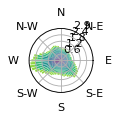

<Figure size 32x24 with 0 Axes>

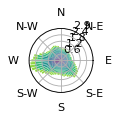

<Figure size 32x24 with 0 Axes>

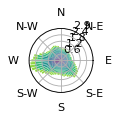

<Figure size 32x24 with 0 Axes>

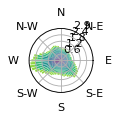

<Figure size 32x24 with 0 Axes>

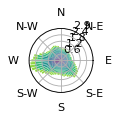

<Figure size 32x24 with 0 Axes>

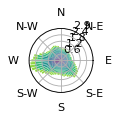

<Figure size 32x24 with 0 Axes>

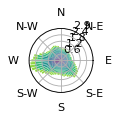

<Figure size 32x24 with 0 Axes>

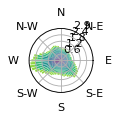

<Figure size 32x24 with 0 Axes>

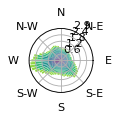

<Figure size 32x24 with 0 Axes>

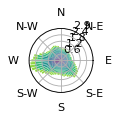

<Figure size 32x24 with 0 Axes>

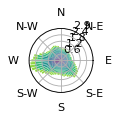

<Figure size 32x24 with 0 Axes>

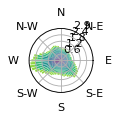

<Figure size 32x24 with 0 Axes>

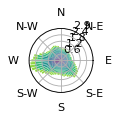

<Figure size 32x24 with 0 Axes>

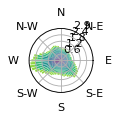

<Figure size 32x24 with 0 Axes>

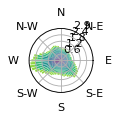

<Figure size 32x24 with 0 Axes>

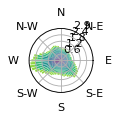

<Figure size 32x24 with 0 Axes>

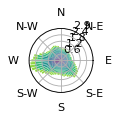

<Figure size 32x24 with 0 Axes>

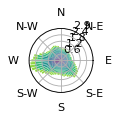

<Figure size 32x24 with 0 Axes>

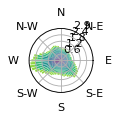

<Figure size 32x24 with 0 Axes>

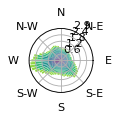

<Figure size 32x24 with 0 Axes>

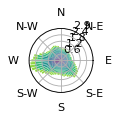

<Figure size 32x24 with 0 Axes>

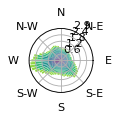

<Figure size 32x24 with 0 Axes>

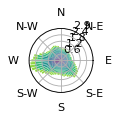

<Figure size 32x24 with 0 Axes>

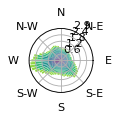

<Figure size 32x24 with 0 Axes>

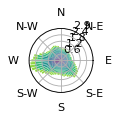

<Figure size 32x24 with 0 Axes>

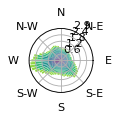

<Figure size 32x24 with 0 Axes>

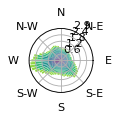

<Figure size 32x24 with 0 Axes>

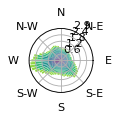

<Figure size 32x24 with 0 Axes>

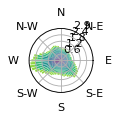

<Figure size 32x24 with 0 Axes>

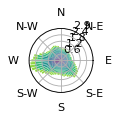

<Figure size 32x24 with 0 Axes>

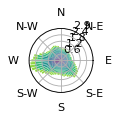

<Figure size 32x24 with 0 Axes>

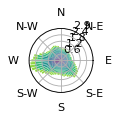

<Figure size 32x24 with 0 Axes>

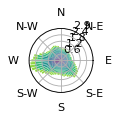

<Figure size 32x24 with 0 Axes>

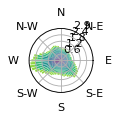

<Figure size 32x24 with 0 Axes>

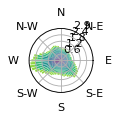

<Figure size 32x24 with 0 Axes>

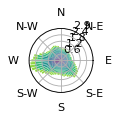

<Figure size 32x24 with 0 Axes>

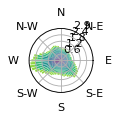

<Figure size 32x24 with 0 Axes>

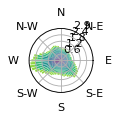

<Figure size 32x24 with 0 Axes>

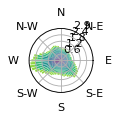

<Figure size 32x24 with 0 Axes>

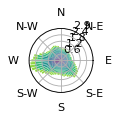

<Figure size 32x24 with 0 Axes>

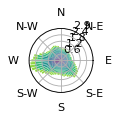

<Figure size 32x24 with 0 Axes>

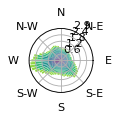

<Figure size 32x24 with 0 Axes>

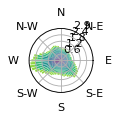

<Figure size 32x24 with 0 Axes>

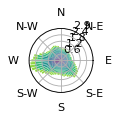

<Figure size 32x24 with 0 Axes>

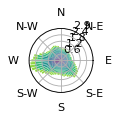

<Figure size 32x24 with 0 Axes>

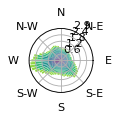

<Figure size 32x24 with 0 Axes>

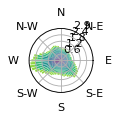

<Figure size 32x24 with 0 Axes>

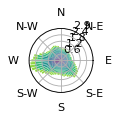

<Figure size 32x24 with 0 Axes>

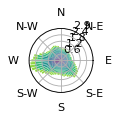

<Figure size 32x24 with 0 Axes>

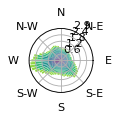

<Figure size 32x24 with 0 Axes>

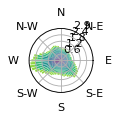

<Figure size 32x24 with 0 Axes>

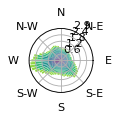

<Figure size 32x24 with 0 Axes>

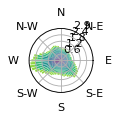

<Figure size 32x24 with 0 Axes>

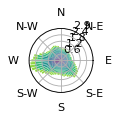

<Figure size 32x24 with 0 Axes>

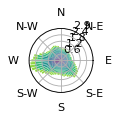

<Figure size 32x24 with 0 Axes>

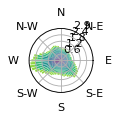

<Figure size 32x24 with 0 Axes>

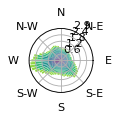

<Figure size 32x24 with 0 Axes>

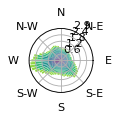

<Figure size 32x24 with 0 Axes>

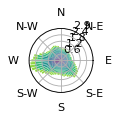

<Figure size 32x24 with 0 Axes>

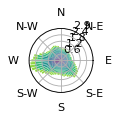

<Figure size 32x24 with 0 Axes>

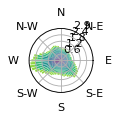

<Figure size 32x24 with 0 Axes>

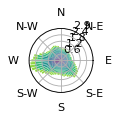

<Figure size 32x24 with 0 Axes>

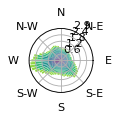

<Figure size 32x24 with 0 Axes>

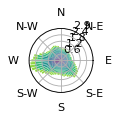

<Figure size 32x24 with 0 Axes>

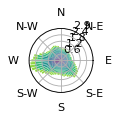

<Figure size 32x24 with 0 Axes>

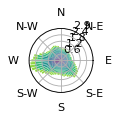

<Figure size 32x24 with 0 Axes>

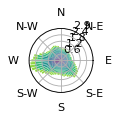

<Figure size 32x24 with 0 Axes>

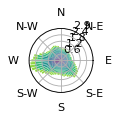

<Figure size 32x24 with 0 Axes>

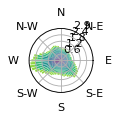

<Figure size 32x24 with 0 Axes>

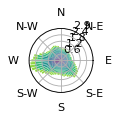

<Figure size 32x24 with 0 Axes>

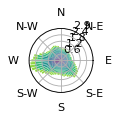

<Figure size 32x24 with 0 Axes>

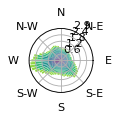

<Figure size 32x24 with 0 Axes>

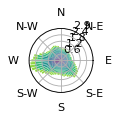

<Figure size 32x24 with 0 Axes>

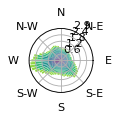

<Figure size 32x24 with 0 Axes>

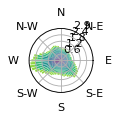

<Figure size 32x24 with 0 Axes>

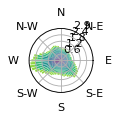

<Figure size 32x24 with 0 Axes>

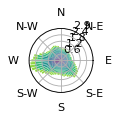

<Figure size 32x24 with 0 Axes>

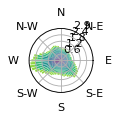

<Figure size 32x24 with 0 Axes>

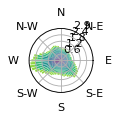

<Figure size 32x24 with 0 Axes>

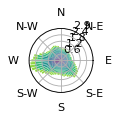

<Figure size 32x24 with 0 Axes>

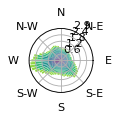

<Figure size 32x24 with 0 Axes>

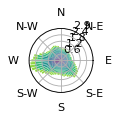

<Figure size 32x24 with 0 Axes>

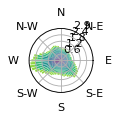

<Figure size 32x24 with 0 Axes>

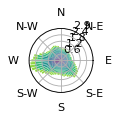

<Figure size 32x24 with 0 Axes>

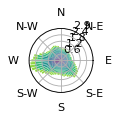

<Figure size 32x24 with 0 Axes>

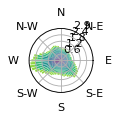

<Figure size 32x24 with 0 Axes>

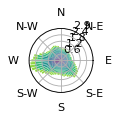

<Figure size 32x24 with 0 Axes>

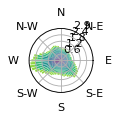

<Figure size 32x24 with 0 Axes>

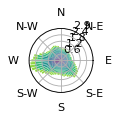

<Figure size 32x24 with 0 Axes>

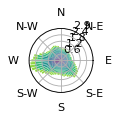

<Figure size 32x24 with 0 Axes>

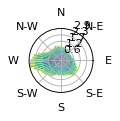

<Figure size 32x24 with 0 Axes>

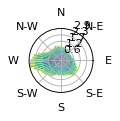

<Figure size 32x24 with 0 Axes>

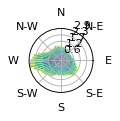

<Figure size 32x24 with 0 Axes>

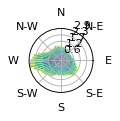

<Figure size 32x24 with 0 Axes>

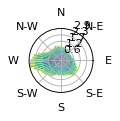

<Figure size 32x24 with 0 Axes>

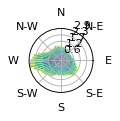

<Figure size 32x24 with 0 Axes>

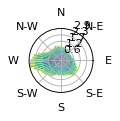

<Figure size 32x24 with 0 Axes>

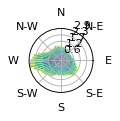

<Figure size 32x24 with 0 Axes>

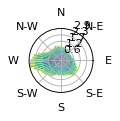

<Figure size 32x24 with 0 Axes>

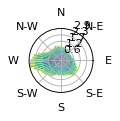

<Figure size 32x24 with 0 Axes>

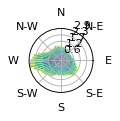

<Figure size 32x24 with 0 Axes>

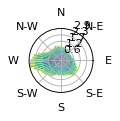

<Figure size 32x24 with 0 Axes>

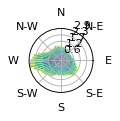

<Figure size 32x24 with 0 Axes>

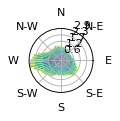

<Figure size 32x24 with 0 Axes>

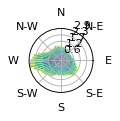

<Figure size 32x24 with 0 Axes>

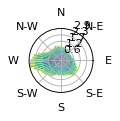

<Figure size 32x24 with 0 Axes>

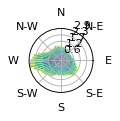

<Figure size 32x24 with 0 Axes>

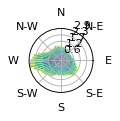

<Figure size 32x24 with 0 Axes>

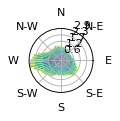

<Figure size 32x24 with 0 Axes>

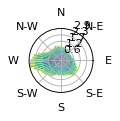

<Figure size 32x24 with 0 Axes>

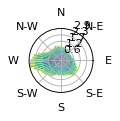

<Figure size 32x24 with 0 Axes>

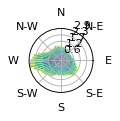

<Figure size 32x24 with 0 Axes>

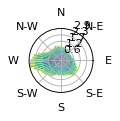

<Figure size 32x24 with 0 Axes>

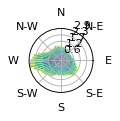

<Figure size 32x24 with 0 Axes>

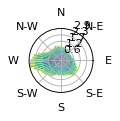

<Figure size 32x24 with 0 Axes>

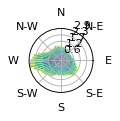

<Figure size 32x24 with 0 Axes>

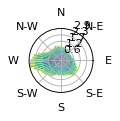

<Figure size 32x24 with 0 Axes>

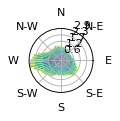

<Figure size 32x24 with 0 Axes>

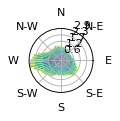

<Figure size 32x24 with 0 Axes>

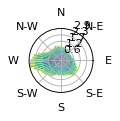

<Figure size 32x24 with 0 Axes>

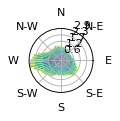

<Figure size 32x24 with 0 Axes>

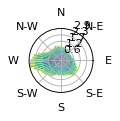

<Figure size 32x24 with 0 Axes>

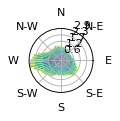

<Figure size 32x24 with 0 Axes>

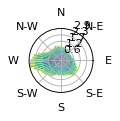

<Figure size 32x24 with 0 Axes>

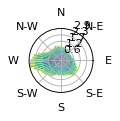

<Figure size 32x24 with 0 Axes>

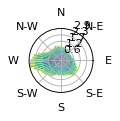

<Figure size 32x24 with 0 Axes>

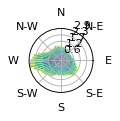

<Figure size 32x24 with 0 Axes>

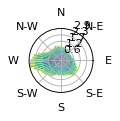

<Figure size 32x24 with 0 Axes>

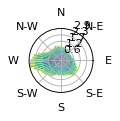

<Figure size 32x24 with 0 Axes>

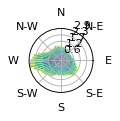

<Figure size 32x24 with 0 Axes>

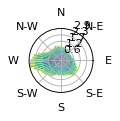

<Figure size 32x24 with 0 Axes>

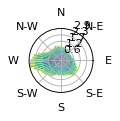

<Figure size 32x24 with 0 Axes>

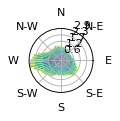

<Figure size 32x24 with 0 Axes>

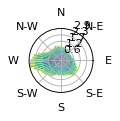

<Figure size 32x24 with 0 Axes>

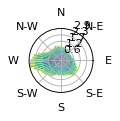

<Figure size 32x24 with 0 Axes>

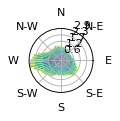

<Figure size 32x24 with 0 Axes>

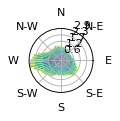

<Figure size 32x24 with 0 Axes>

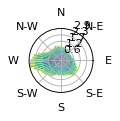

<Figure size 32x24 with 0 Axes>

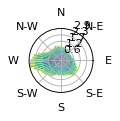

<Figure size 32x24 with 0 Axes>

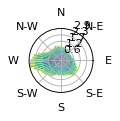

<Figure size 32x24 with 0 Axes>

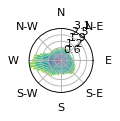

<Figure size 32x24 with 0 Axes>

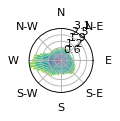

<Figure size 32x24 with 0 Axes>

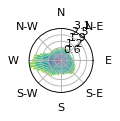

<Figure size 32x24 with 0 Axes>

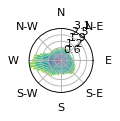

<Figure size 32x24 with 0 Axes>

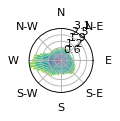

<Figure size 32x24 with 0 Axes>

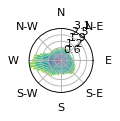

<Figure size 32x24 with 0 Axes>

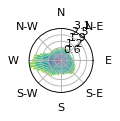

<Figure size 32x24 with 0 Axes>

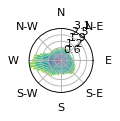

<Figure size 32x24 with 0 Axes>

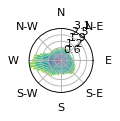

<Figure size 32x24 with 0 Axes>

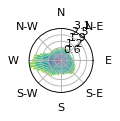

<Figure size 32x24 with 0 Axes>

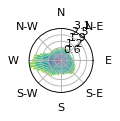

<Figure size 32x24 with 0 Axes>

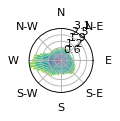

<Figure size 32x24 with 0 Axes>

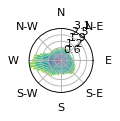

<Figure size 32x24 with 0 Axes>

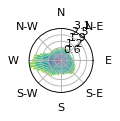

<Figure size 32x24 with 0 Axes>

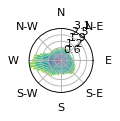

<Figure size 32x24 with 0 Axes>

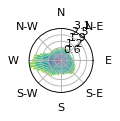

<Figure size 32x24 with 0 Axes>

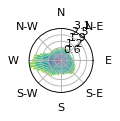

<Figure size 32x24 with 0 Axes>

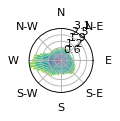

<Figure size 32x24 with 0 Axes>

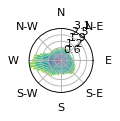

<Figure size 32x24 with 0 Axes>

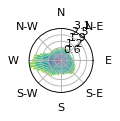

<Figure size 32x24 with 0 Axes>

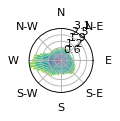

<Figure size 32x24 with 0 Axes>

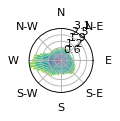

<Figure size 32x24 with 0 Axes>

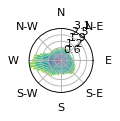

<Figure size 32x24 with 0 Axes>

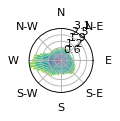

<Figure size 32x24 with 0 Axes>

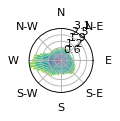

<Figure size 32x24 with 0 Axes>

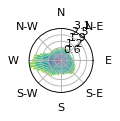

<Figure size 32x24 with 0 Axes>

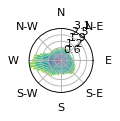

<Figure size 32x24 with 0 Axes>

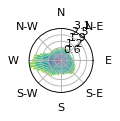

<Figure size 32x24 with 0 Axes>

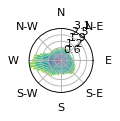

<Figure size 32x24 with 0 Axes>

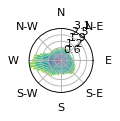

<Figure size 32x24 with 0 Axes>

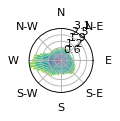

<Figure size 32x24 with 0 Axes>

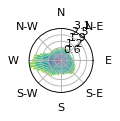

<Figure size 32x24 with 0 Axes>

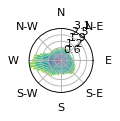

<Figure size 32x24 with 0 Axes>

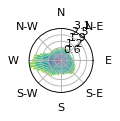

<Figure size 32x24 with 0 Axes>

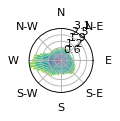

<Figure size 32x24 with 0 Axes>

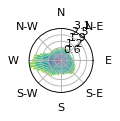

<Figure size 32x24 with 0 Axes>

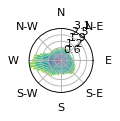

<Figure size 32x24 with 0 Axes>

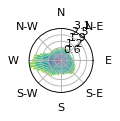

<Figure size 32x24 with 0 Axes>

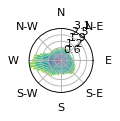

<Figure size 32x24 with 0 Axes>

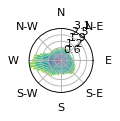

<Figure size 32x24 with 0 Axes>

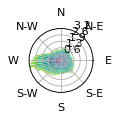

<Figure size 32x24 with 0 Axes>

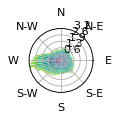

<Figure size 32x24 with 0 Axes>

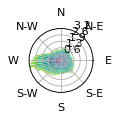

<Figure size 32x24 with 0 Axes>

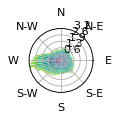

<Figure size 32x24 with 0 Axes>

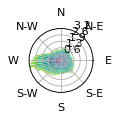

<Figure size 32x24 with 0 Axes>

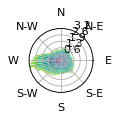

<Figure size 32x24 with 0 Axes>

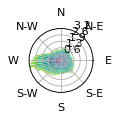

<Figure size 32x24 with 0 Axes>

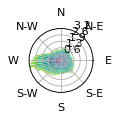

<Figure size 32x24 with 0 Axes>

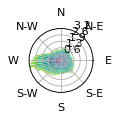

<Figure size 32x24 with 0 Axes>

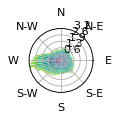

<Figure size 32x24 with 0 Axes>

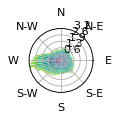

<Figure size 32x24 with 0 Axes>

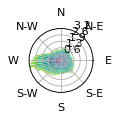

<Figure size 32x24 with 0 Axes>

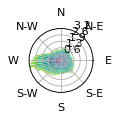

<Figure size 32x24 with 0 Axes>

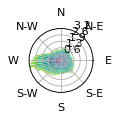

<Figure size 32x24 with 0 Axes>

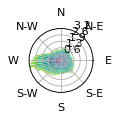

<Figure size 32x24 with 0 Axes>

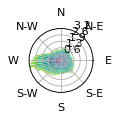

<Figure size 32x24 with 0 Axes>

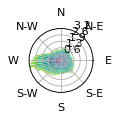

<Figure size 32x24 with 0 Axes>

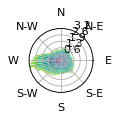

<Figure size 32x24 with 0 Axes>

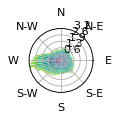

<Figure size 32x24 with 0 Axes>

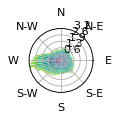

<Figure size 32x24 with 0 Axes>

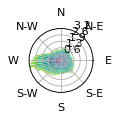

<Figure size 32x24 with 0 Axes>

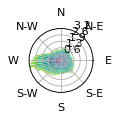

<Figure size 32x24 with 0 Axes>

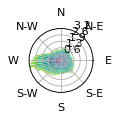

<Figure size 32x24 with 0 Axes>

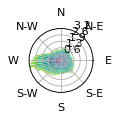

<Figure size 32x24 with 0 Axes>

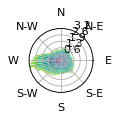

<Figure size 32x24 with 0 Axes>

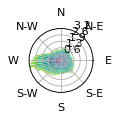

<Figure size 32x24 with 0 Axes>

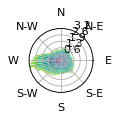

<Figure size 32x24 with 0 Axes>

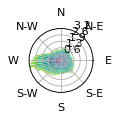

<Figure size 32x24 with 0 Axes>

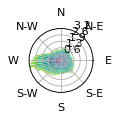

<Figure size 32x24 with 0 Axes>

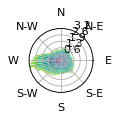

<Figure size 32x24 with 0 Axes>

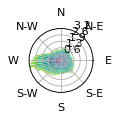

<Figure size 32x24 with 0 Axes>

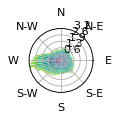

<Figure size 32x24 with 0 Axes>

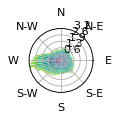

<Figure size 32x24 with 0 Axes>

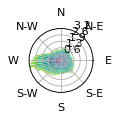

<Figure size 32x24 with 0 Axes>

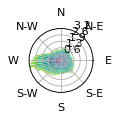

<Figure size 32x24 with 0 Axes>

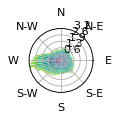

<Figure size 32x24 with 0 Axes>

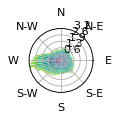

<Figure size 32x24 with 0 Axes>

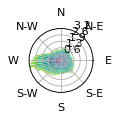

<Figure size 32x24 with 0 Axes>

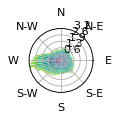

<Figure size 32x24 with 0 Axes>

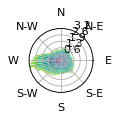

<Figure size 32x24 with 0 Axes>

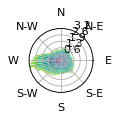

<Figure size 32x24 with 0 Axes>

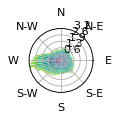

<Figure size 32x24 with 0 Axes>

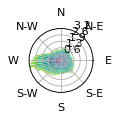

<Figure size 32x24 with 0 Axes>

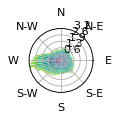

<Figure size 32x24 with 0 Axes>

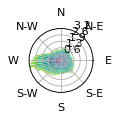

<Figure size 32x24 with 0 Axes>

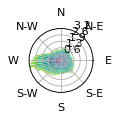

<Figure size 32x24 with 0 Axes>

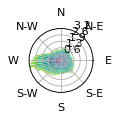

<Figure size 32x24 with 0 Axes>

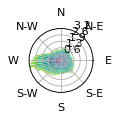

<Figure size 32x24 with 0 Axes>

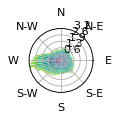

<Figure size 32x24 with 0 Axes>

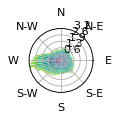

<Figure size 32x24 with 0 Axes>

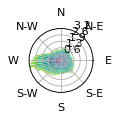

<Figure size 32x24 with 0 Axes>

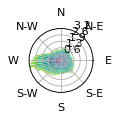

<Figure size 32x24 with 0 Axes>

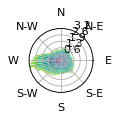

<Figure size 32x24 with 0 Axes>

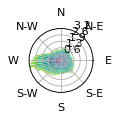

<Figure size 32x24 with 0 Axes>

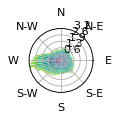

<Figure size 32x24 with 0 Axes>

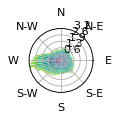

<Figure size 32x24 with 0 Axes>

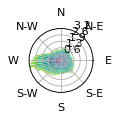

<Figure size 32x24 with 0 Axes>

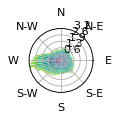

<Figure size 32x24 with 0 Axes>

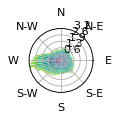

<Figure size 32x24 with 0 Axes>

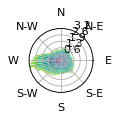

<Figure size 32x24 with 0 Axes>

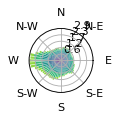

<Figure size 32x24 with 0 Axes>

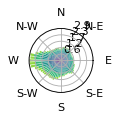

<Figure size 32x24 with 0 Axes>

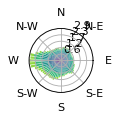

<Figure size 32x24 with 0 Axes>

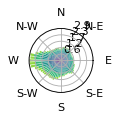

<Figure size 32x24 with 0 Axes>

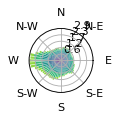

<Figure size 32x24 with 0 Axes>

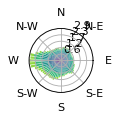

<Figure size 32x24 with 0 Axes>

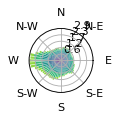

<Figure size 32x24 with 0 Axes>

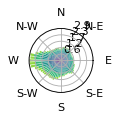

<Figure size 32x24 with 0 Axes>

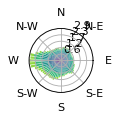

<Figure size 32x24 with 0 Axes>

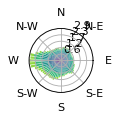

<Figure size 32x24 with 0 Axes>

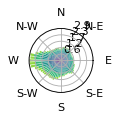

<Figure size 32x24 with 0 Axes>

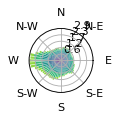

<Figure size 32x24 with 0 Axes>

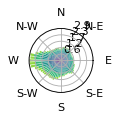

<Figure size 32x24 with 0 Axes>

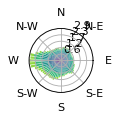

<Figure size 32x24 with 0 Axes>

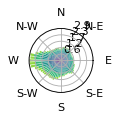

<Figure size 32x24 with 0 Axes>

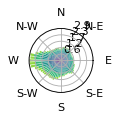

<Figure size 32x24 with 0 Axes>

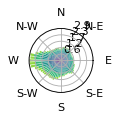

<Figure size 32x24 with 0 Axes>

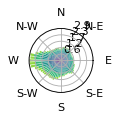

<Figure size 32x24 with 0 Axes>

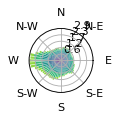

<Figure size 32x24 with 0 Axes>

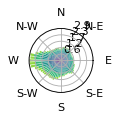

<Figure size 32x24 with 0 Axes>

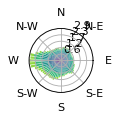

<Figure size 32x24 with 0 Axes>

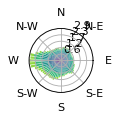

<Figure size 32x24 with 0 Axes>

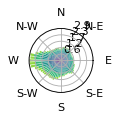

<Figure size 32x24 with 0 Axes>

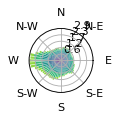

<Figure size 32x24 with 0 Axes>

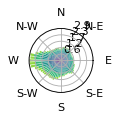

<Figure size 32x24 with 0 Axes>

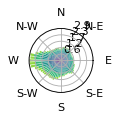

<Figure size 32x24 with 0 Axes>

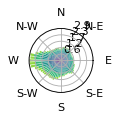

<Figure size 32x24 with 0 Axes>

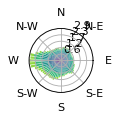

<Figure size 32x24 with 0 Axes>

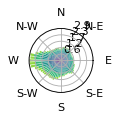

<Figure size 32x24 with 0 Axes>

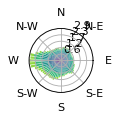

<Figure size 32x24 with 0 Axes>

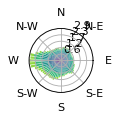

<Figure size 32x24 with 0 Axes>

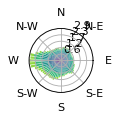

<Figure size 32x24 with 0 Axes>

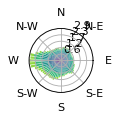

<Figure size 32x24 with 0 Axes>

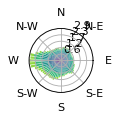

<Figure size 32x24 with 0 Axes>

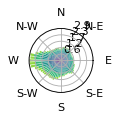

<Figure size 32x24 with 0 Axes>

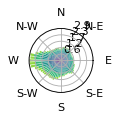

<Figure size 32x24 with 0 Axes>

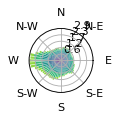

<Figure size 32x24 with 0 Axes>

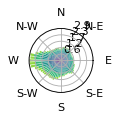

<Figure size 32x24 with 0 Axes>

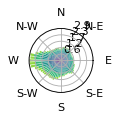

<Figure size 32x24 with 0 Axes>

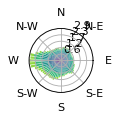

<Figure size 32x24 with 0 Axes>

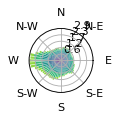

<Figure size 32x24 with 0 Axes>

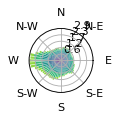

<Figure size 32x24 with 0 Axes>

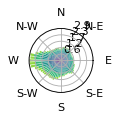

<Figure size 32x24 with 0 Axes>

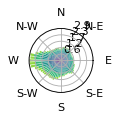

<Figure size 32x24 with 0 Axes>

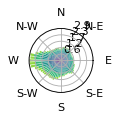

<Figure size 32x24 with 0 Axes>

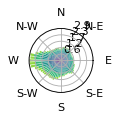

<Figure size 32x24 with 0 Axes>

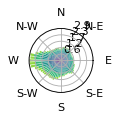

<Figure size 32x24 with 0 Axes>

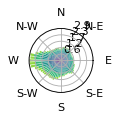

<Figure size 32x24 with 0 Axes>

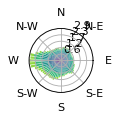

<Figure size 32x24 with 0 Axes>

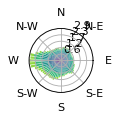

<Figure size 32x24 with 0 Axes>

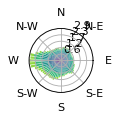

<Figure size 32x24 with 0 Axes>

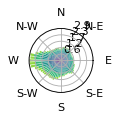

<Figure size 32x24 with 0 Axes>

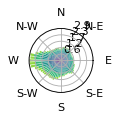

<Figure size 32x24 with 0 Axes>

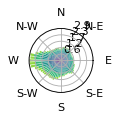

<Figure size 32x24 with 0 Axes>

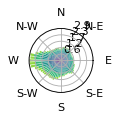

<Figure size 32x24 with 0 Axes>

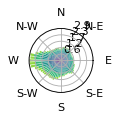

<Figure size 32x24 with 0 Axes>

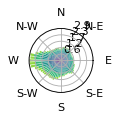

<Figure size 32x24 with 0 Axes>

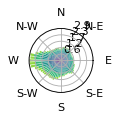

<Figure size 32x24 with 0 Axes>

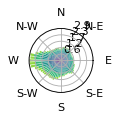

<Figure size 32x24 with 0 Axes>

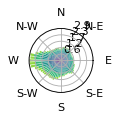

<Figure size 32x24 with 0 Axes>

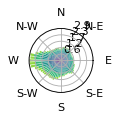

<Figure size 32x24 with 0 Axes>

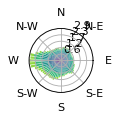

<Figure size 32x24 with 0 Axes>

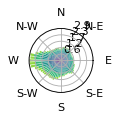

<Figure size 32x24 with 0 Axes>

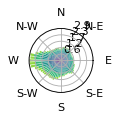

<Figure size 32x24 with 0 Axes>

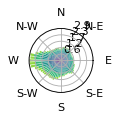

<Figure size 32x24 with 0 Axes>

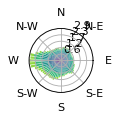

<Figure size 32x24 with 0 Axes>

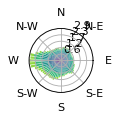

<Figure size 32x24 with 0 Axes>

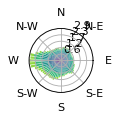

<Figure size 32x24 with 0 Axes>

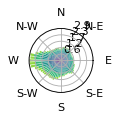

<Figure size 32x24 with 0 Axes>

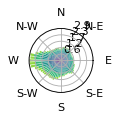

<Figure size 32x24 with 0 Axes>

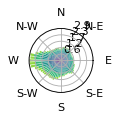

<Figure size 32x24 with 0 Axes>

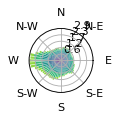

<Figure size 32x24 with 0 Axes>

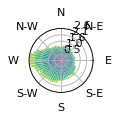

<Figure size 32x24 with 0 Axes>

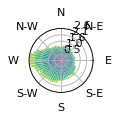

<Figure size 32x24 with 0 Axes>

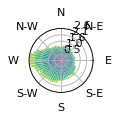

<Figure size 32x24 with 0 Axes>

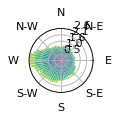

<Figure size 32x24 with 0 Axes>

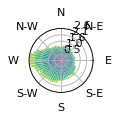

<Figure size 32x24 with 0 Axes>

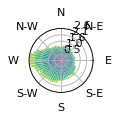

<Figure size 32x24 with 0 Axes>

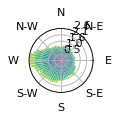

<Figure size 32x24 with 0 Axes>

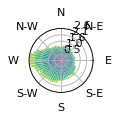

<Figure size 32x24 with 0 Axes>

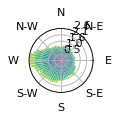

<Figure size 32x24 with 0 Axes>

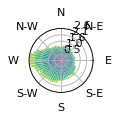

<Figure size 32x24 with 0 Axes>

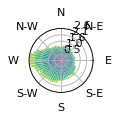

<Figure size 32x24 with 0 Axes>

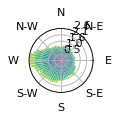

<Figure size 32x24 with 0 Axes>

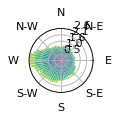

<Figure size 32x24 with 0 Axes>

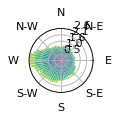

<Figure size 32x24 with 0 Axes>

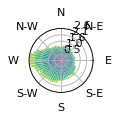

<Figure size 32x24 with 0 Axes>

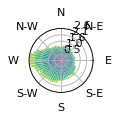

<Figure size 32x24 with 0 Axes>

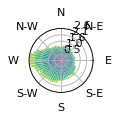

<Figure size 32x24 with 0 Axes>

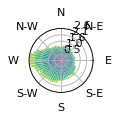

<Figure size 32x24 with 0 Axes>

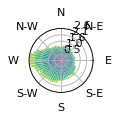

<Figure size 32x24 with 0 Axes>

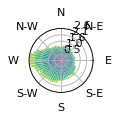

<Figure size 32x24 with 0 Axes>

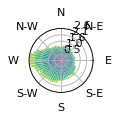

<Figure size 32x24 with 0 Axes>

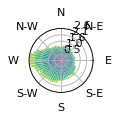

<Figure size 32x24 with 0 Axes>

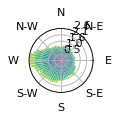

<Figure size 32x24 with 0 Axes>

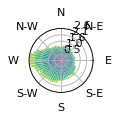

<Figure size 32x24 with 0 Axes>

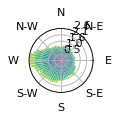

<Figure size 32x24 with 0 Axes>

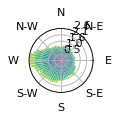

<Figure size 32x24 with 0 Axes>

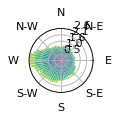

<Figure size 32x24 with 0 Axes>

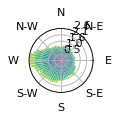

<Figure size 32x24 with 0 Axes>

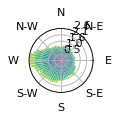

<Figure size 32x24 with 0 Axes>

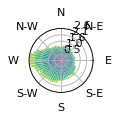

<Figure size 32x24 with 0 Axes>

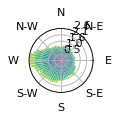

<Figure size 32x24 with 0 Axes>

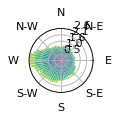

<Figure size 32x24 with 0 Axes>

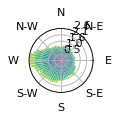

<Figure size 32x24 with 0 Axes>

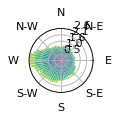

<Figure size 32x24 with 0 Axes>

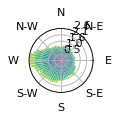

<Figure size 32x24 with 0 Axes>

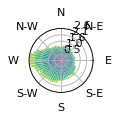

<Figure size 32x24 with 0 Axes>

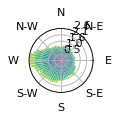

<Figure size 32x24 with 0 Axes>

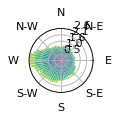

<Figure size 32x24 with 0 Axes>

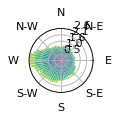

<Figure size 32x24 with 0 Axes>

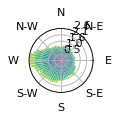

<Figure size 32x24 with 0 Axes>

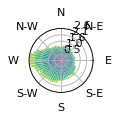

<Figure size 32x24 with 0 Axes>

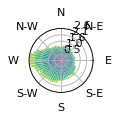

<Figure size 32x24 with 0 Axes>

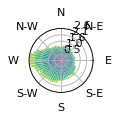

<Figure size 32x24 with 0 Axes>

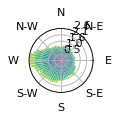

<Figure size 32x24 with 0 Axes>

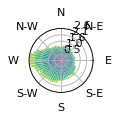

<Figure size 32x24 with 0 Axes>

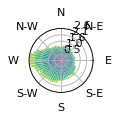

<Figure size 32x24 with 0 Axes>

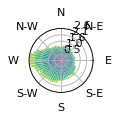

<Figure size 32x24 with 0 Axes>

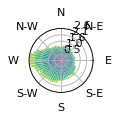

<Figure size 32x24 with 0 Axes>

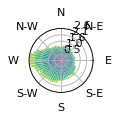

<Figure size 32x24 with 0 Axes>

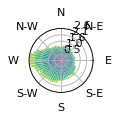

<Figure size 32x24 with 0 Axes>

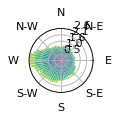

<Figure size 32x24 with 0 Axes>

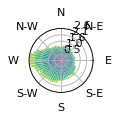

<Figure size 32x24 with 0 Axes>

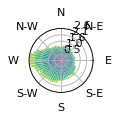

<Figure size 32x24 with 0 Axes>

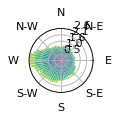

<Figure size 32x24 with 0 Axes>

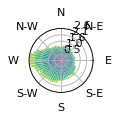

<Figure size 32x24 with 0 Axes>

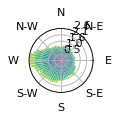

<Figure size 32x24 with 0 Axes>

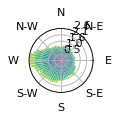

<Figure size 32x24 with 0 Axes>

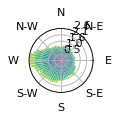

<Figure size 32x24 with 0 Axes>

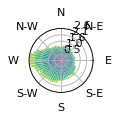

<Figure size 32x24 with 0 Axes>

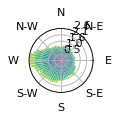

<Figure size 32x24 with 0 Axes>

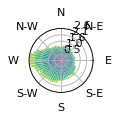

<Figure size 32x24 with 0 Axes>

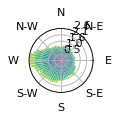

<Figure size 32x24 with 0 Axes>

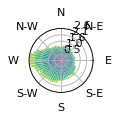

<Figure size 32x24 with 0 Axes>

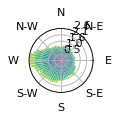

In [2]:
#Реализация для расчета одного установленного периода

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
from matplotlib import pyplot
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
import math
import xarray as xr
from windrose import WindroseAxes
from scipy import interpolate

# 1. Загрузка шейп-файла береговой линии (упрощенная для расчетов полос разгона)
shoreline_gdf = gpd.read_file('D:/PyProjects/Knaps/coastline_sms.shp', crs="EPSG:32634") #!!!!!!!!!!!!
# 1. Загрузка шейп-файла трансект с параметрами координаты центра лежит на береговой линии, угол bearing - результат построения трансект в гис по подробной береговой линии
transects_gdf = gpd.read_file('D:/PyProjects/Knaps/transects_gdf_era5utm.shp', crs="EPSG:32634")
calc_gdf = gpd.GeoDataFrame(transects_gdf.copy(), geometry=gpd.points_from_xy(transects_gdf.copy().INSIDE_X, transects_gdf.copy().INSIDE_Y), crs="EPSG:32634")

#year_of_calculation = 2000
rhumb_sectors=64 #!!!!!!! Румбовая дискретизация
speed_bins=4 #!!!!!!!!
ERAlat = float(transects_gdf.NEAR_Y_1[0])
ERAlong = float(transects_gdf.NEAR_X_1[0])
start_date = "2000-01-01"
end_date = "2024-12-31"
point_x = float(transects_gdf.INSIDE_X[0])
point_y = float(transects_gdf.INSIDE_Y[0])
normal_to_beach = float(transects_gdf.BEARING[0])


def Knaps1961gdb(shoreline_gdf, 
                 point_x,
                 point_y,
                 normal_to_beach, 
                 rhumb_sectors, 
                 speed_bins,
                 ERAlat,
                 ERAlong,
                 ):
    #outlist = list()
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)
    
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    start_date = "2000-01-01"
    end_date = "2024-12-31"
    params = {
        "latitude": ERAlat, #!!!!!!!!!
        "longitude": ERAlong, #!!!!!!!!!!
        "start_date": start_date, #!!!!!!!!!!
        "end_date": end_date, #!!!!!!!!!!!
        "hourly": ["wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
        "wind_speed_unit": "ms",
        "timezone": "UTC",
        "models": "era5"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data. The order of variables needs to be the same as requested.

    hourly = response.Hourly()
    hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(2).ValuesAsNumpy()


    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd()-1, unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval())
    )}
    hourly_data["speed"] = hourly_wind_speed_10m
    hourly_data["direction"] = hourly_wind_direction_10m
    hourly_data["gusts"] = hourly_wind_gusts_10m
    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe["year"] = pd.DatetimeIndex(hourly_dataframe['date']).year
    hourly_dataframe["month"] = pd.DatetimeIndex(hourly_dataframe['date']).month
    #hourly_dataframe["speed"] = hourly_dataframe["speed"][hourly_dataframe["speed"] > 12]
    hourly_dataframe["speed"].where(hourly_dataframe["speed"] <= 12, 0, inplace=True)
    # Функция для округления направления ветра до ближайшего значения из списка directions
    def round_dir(direction, directions):
        closest = min(directions, key=lambda x: abs(x - direction))
        return closest


    ws = hourly_dataframe["speed"]
    wd = hourly_dataframe["direction"]
    fig = plt.figure(dpi=5)
    ax = WindroseAxes.from_ax(figsize=(1, 1))
    #ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, nsector=rhumb_sectors, bins=speed_bins)
    ax._info["frq"] = np.sum(ax._info["table"], axis=0)
    hourly_dataframe['rounded_direction'] = hourly_dataframe['direction'].apply(lambda x: round_dir(x, ax._info["dir"])) # Округляем все направления ветра до ближайших значений из списка directions

    # Направление нормали к берегу в градусах (например, 0° означает, что берег открыт ветрам с севера)

    ax_dataframe = pd.DataFrame.from_dict(data = {'dir': ax._info['dir'], 'freq': ax._info['frq']})
    sector_mean_speed = hourly_dataframe.groupby('rounded_direction')['speed'].mean().reset_index(name='mean_speed')
    ax_dataframe['V'] = sector_mean_speed['mean_speed']

    def filter_active_rumbs(df, normal_to_beach, wind_direction_column='wind_direction'):
        # Определяем границы активного диапазона вокруг нормали
        lower_bound = (normal_to_beach - 90) % 360
        upper_bound = (normal_to_beach + 90) % 360

        if lower_bound > upper_bound:
            # Если граница пересекает 0/360, используем два условия
            index = ((df[wind_direction_column] >= lower_bound) | (df[wind_direction_column] <= upper_bound))
        else:
            # Обычное условие для непрерывного интервала
            index = ((df[wind_direction_column] >= lower_bound) & (df[wind_direction_column] <= upper_bound))

        return df[index]


    def wind_power(V): #Мощность, V^3
        windpower = V * V * V
        return windpower
    def wind_energy(frequency, windpower): #Ветровая энергия, PV^3
        windenergy = frequency * windpower
        return windenergy
    def fetch_factor(fetchlength): #Коэффициент длины рагона, кубический корень из длины разгона (в км)
        return fetchlength ** 0.333
    def get_e0(frequency, windpower, fetchfactor): #Величина румбовой энергии e0 = PV^3*D^0.333/1000
        e0 = (frequency * windpower * fetchfactor) / 1000
        return e0
    def get_rhumb_fulness(): #Коэффициент полноты румбовых секторов
        K=1 #Для малой дискретизации (даже 5 градусов) считаю можно всегда 1 оставлять
        return K
    def get_e(K, e0): #Приведенная румбовая энергия e = Ke0
        e = K * e0
        return e
    def getenergy(V, frequency, fetchlength, K=1):
        windpowert = wind_power(V)
        windenergyt = wind_energy(frequency, windpowert)
        fetchfactort = fetch_factor(fetchlength)
        e0t = get_e0(frequency, windpowert, fetchfactort)
        et = get_e(K, e0t)
        return et
    def get_y0(normal_angle, rhumb_angle): #Определение угла подхода y0
        # Переводим углы из градусов в радианы
        rad1 = np.radians(normal_angle)
        rad2 = np.radians(rhumb_angle)
        # Вычисляем разность углов
        diff = (rad1 - rad2) % (2 * np.pi)
        # Преобразуем результат обратно в градусы
        y0 = np.degrees(np.where(diff > np.pi, diff - 2 * np.pi, diff))
        return y0
    def get_alongc(y0): #Коэффициент действенности вдоль берега
        polarity = np.sign(y0)
        y0 = np.abs(y0)
        y0arr = np.array([0, 20, 40, 45, 50, 60, 90, 110, 120, 180])
        Sarr = np.array([0, 0.63, 0.965, 1, 0.975 ,0.87, 0.435, 0.135, 0, 0])
        falong = interpolate.interp1d(y0arr, Sarr)
        return polarity * falong(y0)
    def get_crossc(y0): #Коэффициент действенности прибоя
        polarity = np.sign(y0)
        y0 = np.abs(y0)
        y0arr = np.array([0, 20, 45, 60, 90, 110, 120, 180])
        Barr = np.array([1, 0.93, 0.71, 0.58, 0.28, 0.1, 0, 0])
        fcross = interpolate.interp1d(y0arr, Barr)
        return fcross(y0)
    def get_tforce(e, alongc): #Наносодвижущая сила
        t = e * alongc
        return t
    def get_bforce(e, crossc): #Сила прибоя
        b = e * crossc
        return b


    start_point = Point(point_x, point_y)
    def calculate_distance_along_ray(point, linestring, direction_angle, max_distance=1000000):
        """
        Рассчитывает расстояние от точки до пересечения с линией по направлению угла.

        :param point: Начальная точка (Shapely Point)
        :param linestring: Линия (Shapely LineString)
        :param direction_angle: Направление в градусах (от 0 до 360)
        :param max_distance: Максимальная длина луча (по умолчанию 1000 км)
        :return: Расстояние до пересечения с линией
        """
        # Преобразуем угол направления в радианы
        angle_rad = np.radians(direction_angle)

        # Вычисляем вектор движения по углу
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        # Определяем конечную точку луча (на расстоянии max_distance)
        end_point = Point(point.x + dx * max_distance, point.y + dy * max_distance)

        # Строим линию от начальной точки до конечной точки
        ray = LineString([point, end_point])

        # Находим пересечение луча с линией береговой линии
        intersection = ray.intersection(linestring)

        if not intersection.is_empty:
            return point.distance(intersection)
        else:
            return None


    # 3. Выполнение расчетов для различных направлений (например, каждые 10 градусов)
    angles = ax_dataframe['dir']
    distances = []
    directions = []

    for angle in angles:
        for _, row in shoreline_gdf.iterrows():
            distance = calculate_distance_along_ray(start_point, row['geometry'], angle, max_distance=1000000)

            if distance is not None:
                distances.append(distance / 1000)  # Преобразуем метры в километры
                directions.append((90 - angle) % 360) # Вращаемся на 90 крадусов, т.к. расчет в гис ведется от востока
                break

    # 4. Формирование таблицы Pandas
    result_df = ax_dataframe.set_index('dir').join((pd.DataFrame({
        'dir': directions,
        'Rhumbdir': directions,
        'D': distances
    })).set_index('Rhumbdir'))


    # Отображение результатов

    rhumbdf = result_df #pd.DataFrame.from_dict(data=input_data, orient='index', columns = ['Name','Rhumbdir', 'P', 'V', 'D'])
    rhumbdf['Energy'] = getenergy(V = rhumbdf['V'], frequency = rhumbdf['freq'], fetchlength = rhumbdf['D'], K = 1)
    rhumbdf['y0'] = get_y0(normal_angle=normal_to_beach, rhumb_angle=rhumbdf['dir'])
    rhumbdf['alongc'] = get_alongc(y0=rhumbdf['y0'])
    rhumbdf['crossc'] = get_crossc(y0=rhumbdf['y0'])
    rhumbdf['t'] = get_tforce(e=rhumbdf['Energy'], alongc=rhumbdf['alongc'])
    rhumbdf['b'] = get_bforce(e=rhumbdf['Energy'], crossc=rhumbdf['crossc'])

    

    awd = filter_active_rumbs(rhumbdf, normal_to_beach, wind_direction_column='dir')
    
    # Создаем копию данных, чтобы избежать изменения исходного DataFrame
    df_copy = awd.copy()
    
    # Преобразуем NaN значения к нулю, чтобы они не влияли на сумму
    df_copy['t'].fillna(0, inplace=True)
    
    # Находим положительные и отрицательные значения
    T1 = (df_copy['t'][df_copy['t'] > 0]).sum()
    T2 = (df_copy['t'][df_copy['t'] < 0]).sum()
    T = T1 + T2
    A = np.abs(T1) + np.abs(T2)
    B = df_copy['b'].sum()
    E = np.sqrt(np.power(T, 2) + np.power(B, 2))
    t = T / B
    y = np.rad2deg(np.arctan2(T, B))
    thau = (normal_to_beach + y) % 360
    output = {'point_x':point_x, 
        'point_y':point_y,
        'year':"2025",
        'era_lat':ERAlat, 
        'era_long':ERAlong, 
        'normal_to_beach':normal_to_beach,
        'T1':T1,
        'T2':T2,
        'T':T,
        'A':A,
        'B':B,
        'E':E,
        't':t,
        'y':y,
        'thau':thau,
        'table':df_copy,
        #'fig':fig
             }
    print(output)
    outlist.append(output)
    return output
outlist = list()
calc_gdf2 = calc_gdf.apply(lambda row: Knaps1961gdb(shoreline_gdf=shoreline_gdf, 
                                                                          point_x=row['INSIDE_X'], 
                                                                          point_y=row['INSIDE_Y'],
                                                                          normal_to_beach=row['BEARING'], 
                                                                          rhumb_sectors=64, 
                                                                          speed_bins=7, 
                                                                          ERAlong=row['NEAR_X_1'], 
                                                                          ERAlat=row['NEAR_Y_1'], 
                                                                         ), axis=1, result_type='broadcast')
result_gdf = gpd.GeoDataFrame(pd.DataFrame(outlist), geometry=gpd.points_from_xy(pd.DataFrame(outlist).point_x, pd.DataFrame(outlist).point_y), crs="EPSG:32634")
result_gdf['table'] = str('0')
result_gdf.to_file('knaps_21cent_st.shp', driver='ESRI Shapefile')